In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')


sns.set_palette("colorblind")
sns.set(font_scale = 1.3)
sns.set_style("whitegrid")

In [2]:
survey_vitals = pd.read_csv("survey_vitals_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
eval_med = pd.read_csv("evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
history_env = pd.read_csv("history_env_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()

In [3]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


In [4]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


# Clustering based on geopoint data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [6]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  
0 -70.743801  NaN      NaN  34.0  female  
1 -70.744104  NaN      NaN  52.0  female  
2 -70.744016  NaN      NaN  39.0    male  
3 -70.744557  NaN      NaN  39.0  female  
4 -70.745053  NaN      NaN  23.0    male

In [7]:
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]

In [8]:
scaler = StandardScaler()

In [9]:
transformed_geo = scaler.fit_transform(geo_loc)

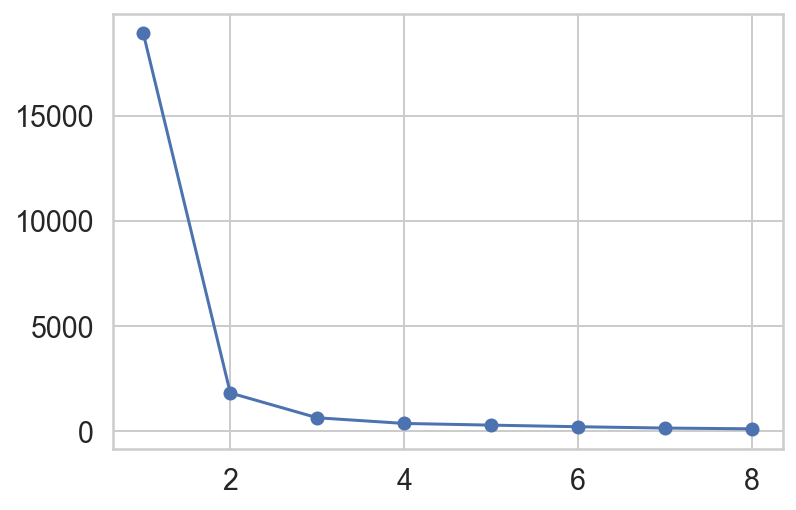

In [10]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [11]:
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([1, 1, 1, ..., 2, 2, 2])

In [12]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  clustersByLoc  
0 -70.743801  NaN      NaN  34.0  female              1  
1 -70.744104  NaN      NaN  52.0  female              1  
2 -70.744016  NaN      NaN  39.0    male              1  
3 -70.744557  NaN      NaN  39.0  female              1  
4 -70.745053  NaN      NaN  23.0    male              1

In [13]:
def province_clean(cluster):
    if cluster == 0:
        return "Lavega"
    elif cluster == 1:
        return "San Pedro de Macoris"
    elif cluster == 2:
        return "Santiago"
    else:
        return "San Pedro de Macoris/North"

In [14]:
survey_vitals = survey_vitals.drop(columns = ["city", "province"], axis = 1)
survey_vitals["province"] = survey_vitals["clustersByLoc"].apply(province_clean)

In [15]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude   age     sex  clustersByLoc              province  
0 -70.743801  34.0  female              1  San Pedro de Macoris  
1 -70.744104  52.0  female              1  San Pedro de Macoris  
2 -70.744016  39.0    male              1  San Pedro de Macoris  
3 -70.744557  39.0  female              1  San Pedro de Macoris  
4 -70.745053  23.0    male              1  San Pedro de Macoris

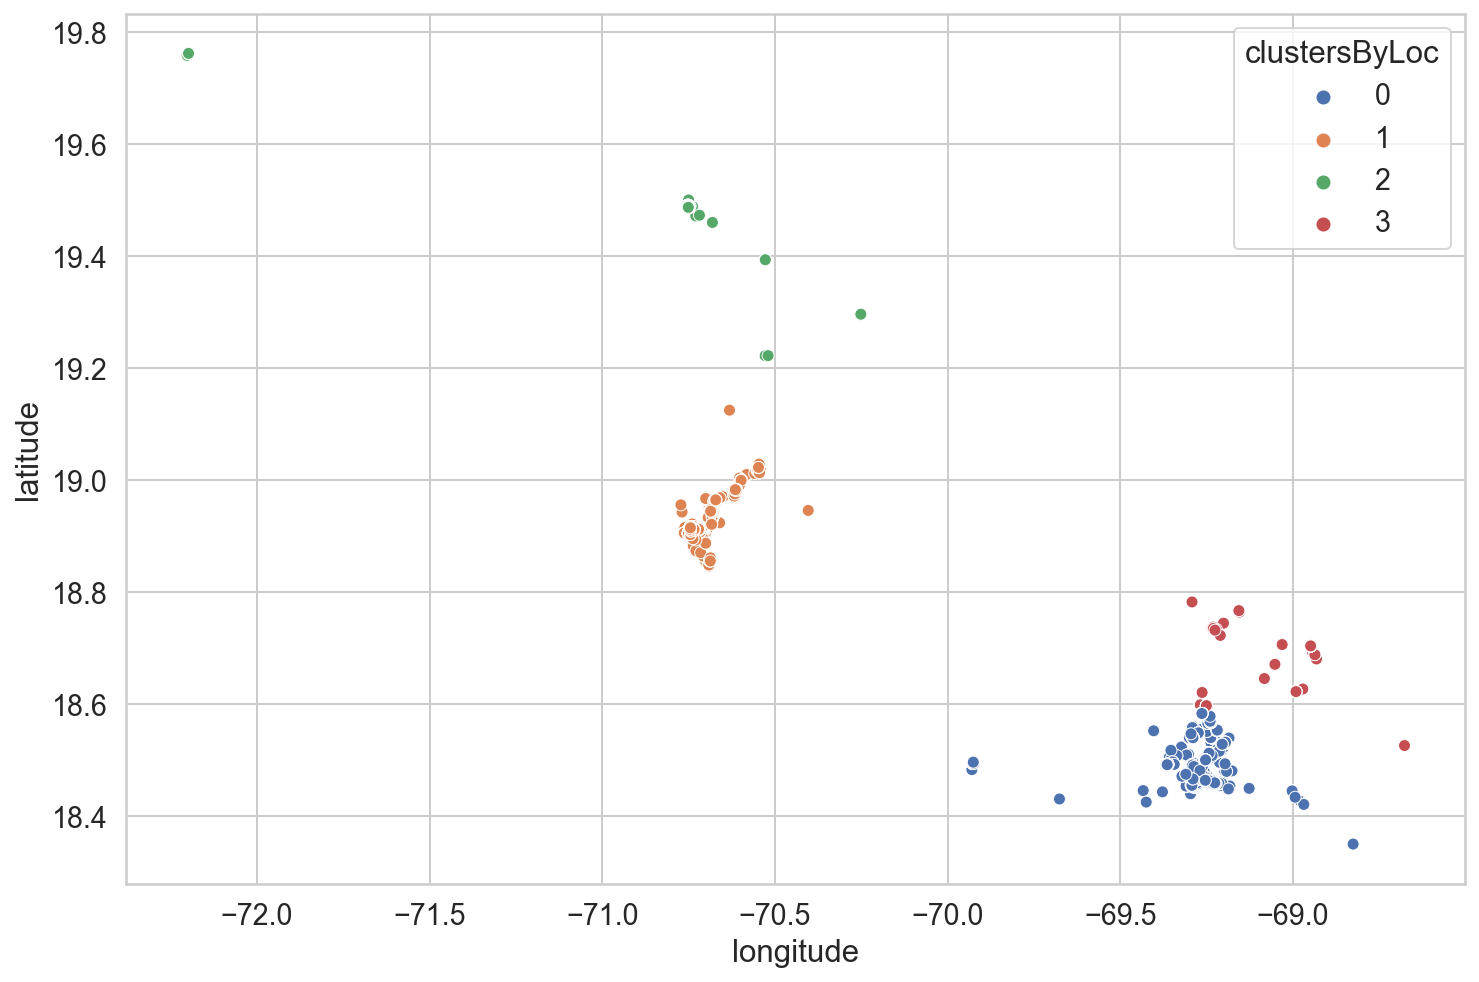

In [16]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "clustersByLoc", palette = "deep")

# Dealing with missing values: survey_vitals

### 1. survey_vitals

In [17]:
survey_vitals.shape

(9458, 10)

In [18]:
# delete marriagestatus

In [19]:
survey_vitals.isna().sum()

objectId             0
marriageStatus    1597
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                482
sex                  0
clustersByLoc        0
province             0
dtype: int64

In [20]:
# filling missing values in marriageStatus column based on distribution
s = survey_vitals.marriageStatus.value_counts(normalize = True)
s

single        0.452487
free_union    0.340287
married       0.127465
widow         0.042743
concubine     0.037018
Name: marriageStatus, dtype: float64

In [21]:
missing = survey_vitals["marriageStatus"].isnull()
survey_vitals.loc[missing, "marriageStatus"] = np.random.choice(s.index, size=len(survey_vitals[missing]),p=s.values)

In [22]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude   age     sex  clustersByLoc              province  
0 -70.743801  34.0  female              1  San Pedro de Macoris  
1 -70.744104  52.0  female              1  San Pedro de Macoris  
2 -70.744016  39.0    male              1  San Pedro de Macoris  
3 -70.744557  39.0  female              1  San Pedro de Macoris  
4 -70.745053  23.0    male              1  San Pedro de Macoris

In [23]:
age_dict = survey_vitals.groupby("marriageStatus")["age"].median().to_dict()
age_dict

{'concubine': 37.0,
 'free_union': 37.0,
 'married': 47.0,
 'single': 29.0,
 'widow': 66.0}

In [24]:
unknown_age = survey_vitals["age"].isnull()
survey_vitals.loc[unknown_age, "age"] = survey_vitals.loc[unknown_age, "marriageStatus"].map(age_dict)

In [25]:
survey_vitals.isna().sum()

objectId             0
marriageStatus       0
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                  0
sex                  0
clustersByLoc        0
province             0
dtype: int64

### Predicting educationLevel missing values

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [27]:
train_data = survey_vitals.dropna().drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId"])
X_train = train_data.drop(columns = "educationLevel")
y_train = train_data["educationLevel"]
X_test = survey_vitals.loc[survey_vitals.educationLevel.isnull()].drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId", "educationLevel"])

In [28]:
num_attribs = list(X_train.select_dtypes(include = [np.number]))
cat_attribs = list(X_train.select_dtypes(exclude = [np.number]))

In [29]:
numeric_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "mean")),
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(drop = "if_binary"))
])

variable_trans_pipeline = ColumnTransformer([
    ("num", numeric_transformer, num_attribs),
    ("cat", categorical_transformer, cat_attribs)
])


prepared_train_X = variable_trans_pipeline.fit_transform(X_train)

ValueError: Wrong input for parameter `drop`. Expected 'first', None or array of objects, got <class 'str'>

In [ ]:
X_test_prepared = variable_trans_pipeline.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)
k_neigh_model = KNeighborsClassifier()
svc_model = SVC(gamma="scale",kernel="rbf", random_state = 42)

In [30]:
voting_model = VotingClassifier([
    ("k_nearest", k_neigh_model), 
    ("SVC", svc_model), 
    ("random_forest", rf_model),
], voting = "hard", weights=[1,1,1])

NameError: name 'k_neigh_model' is not defined

In [31]:
voting_model = voting_model.fit(prepared_train_X,y_train)

NameError: name 'voting_model' is not defined

In [32]:
accuracy = voting_model.score(prepared_train_X, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

NameError: name 'voting_model' is not defined

In [33]:
y_test_pred = voting_model.predict(X_test_prepared)

NameError: name 'voting_model' is not defined

In [34]:
y_test_pred

NameError: name 'y_test_pred' is not defined

In [35]:
survey_vitals.loc[survey_vitals.educationLevel.isnull(), "educationLevel"] = y_test_pred

NameError: name 'y_test_pred' is not defined

In [36]:
survey_vitals.isna().sum()

objectId             0
marriageStatus       0
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                  0
sex                  0
clustersByLoc        0
province             0
dtype: int64

                                             |                                             | [  0%]   00:00 ->…


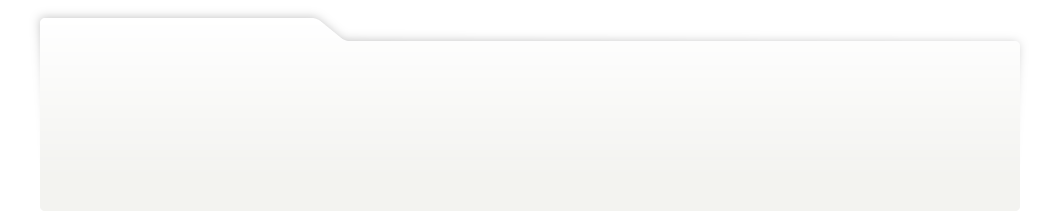
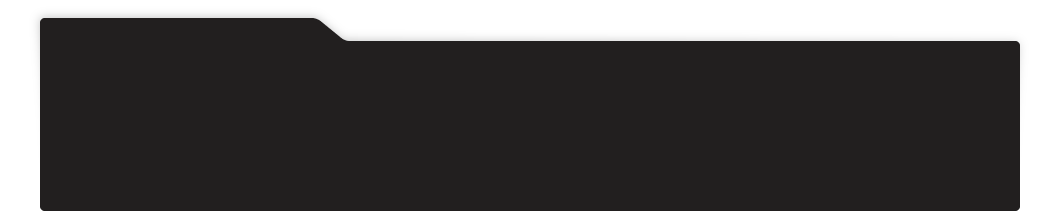
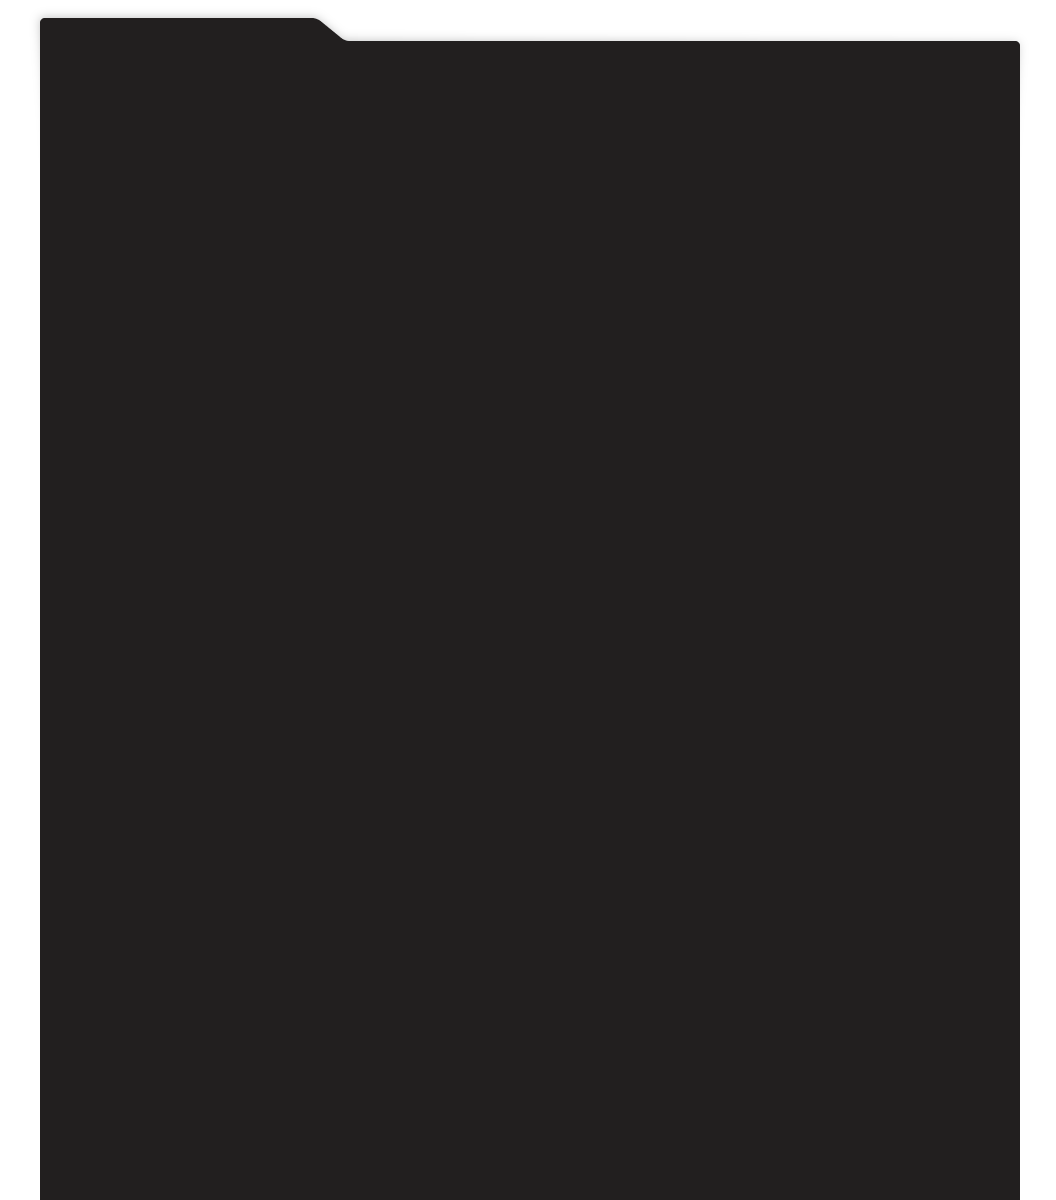
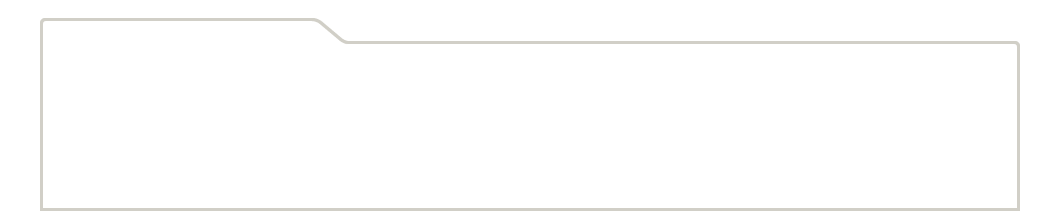
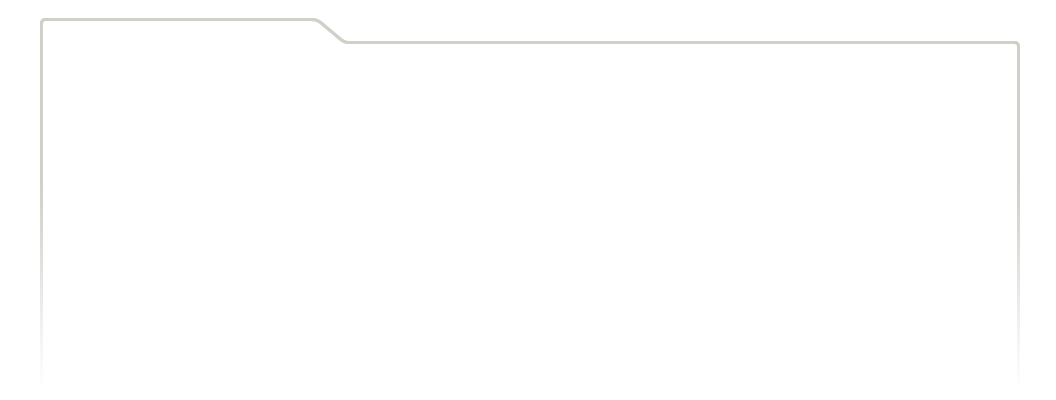
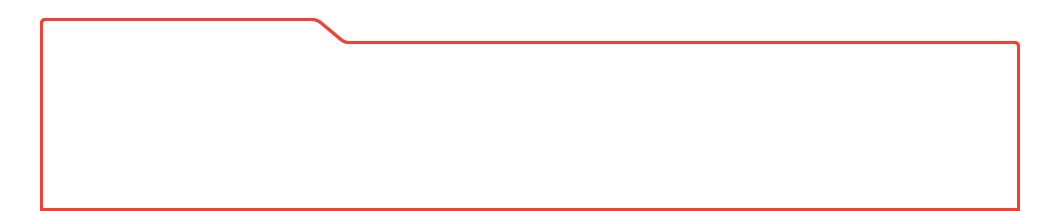
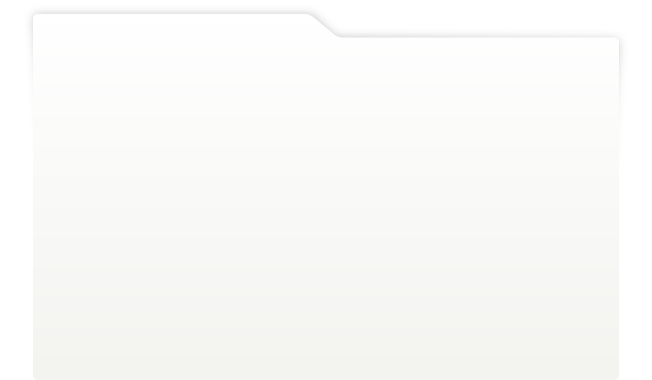
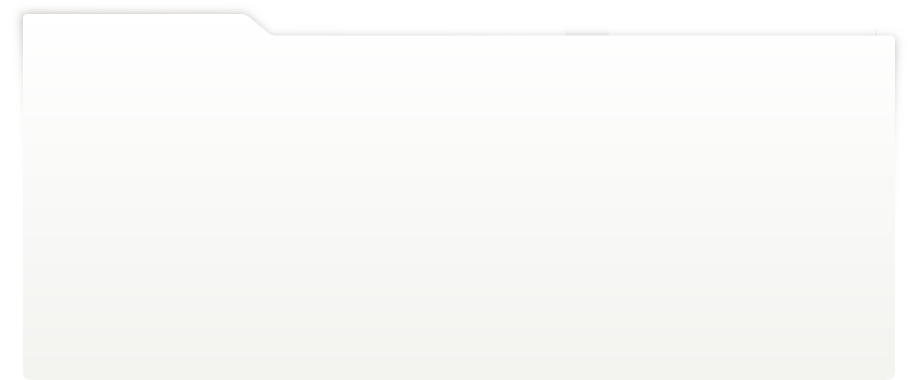
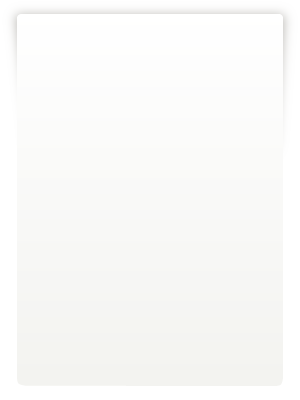
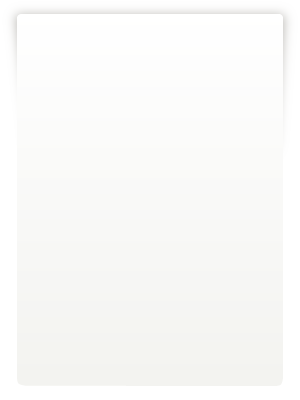
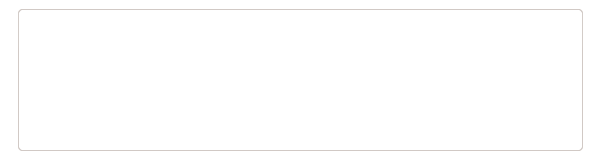
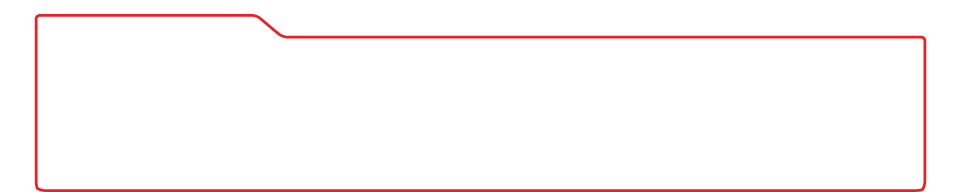
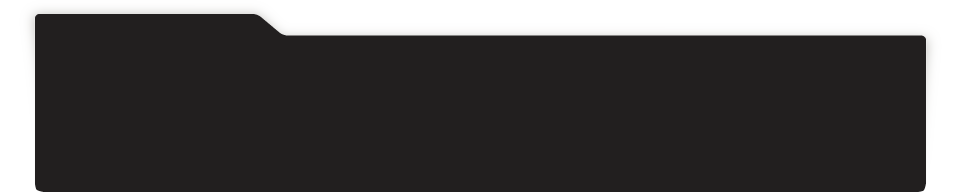
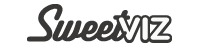
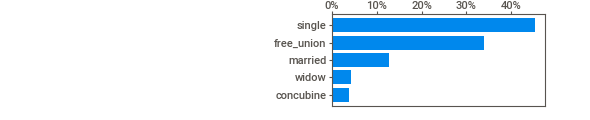
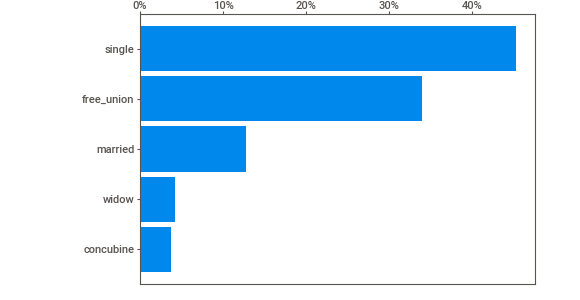
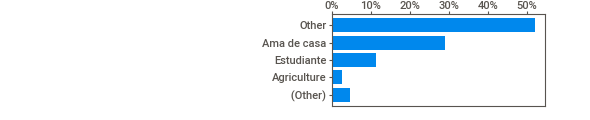
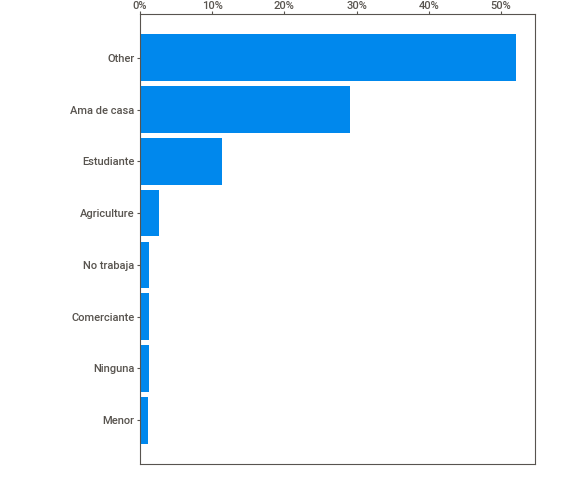
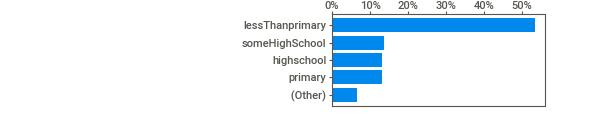
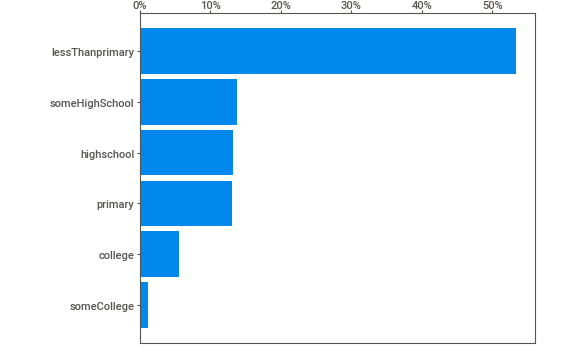
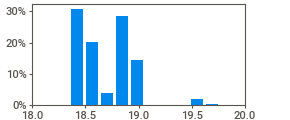
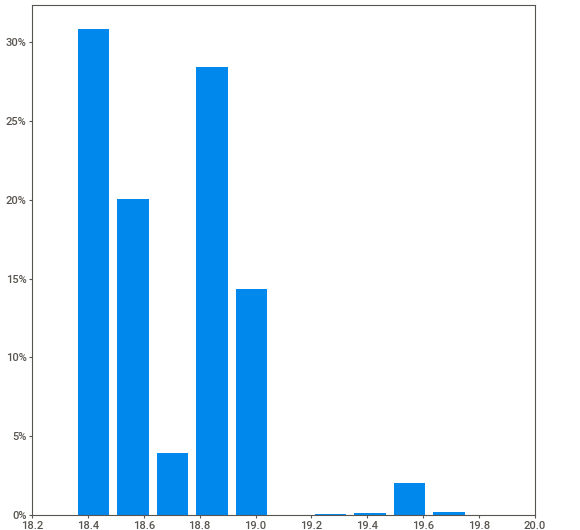
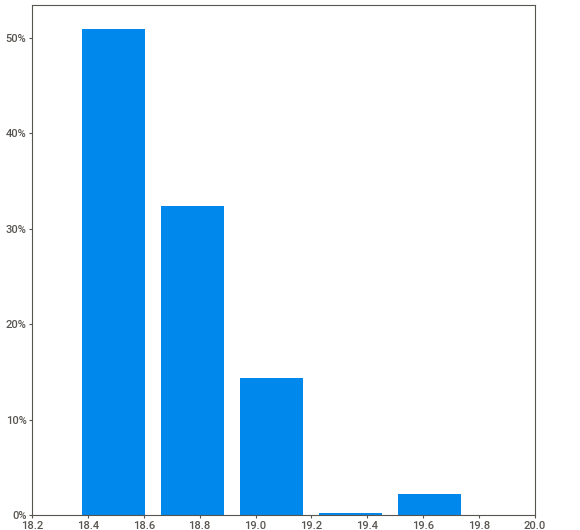
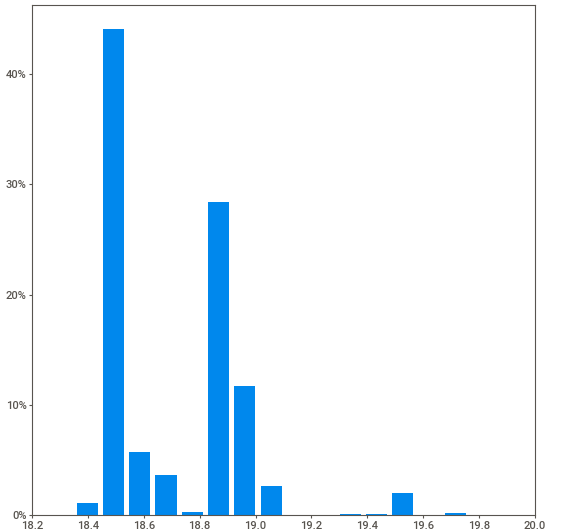
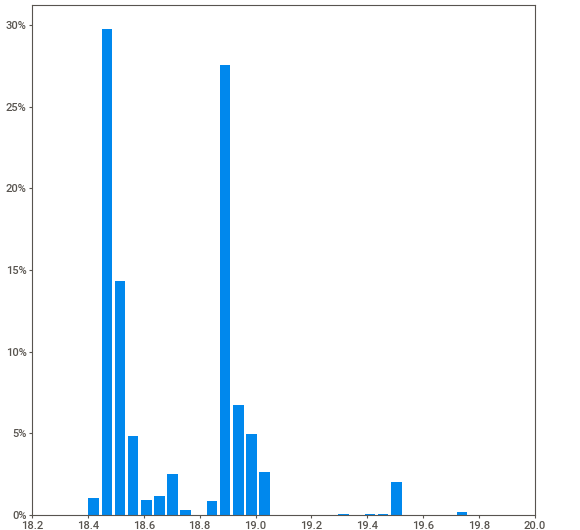
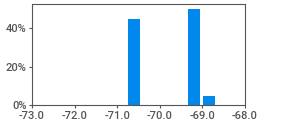
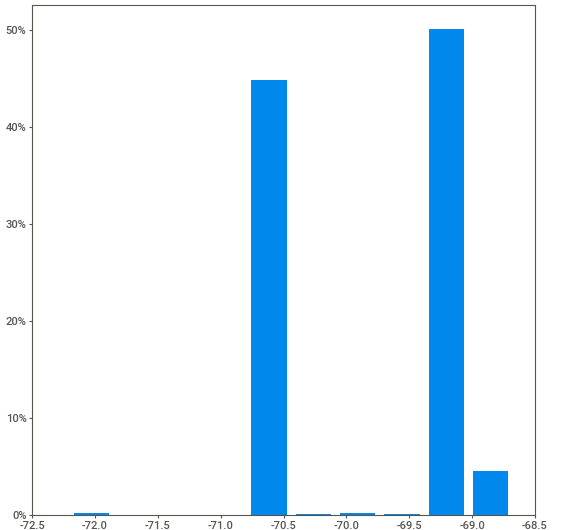
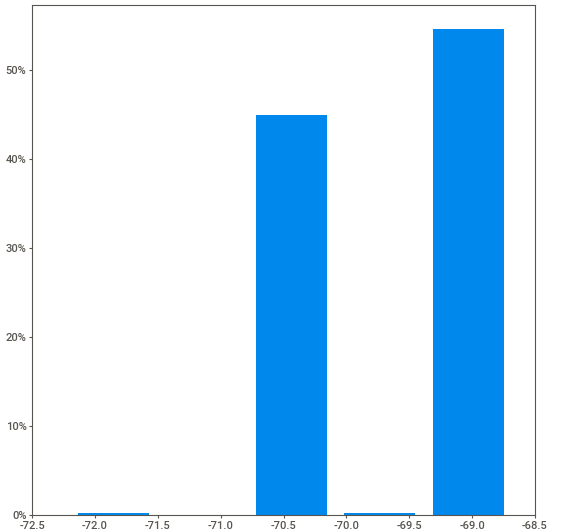
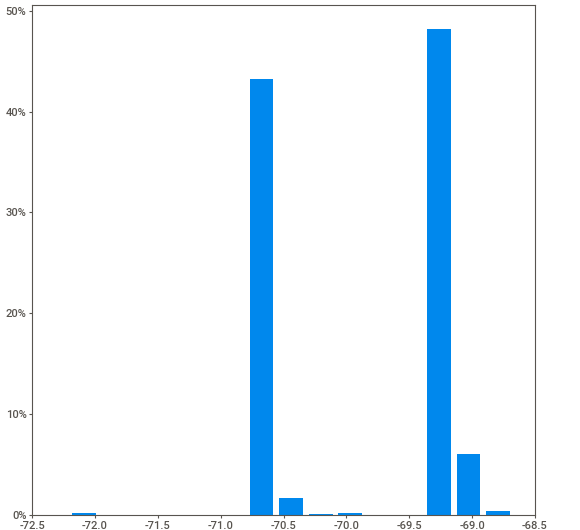
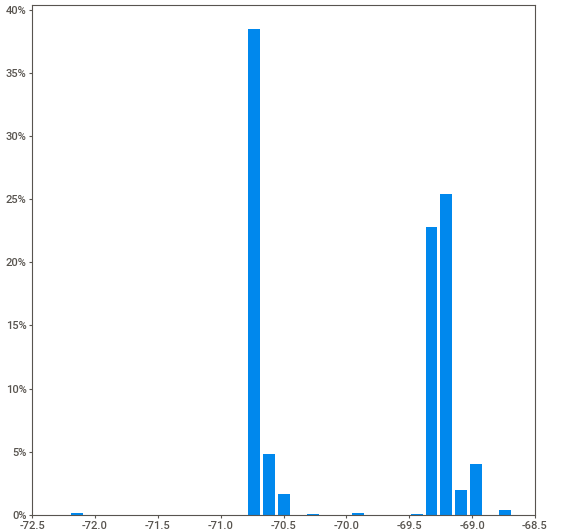
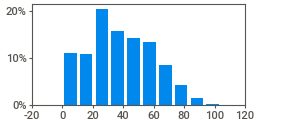
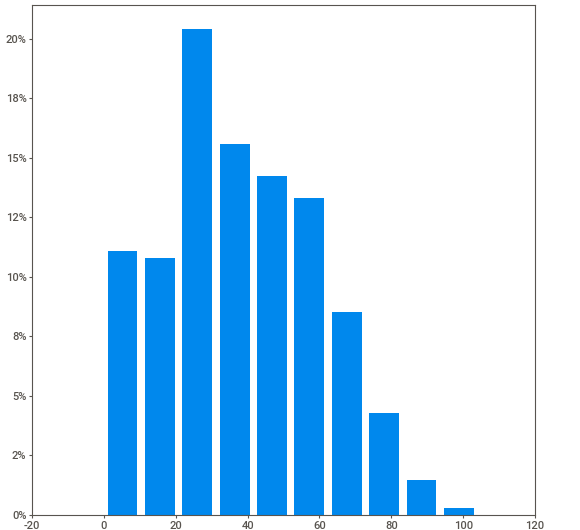
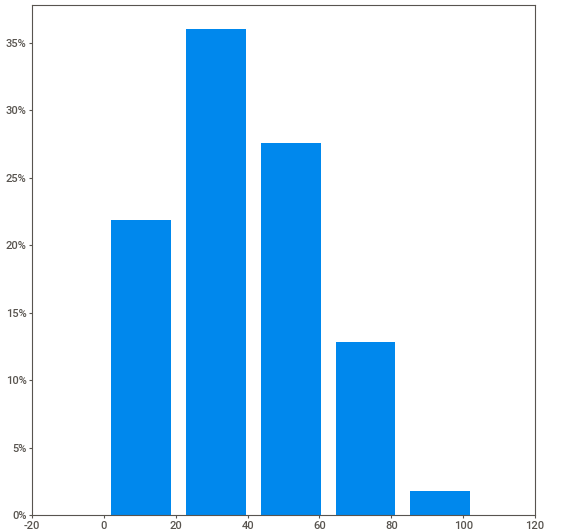
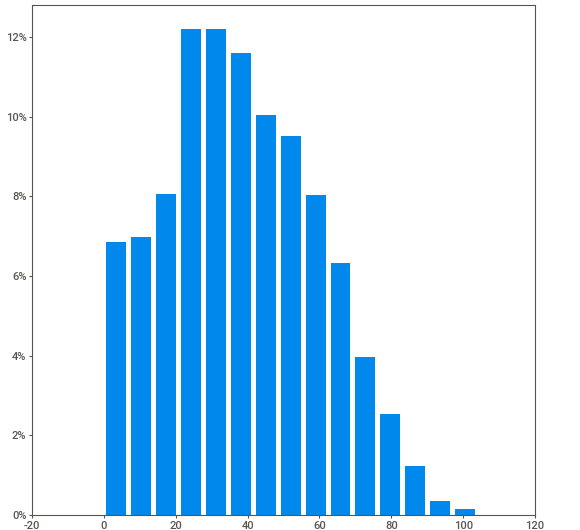
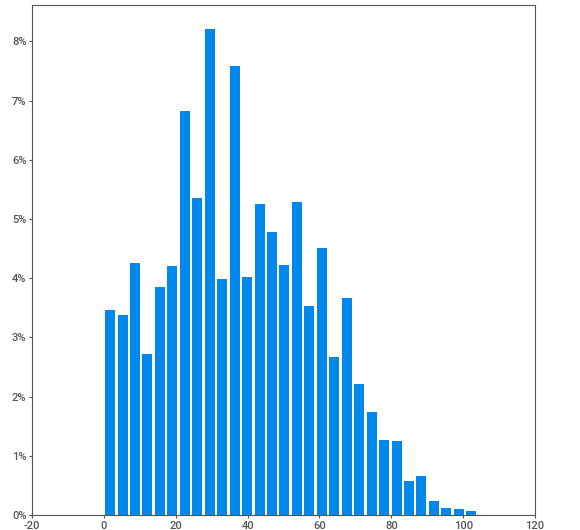
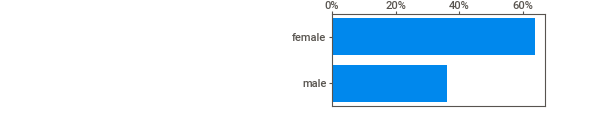
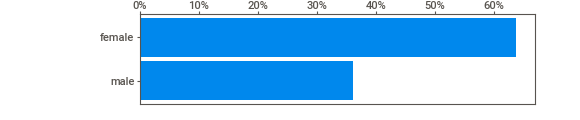
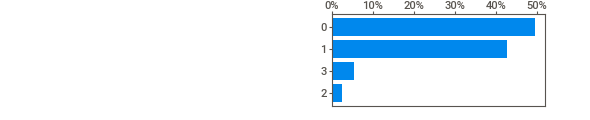
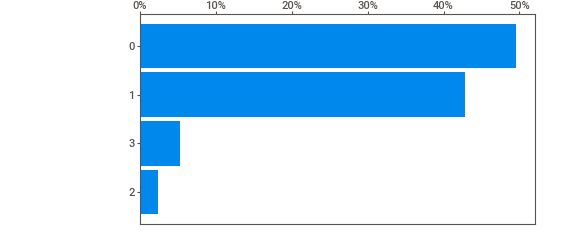
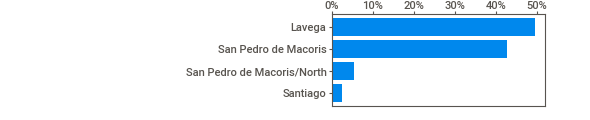
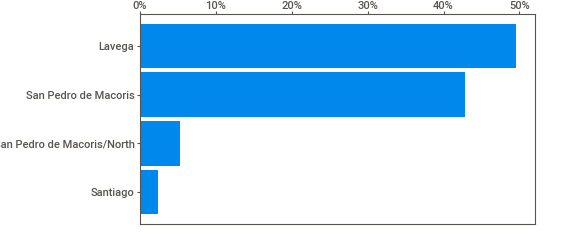
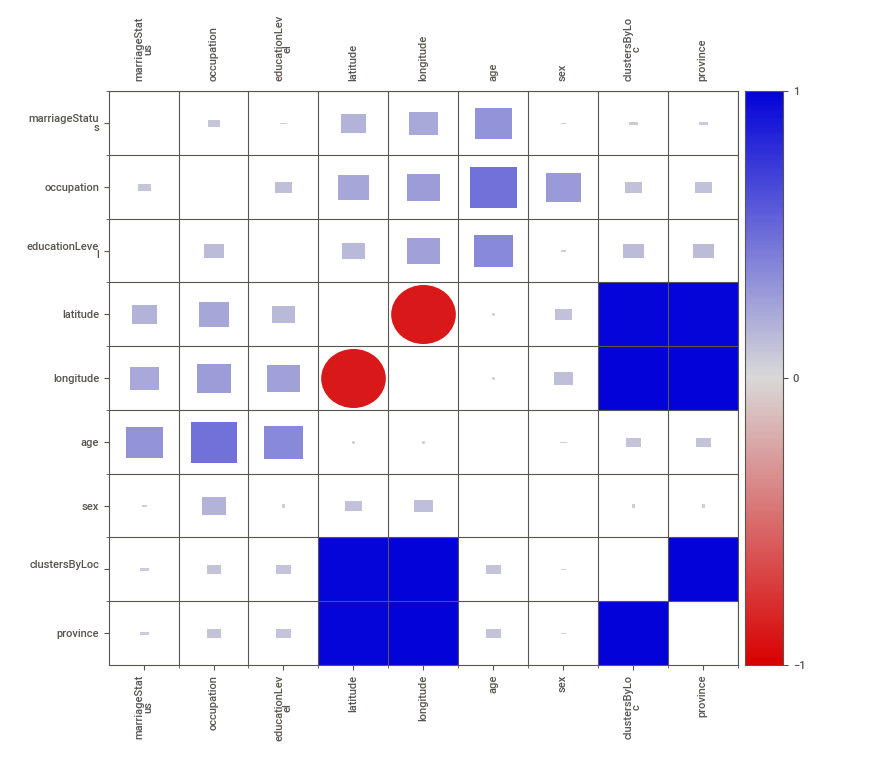
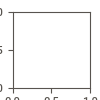

In [37]:
sv_report_survey_vitals = sv.analyze([survey_vitals, "Survey_vitals"])
sv_report_survey_vitals.show_notebook()

### 2. eval_med

In [38]:
eval_med.shape

(8263, 7)

In [39]:
eval_med.isna().sum()

objectId                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    694
part_of_body               1491
trauma_induced              803
condition_progression       825
dtype: int64

In [40]:
values = {"marriageStatus": , "educationLevel": , "age": survey_vitals.age.mean()}

SyntaxError: invalid syntax (<ipython-input-40-497509f2ee8f>, line 1)

                                             |                                             | [  0%]   00:00 ->…


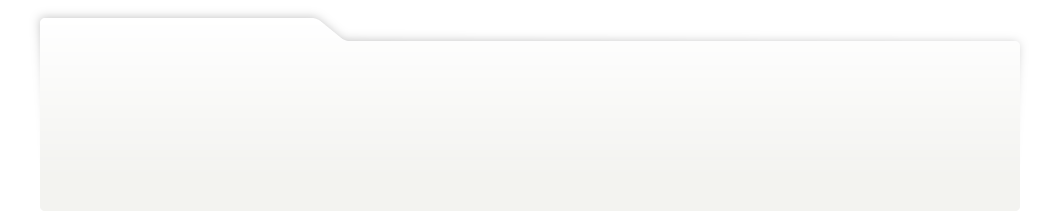
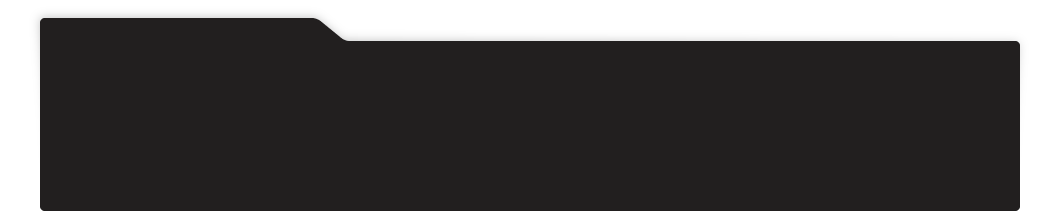
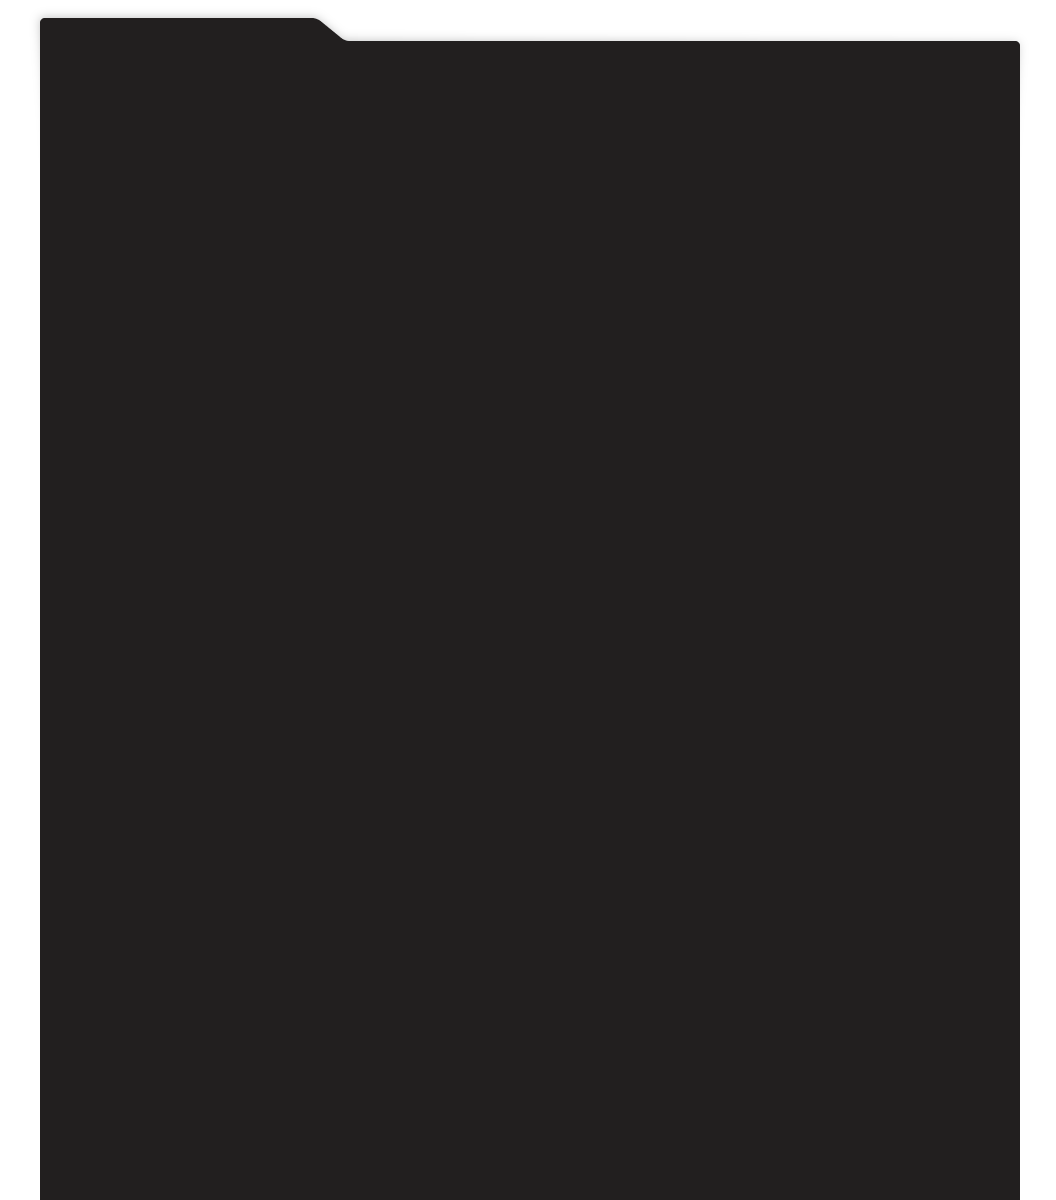
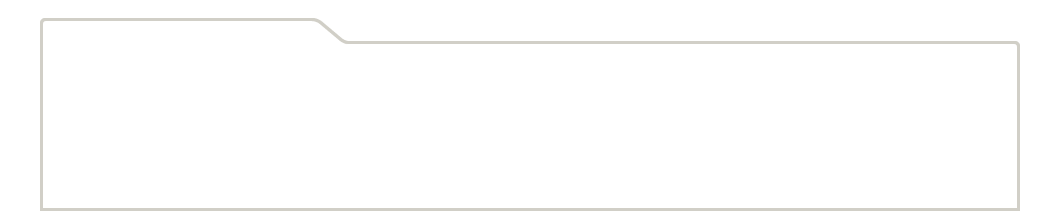
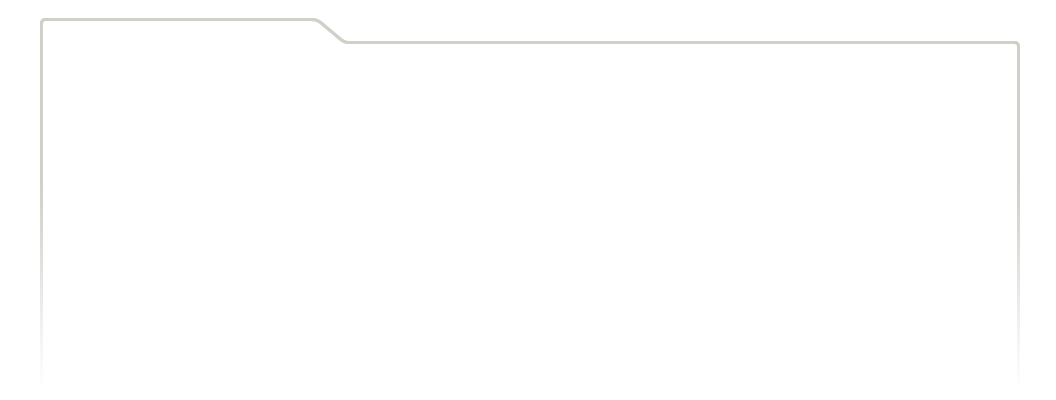
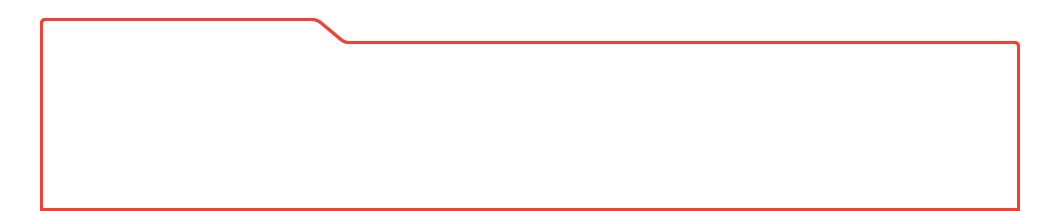
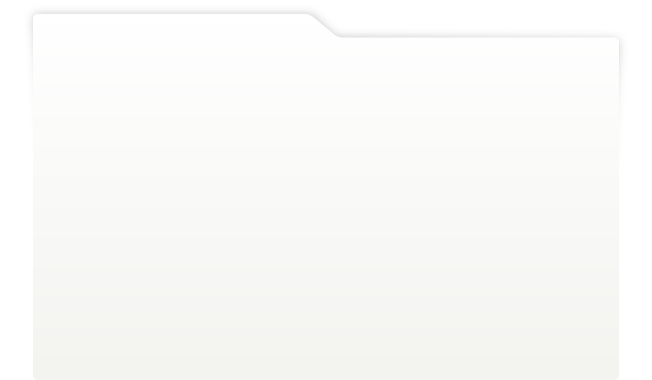
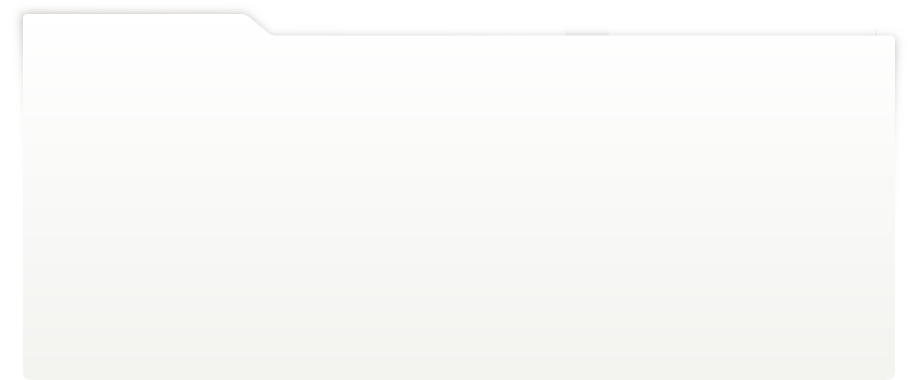
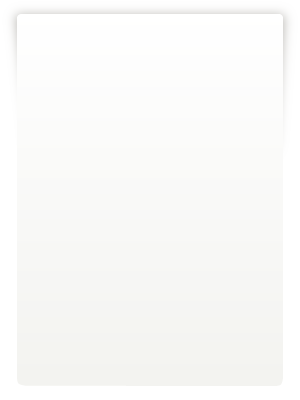
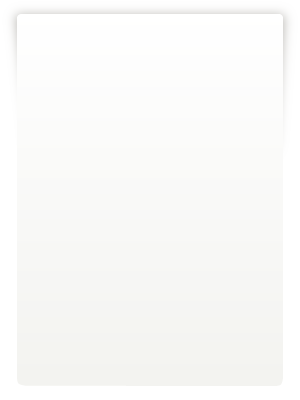
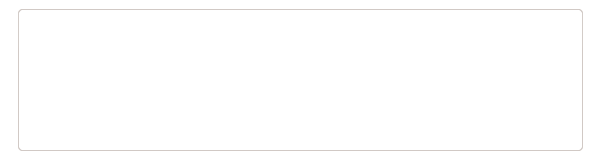
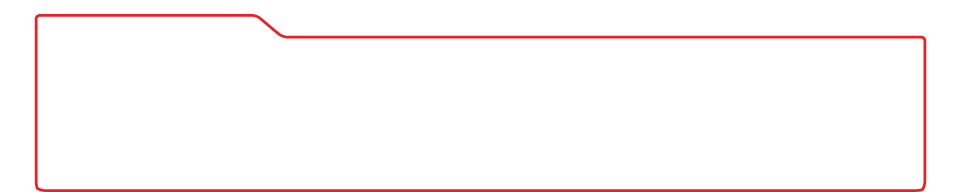
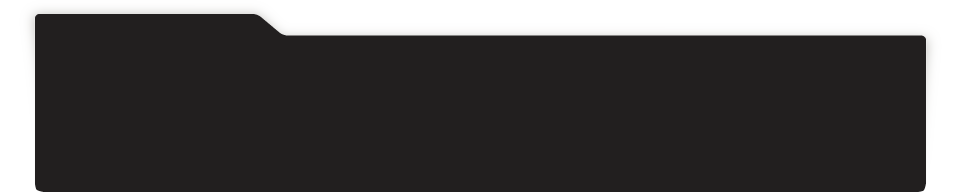
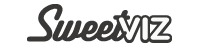
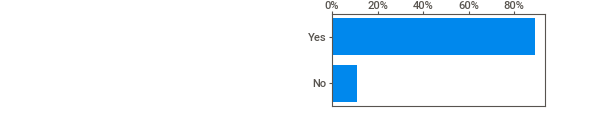
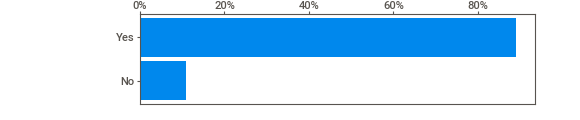
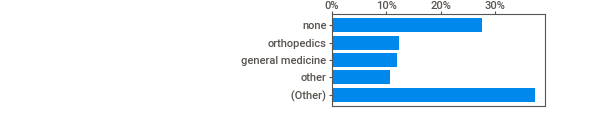
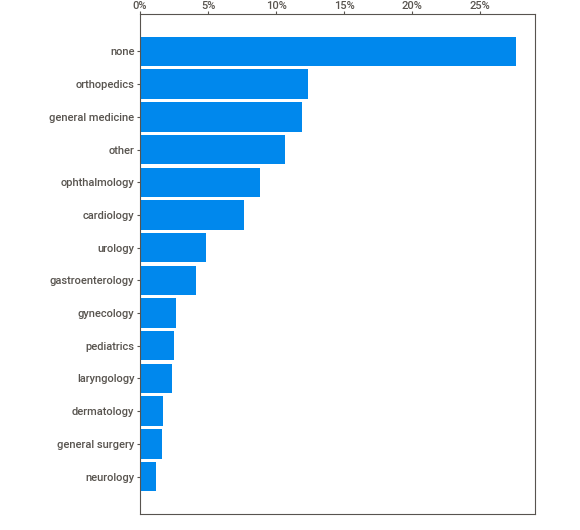
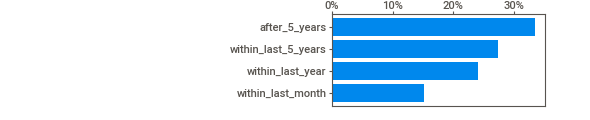
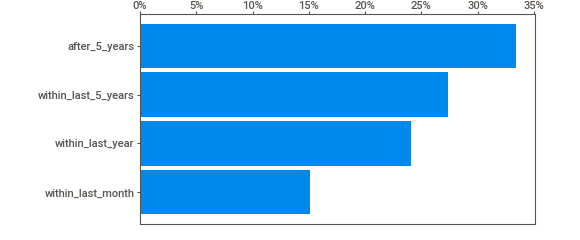
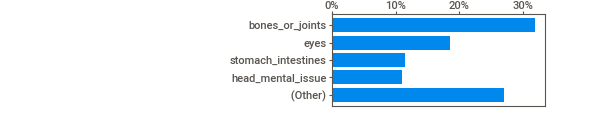
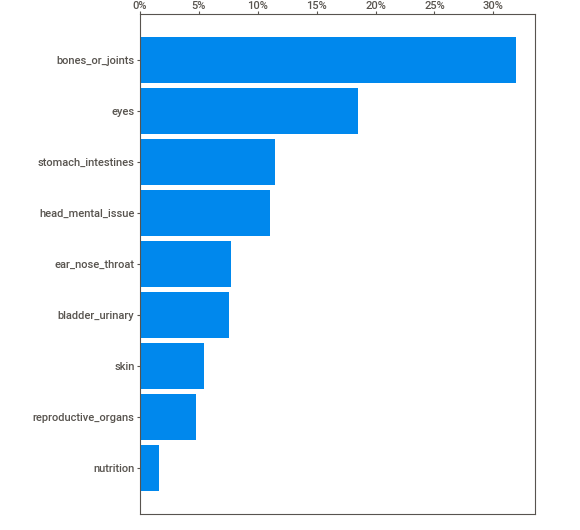
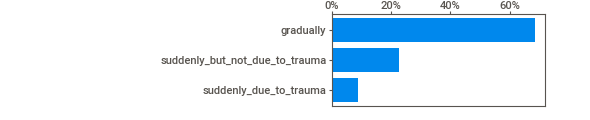
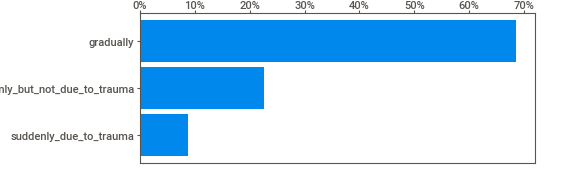
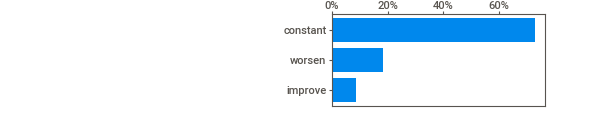
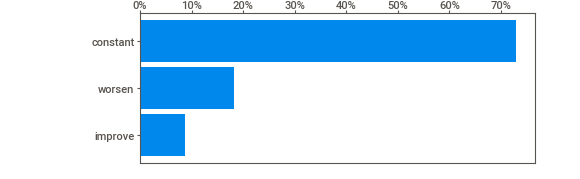
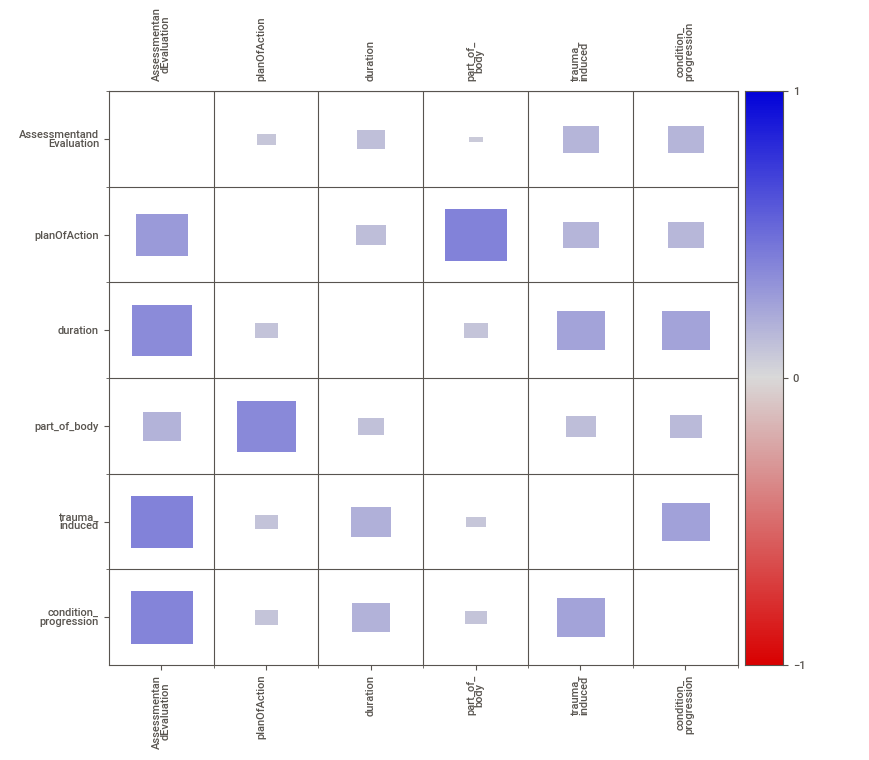
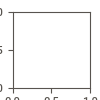

In [41]:
sv_report_eval_med = sv.analyze([eval_med, "Eval_med"])
sv_report_eval_med.show_notebook()

### 3. history_env

In [42]:
history_env.shape

(5472, 16)

In [43]:
history_env["numberofChildrenLivinginHouseUndertheAgeof5"] = history_env["numberofChildrenLivinginHouseUndertheAgeof5"].astype(str)

In [44]:
history_env.dtypes

objectId                                       object
yearsLivedinThisHouse                          object
waterAccess                                    object
typeofWaterdoyoudrink                          object
latrineAccess                                  object
conditionoFloorinyourhouse                     object
conditionoRoofinyourhouse                      object
medicalproblemswheredoyougo                    object
dentalproblemswheredoyougo                     object
biggestproblemofcommunity                      object
timesperweektrashcollected                     object
wheretrashleftbetweenpickups                   object
numberofIndividualsLivingintheHouse             int64
numberofChildrenLivinginHouseUndertheAgeof5    object
houseownership                                 object
bathroomAccess                                 object
dtype: object

In [45]:
history_env.isna().sum()

objectId                                          0
yearsLivedinThisHouse                            28
waterAccess                                     103
typeofWaterdoyoudrink                            54
latrineAccess                                  2228
conditionoFloorinyourhouse                      116
conditionoRoofinyourhouse                       139
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweektrashcollected                        0
wheretrashleftbetweenpickups                      0
numberofIndividualsLivingintheHouse               0
numberofChildrenLivinginHouseUndertheAgeof5       0
houseownership                                  219
bathroomAccess                                 2719
dtype: int64

                                             |                                             | [  0%]   00:00 ->…


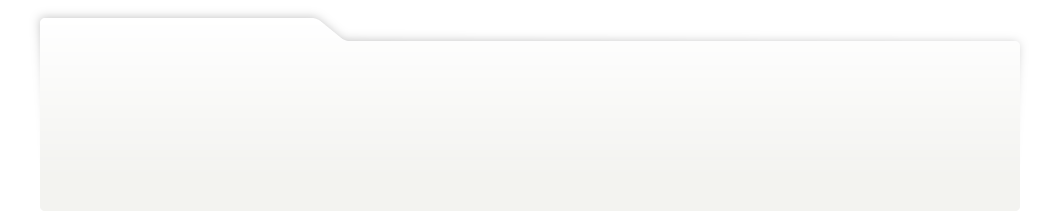
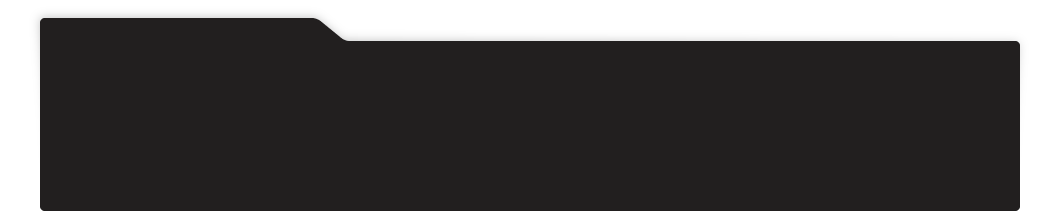
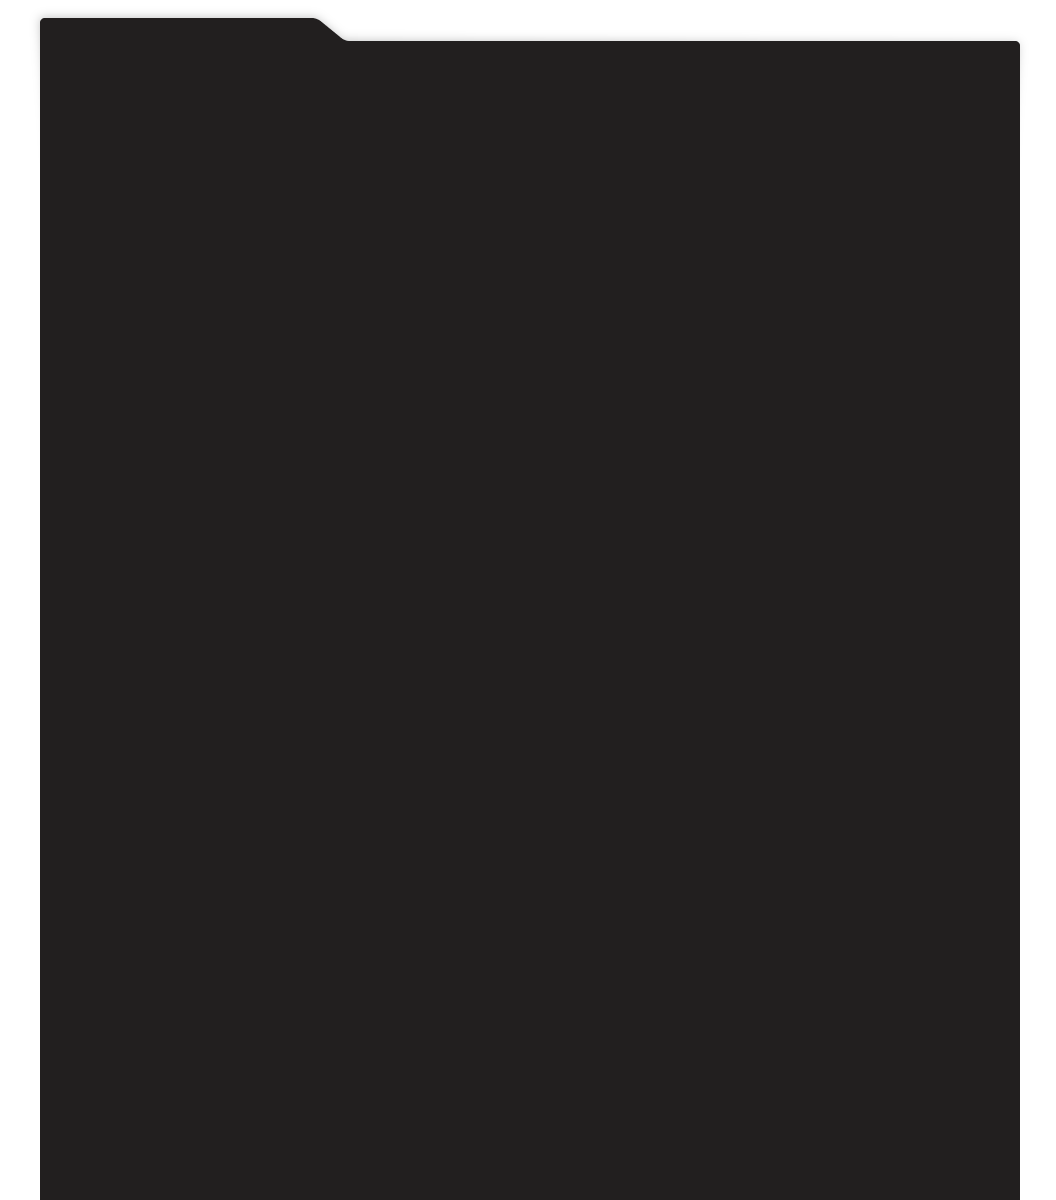
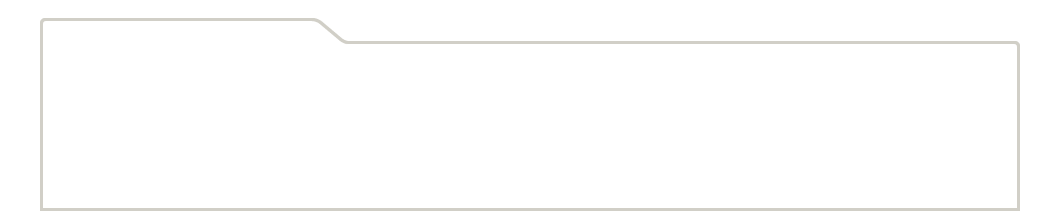
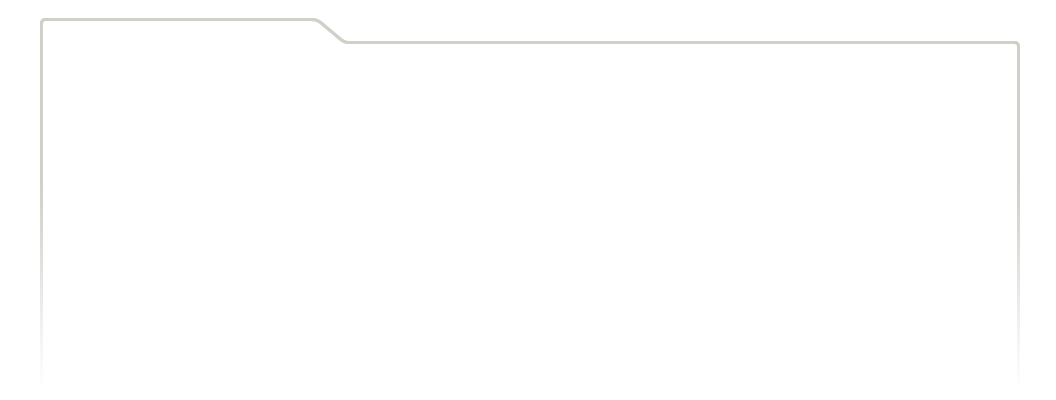
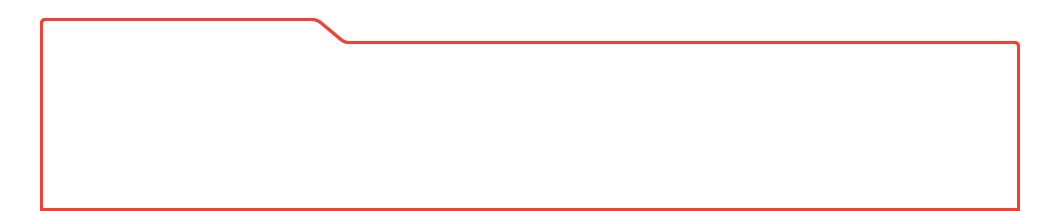
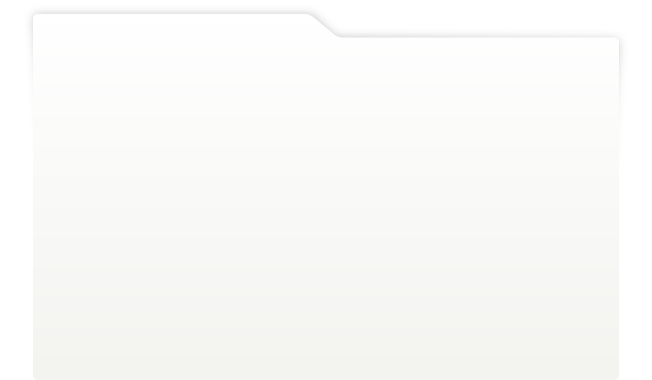
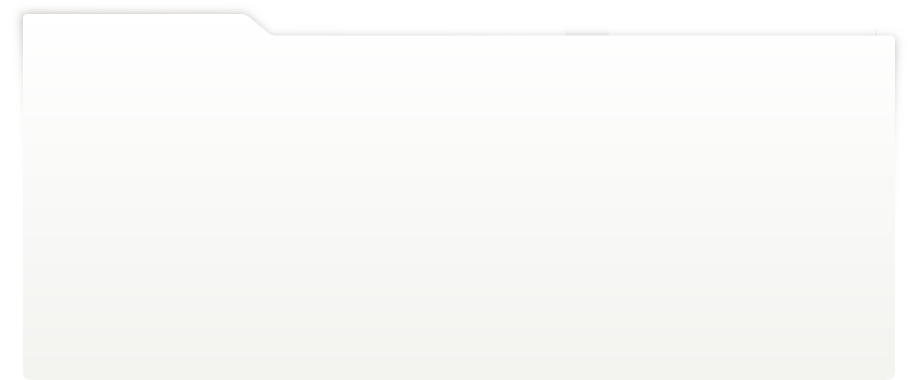
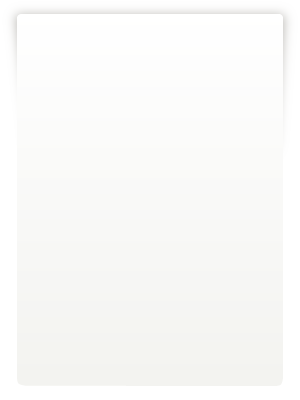
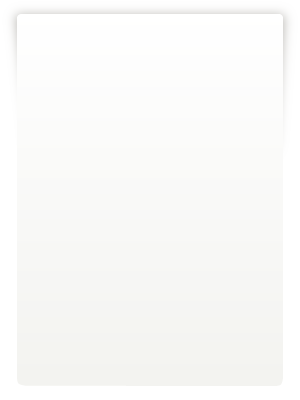
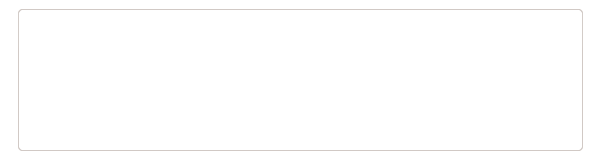
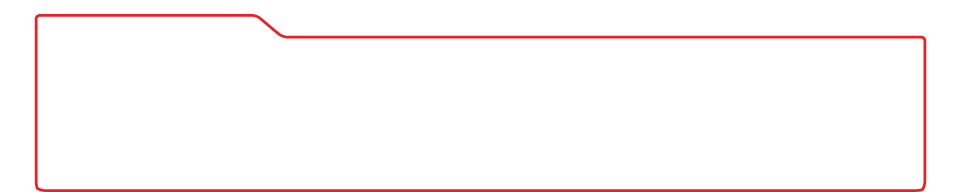
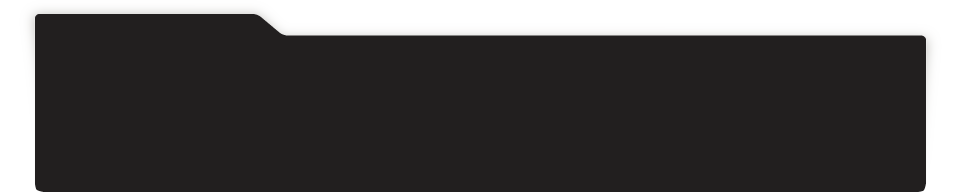
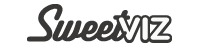
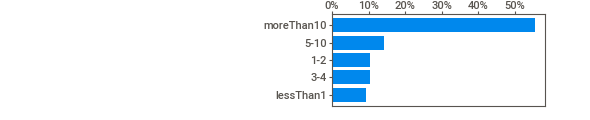
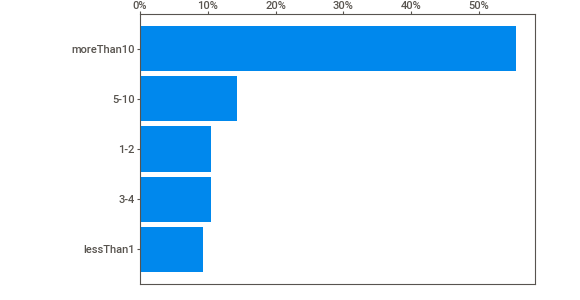
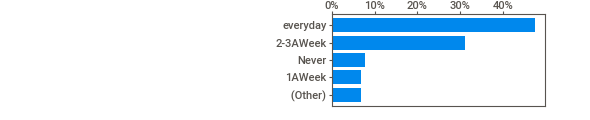
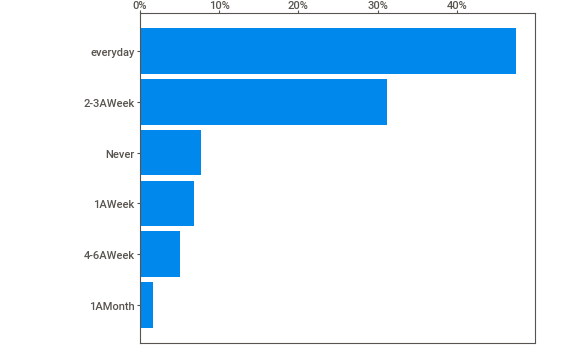
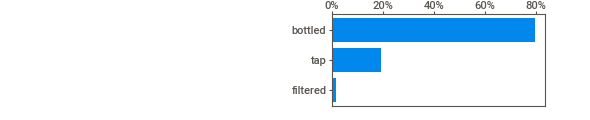
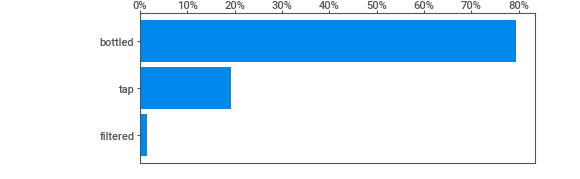
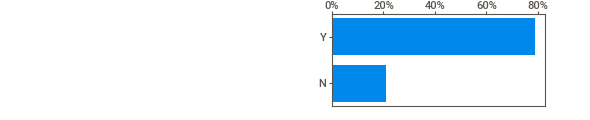
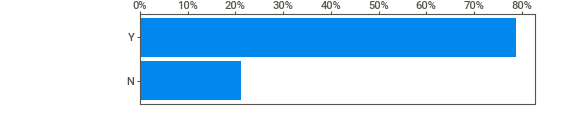
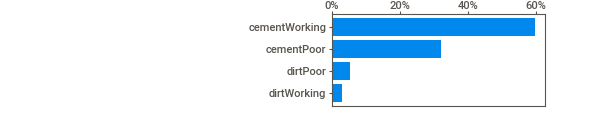
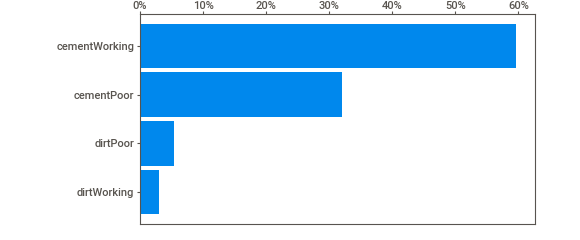
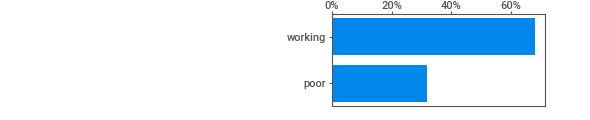
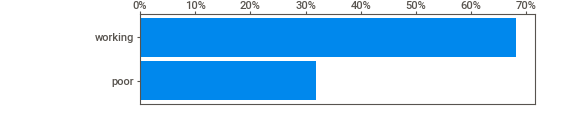
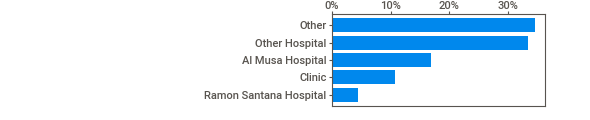
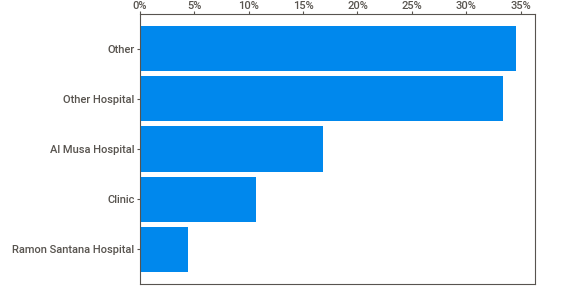
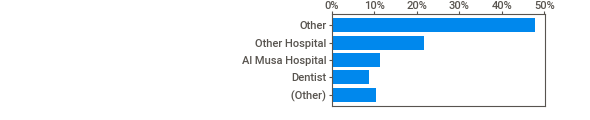
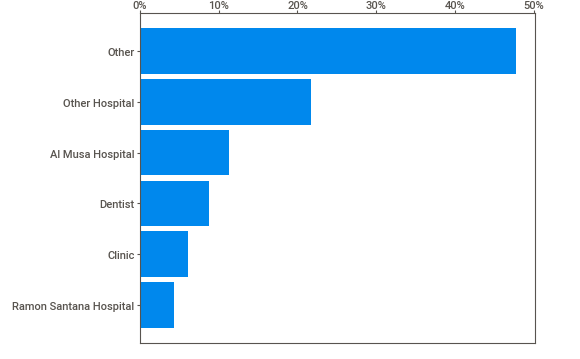
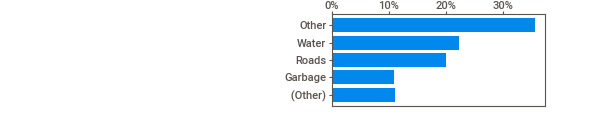
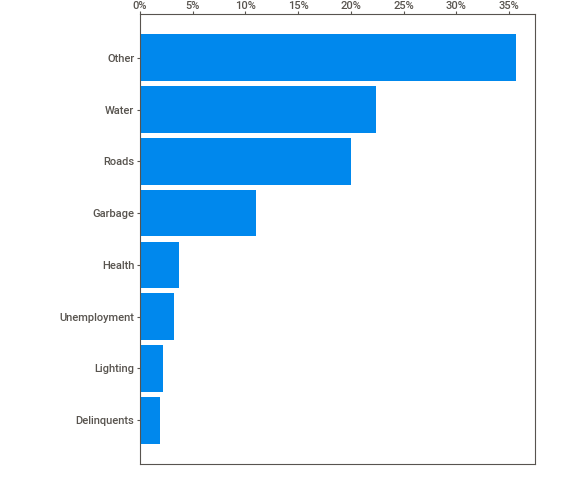
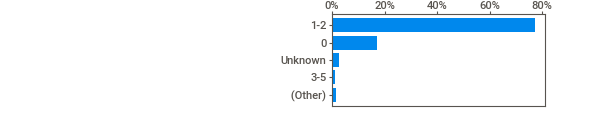
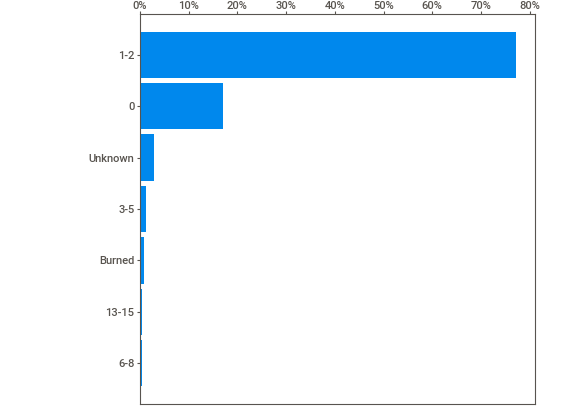
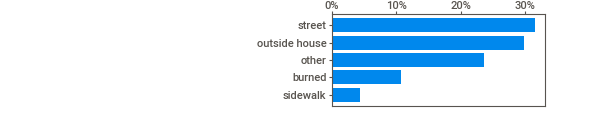
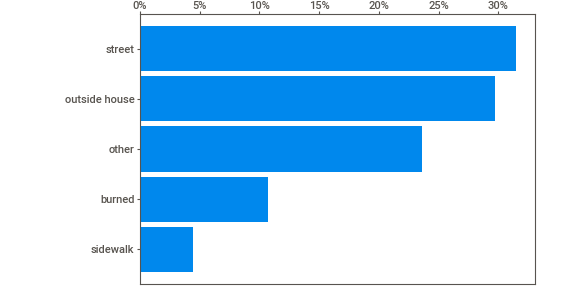
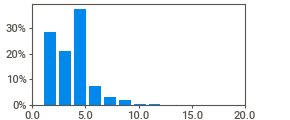
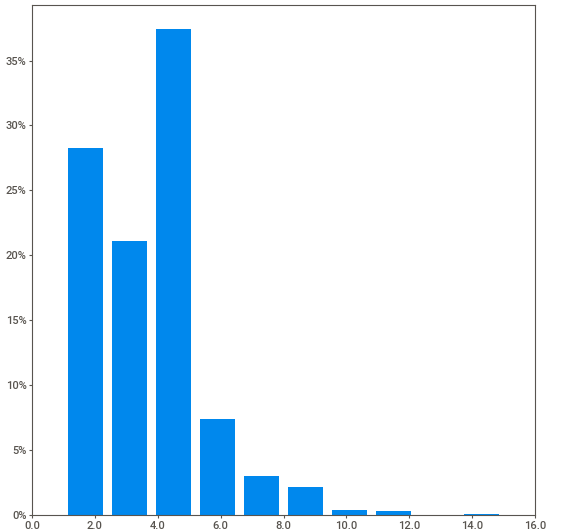
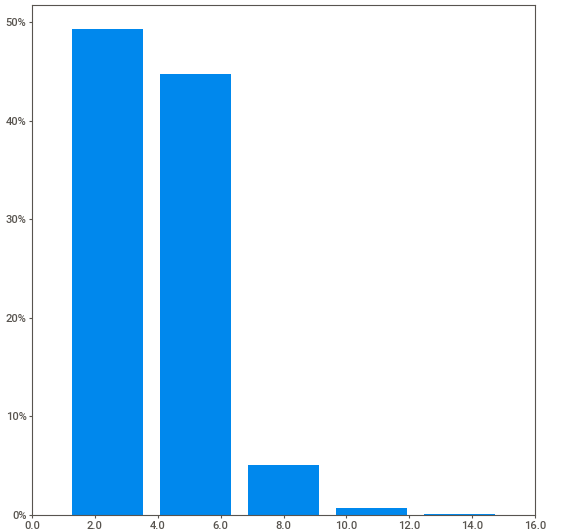
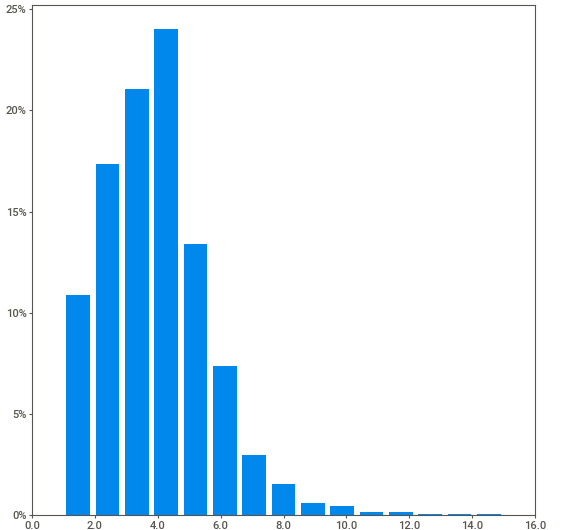
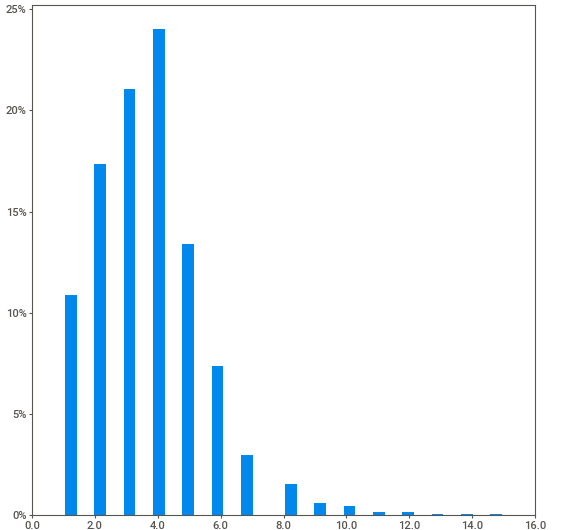
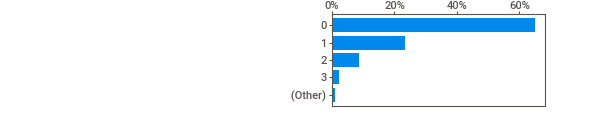
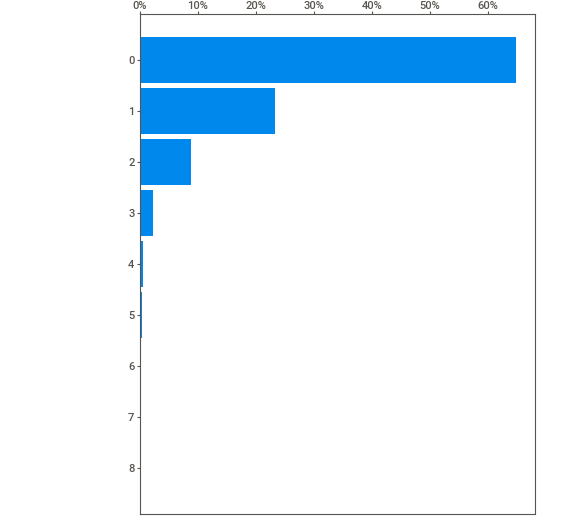
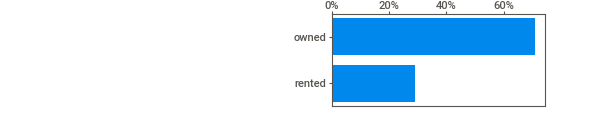
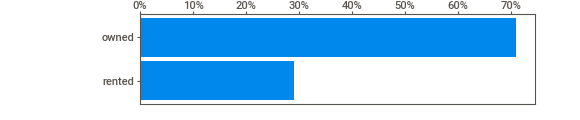
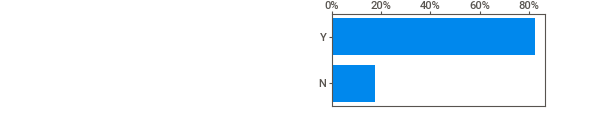
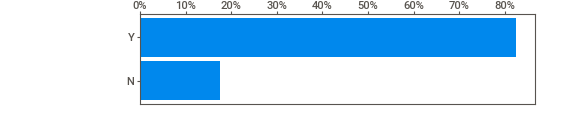
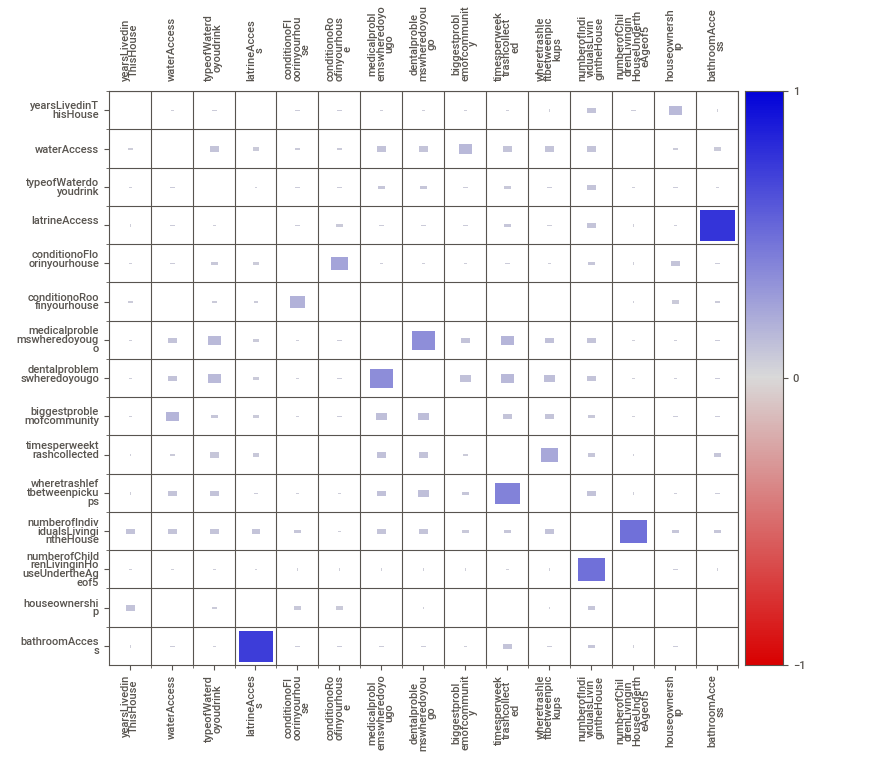
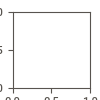

In [46]:
sv_report_history_env = sv.analyze([history_env, "History_env"])
sv_report_history_env.show_notebook()

# Mergings

### 1. History_env x survey_vitals

In [47]:
survey_environ = survey_vitals.merge(history_env, how = "inner", on = "objectId")
survey_environ.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  lLkC5HGPOC          widow  Ama de casa  lessThanprimary  18.914416   
1  gIoG2SAL99          widow        Other  lessThanprimary  18.914196   
2  GiArohoFUo        married        Other          college  18.910474   
3  rnNw8AxEix         single  Ama de casa          primary  18.910484   
4  YBLTPHNqsH      concubine        Other  lessThanprimary  18.915163   

   longitude   age     sex  clustersByLoc              province  ...  \
0 -70.745642  67.0  female              1  San Pedro de Macoris  ...   
1 -70.746286  80.0    male              1  San Pedro de Macoris  ...   
2 -70.747658  41.0  female              1  San Pedro de Macoris  ...   
3 -70.747650  40.0  female              1  San Pedro de Macoris  ...   
4 -70.741626  59.0    male              1  San Pedro de Macoris  ...   

  conditionoRoofinyourhouse medicalproblemswheredoyougo  \
0                   working              Other Hospital   
1                      poor              Other Hospital   
2                       NaN                       Other   
3                   working              Other Hospital   
4                   working                      Clinic   

  dentalproblemswheredoyougo biggestproblemofcommunity  \
0             Other Hospital                     Roads   
1                    Dentist                     Roads   
2                     Clinic                     Other   
3                      Other                     Water   
4                      Other                     Other   

  timesperweektrashcollected wheretrashleftbetweenpickups  \
0                        1-2                        other   
1                        1-2                        other   
2                        3-5                        other   
3                        1-2                        other   
4                        1-2                       street   

  numberofIndividualsLivingintheHouse  \
0                                   1   
1                                   5   
2                                   4   
3                                   4   
4                                   4   

  numberofChildrenLivinginHouseUndertheAgeof5 houseownership bathroomAccess  
0                                           0         rented            NaN  
1                                           0          owned            NaN  
2                                           0            NaN            NaN  
3                                           0            NaN            NaN  
4                                           0            NaN            NaN  

[5 rows x 25 columns]

ConversionError: Failed to convert value(s) to axis units: 0       2-3AWeek
1         1AWeek
2       2-3AWeek
3       4-6AWeek
4       2-3AWeek
          ...   
5418       Never
5419       Never
5420       Never
5421       Never
5422       Never
Name: x, Length: 5423, dtype: object

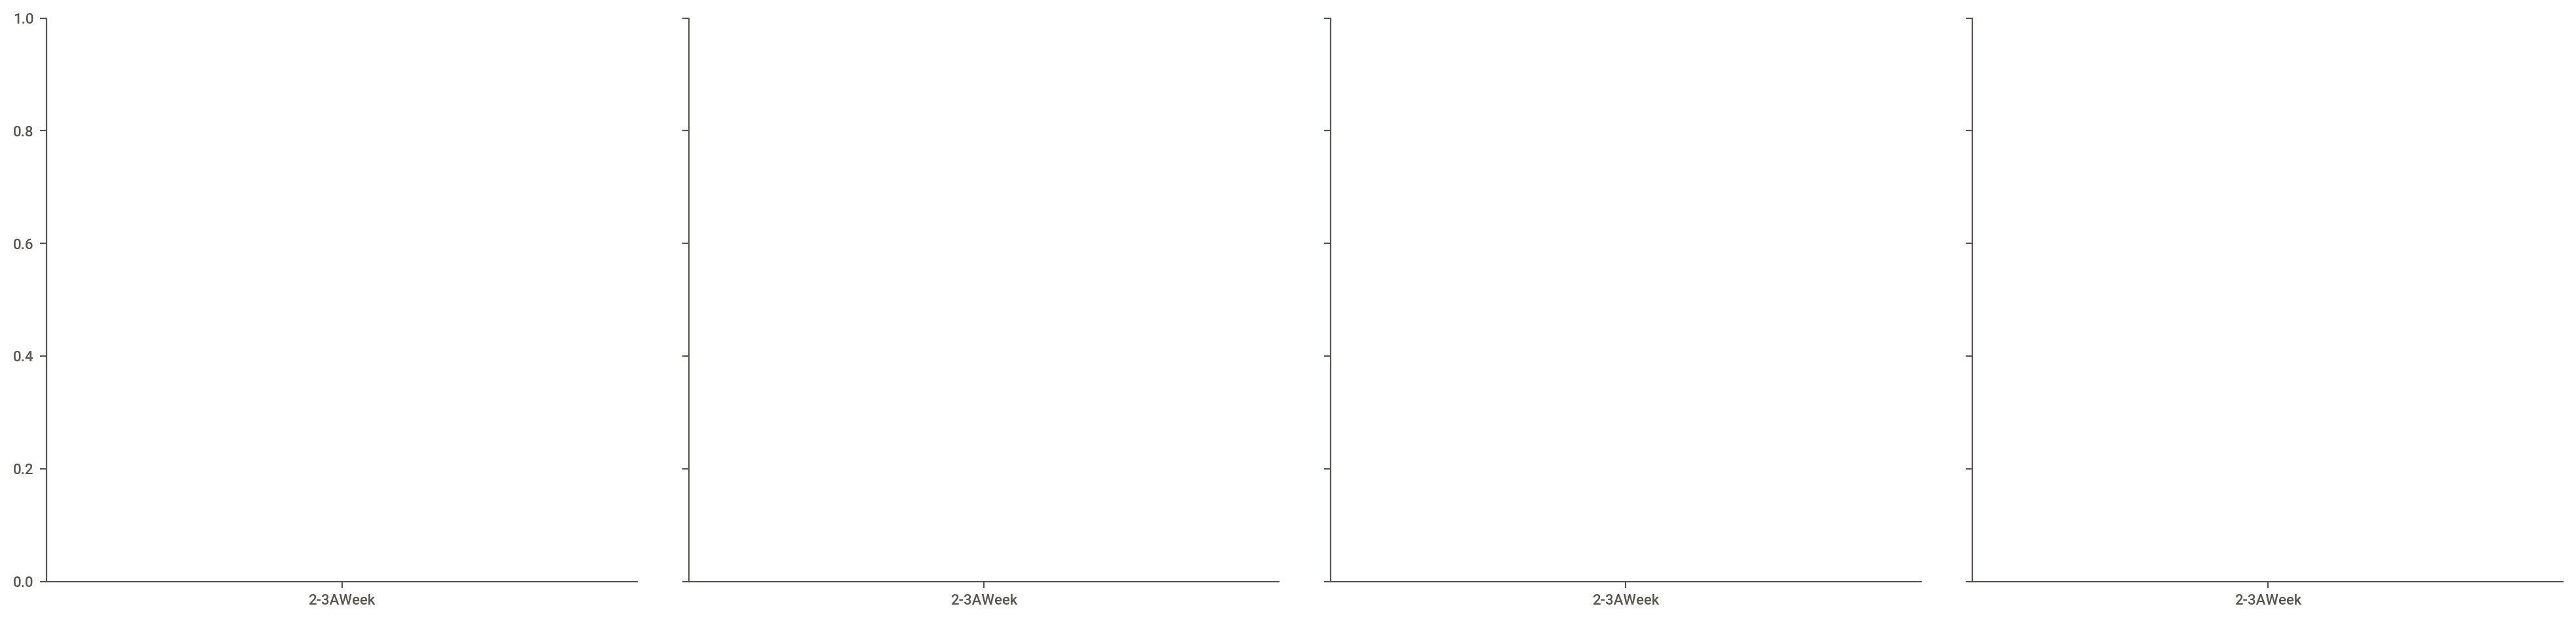

In [48]:
sns.displot(survey_environ, x="waterAccess", col="province", hue = "waterAccess", multiple="dodge")

In [ ]:
survey_environ.shape

In [49]:
survey_environ.isna().sum()

objectId                                          0
marriageStatus                                    0
occupation                                        0
educationLevel                                  206
latitude                                          0
longitude                                         0
age                                               0
sex                                               0
clustersByLoc                                     0
province                                          0
yearsLivedinThisHouse                            17
waterAccess                                      84
typeofWaterdoyoudrink                            40
latrineAccess                                  2208
conditionoFloorinyourhouse                       98
conditionoRoofinyourhouse                       119
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweek

In [50]:
survey_environ.province.value_counts()

San Pedro de Macoris          2623
Lavega                        2555
Santiago                       211
San Pedro de Macoris/North      34
Name: province, dtype: int64

In [51]:
province_waterAccess_percent = pd.crosstab(index = survey_environ["waterAccess"], columns = survey_environ["province"])#.apply(lambda r: r/r.sum(), axis=0)
province_waterAccess_percent

province     Lavega  San Pedro de Macoris  San Pedro de Macoris/North  \
waterAccess                                                             
1AMonth          21                    66                           0   
1AWeek           51                   314                           0   
2-3AWeek        594                  1062                           1   
4-6AWeek         55                   202                           7   
Never           114                   128                           3   
everyday       1702                   788                          21   

province     Santiago  
waterAccess            
1AMonth             1  
1AWeek              3  
2-3AWeek           16  
4-6AWeek            2  
Never             168  
everyday           20

In [52]:
def by_province(df, feature):
    res_df = pd.crosstab(index = df[feature], columns = df["province"]).reset_index()
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    fig.set_size_inches(20,20)
    ax1 = sns.barplot(x = feature, y = "Lavega", data = res_df, ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax1.set_title("Distribution of " + feature + " Types in Lavega")
    ax1.set_ylabel("Count")
    
    ax2 = sns.barplot(x = feature, y = "Santiago", data = res_df, ax = ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax2.set_title("Distribution of " + feature + " Types in Santiago")    
    ax2.set_ylabel("Count")
    
    ax3 = sns.barplot(x = feature, y = "San Pedro de Macoris", data = res_df, ax = ax3)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax3.set_title("Distribution of " + feature + " Types in San Pedro de Macoris")      
    ax3.set_ylabel("Count")
    
    ax4 = sns.barplot(x = feature, y = "San Pedro de Macoris/North", data = res_df, ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax4.set_title("Distribution of " + feature + " Types in San Pedro de Macoris/North")
    ax4.set_ylabel("Count")

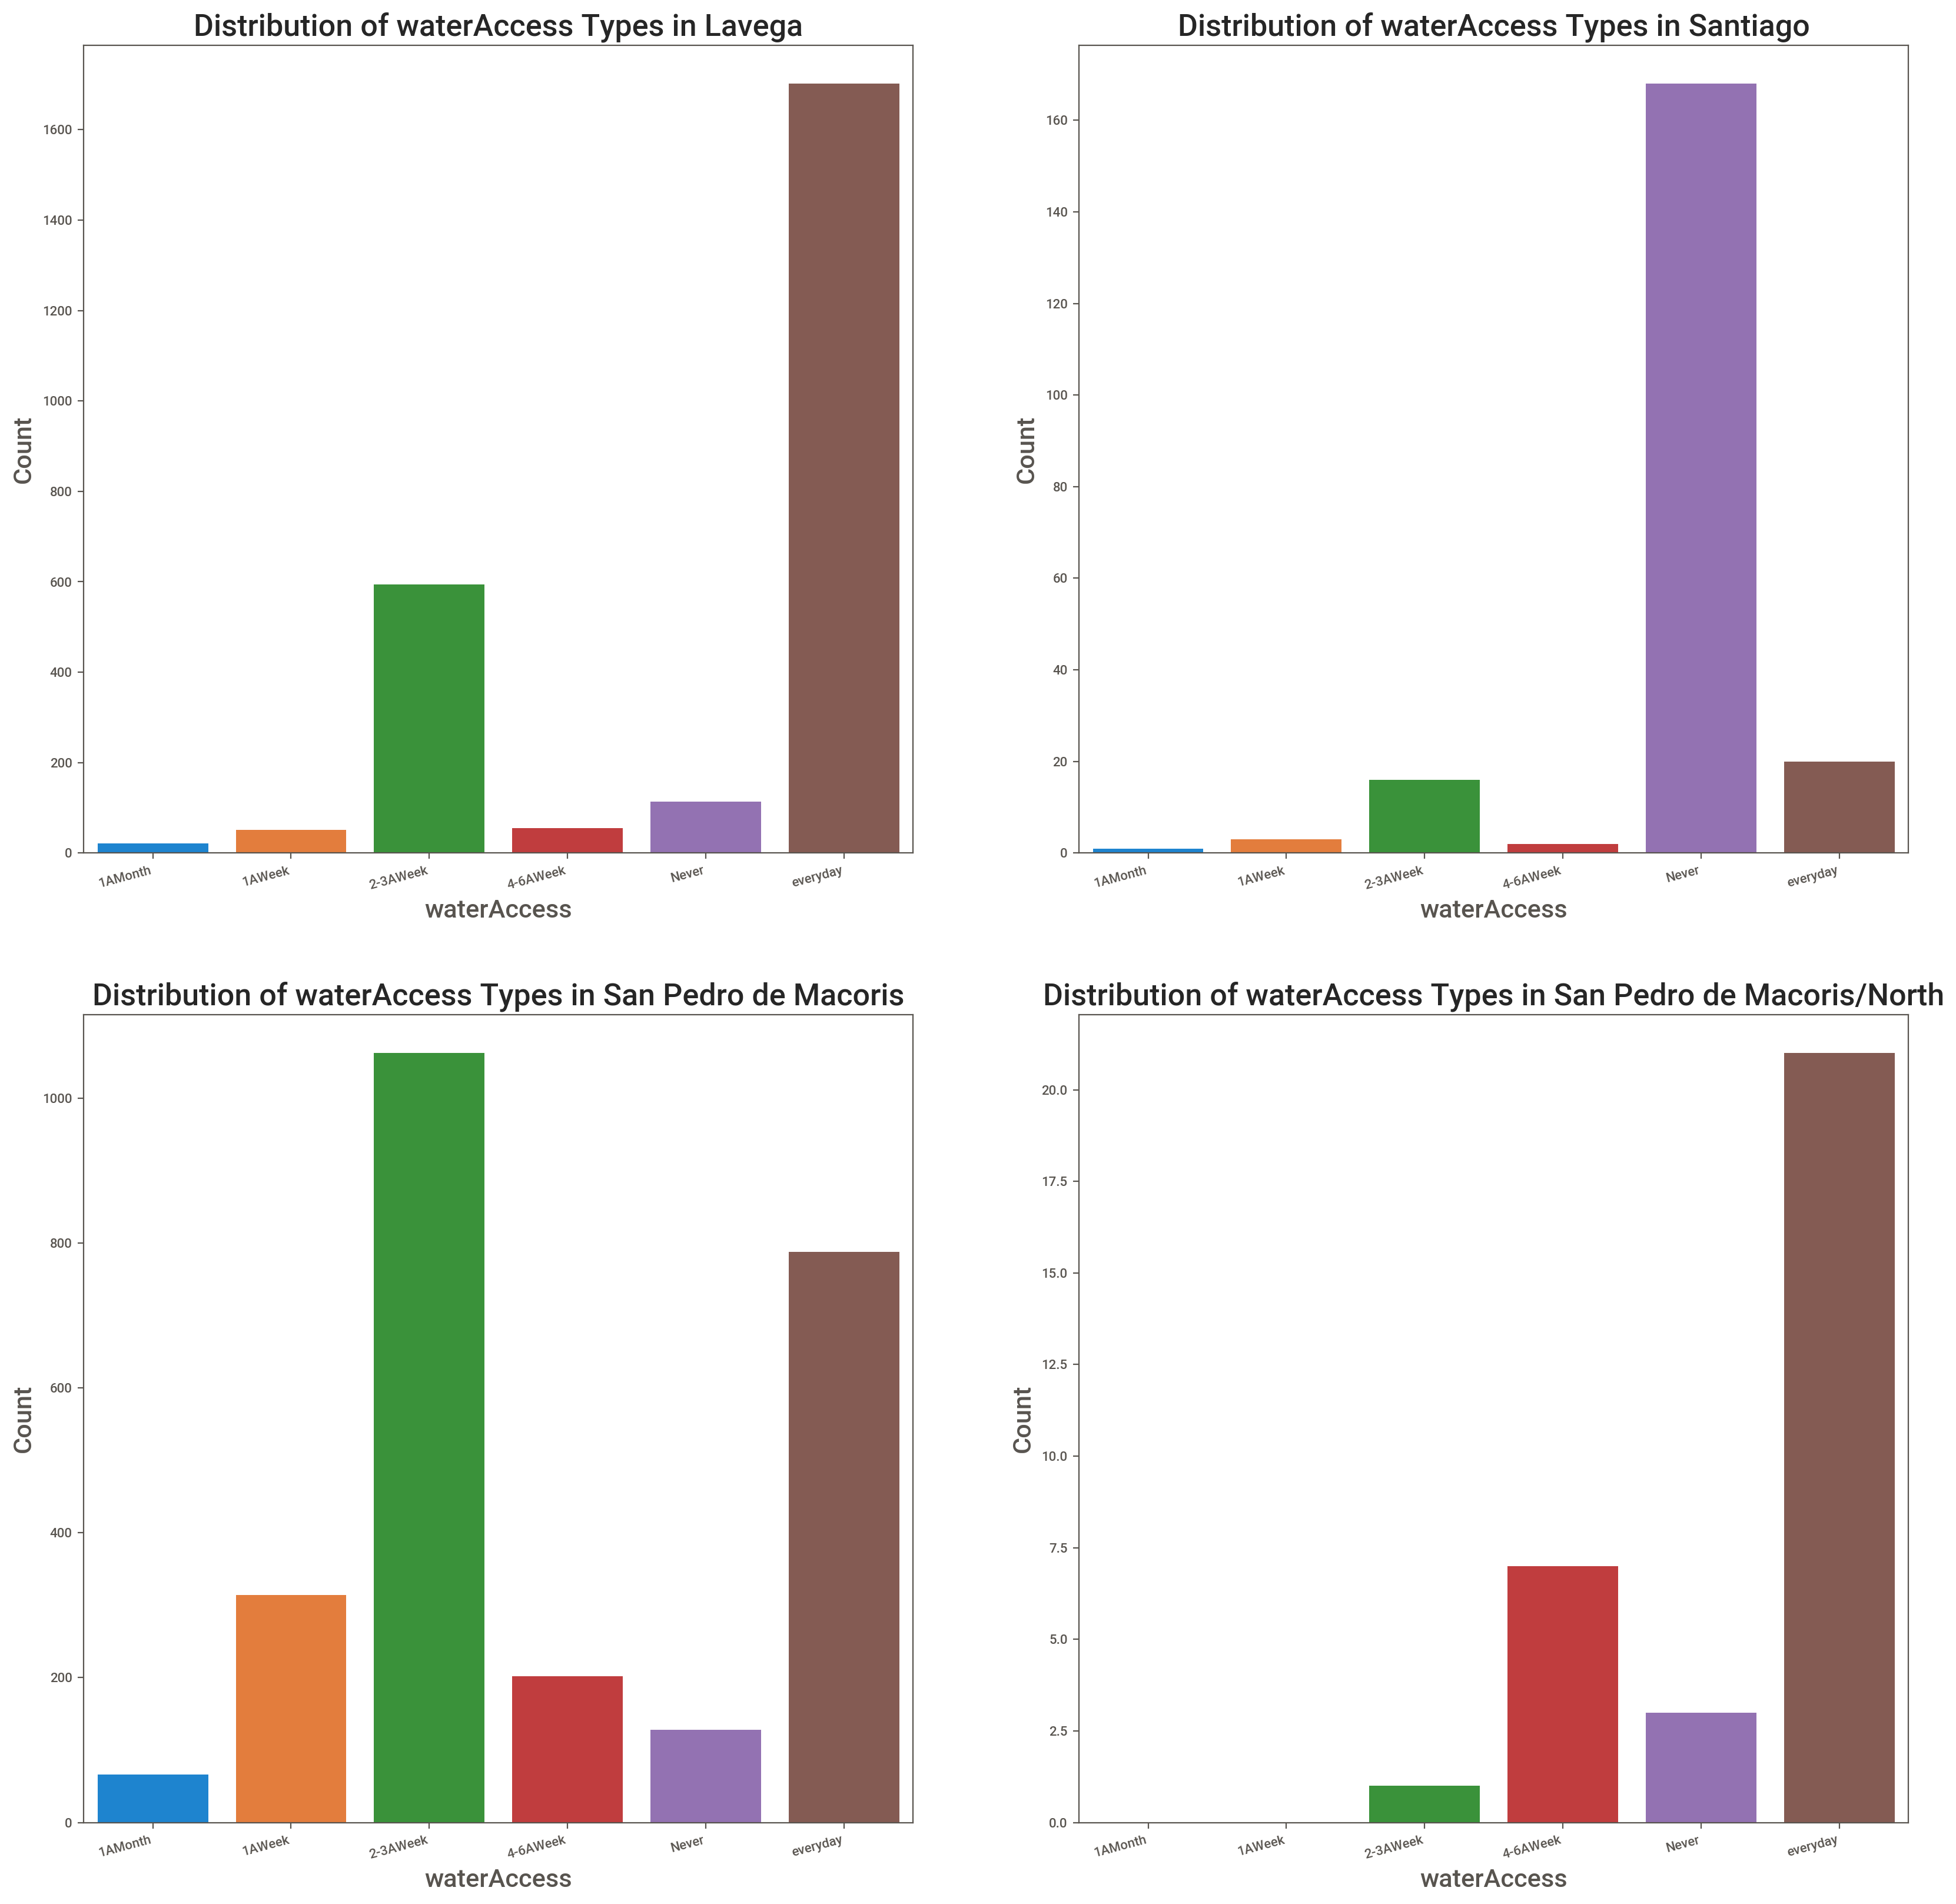

In [53]:
by_province(survey_environ, "waterAccess")

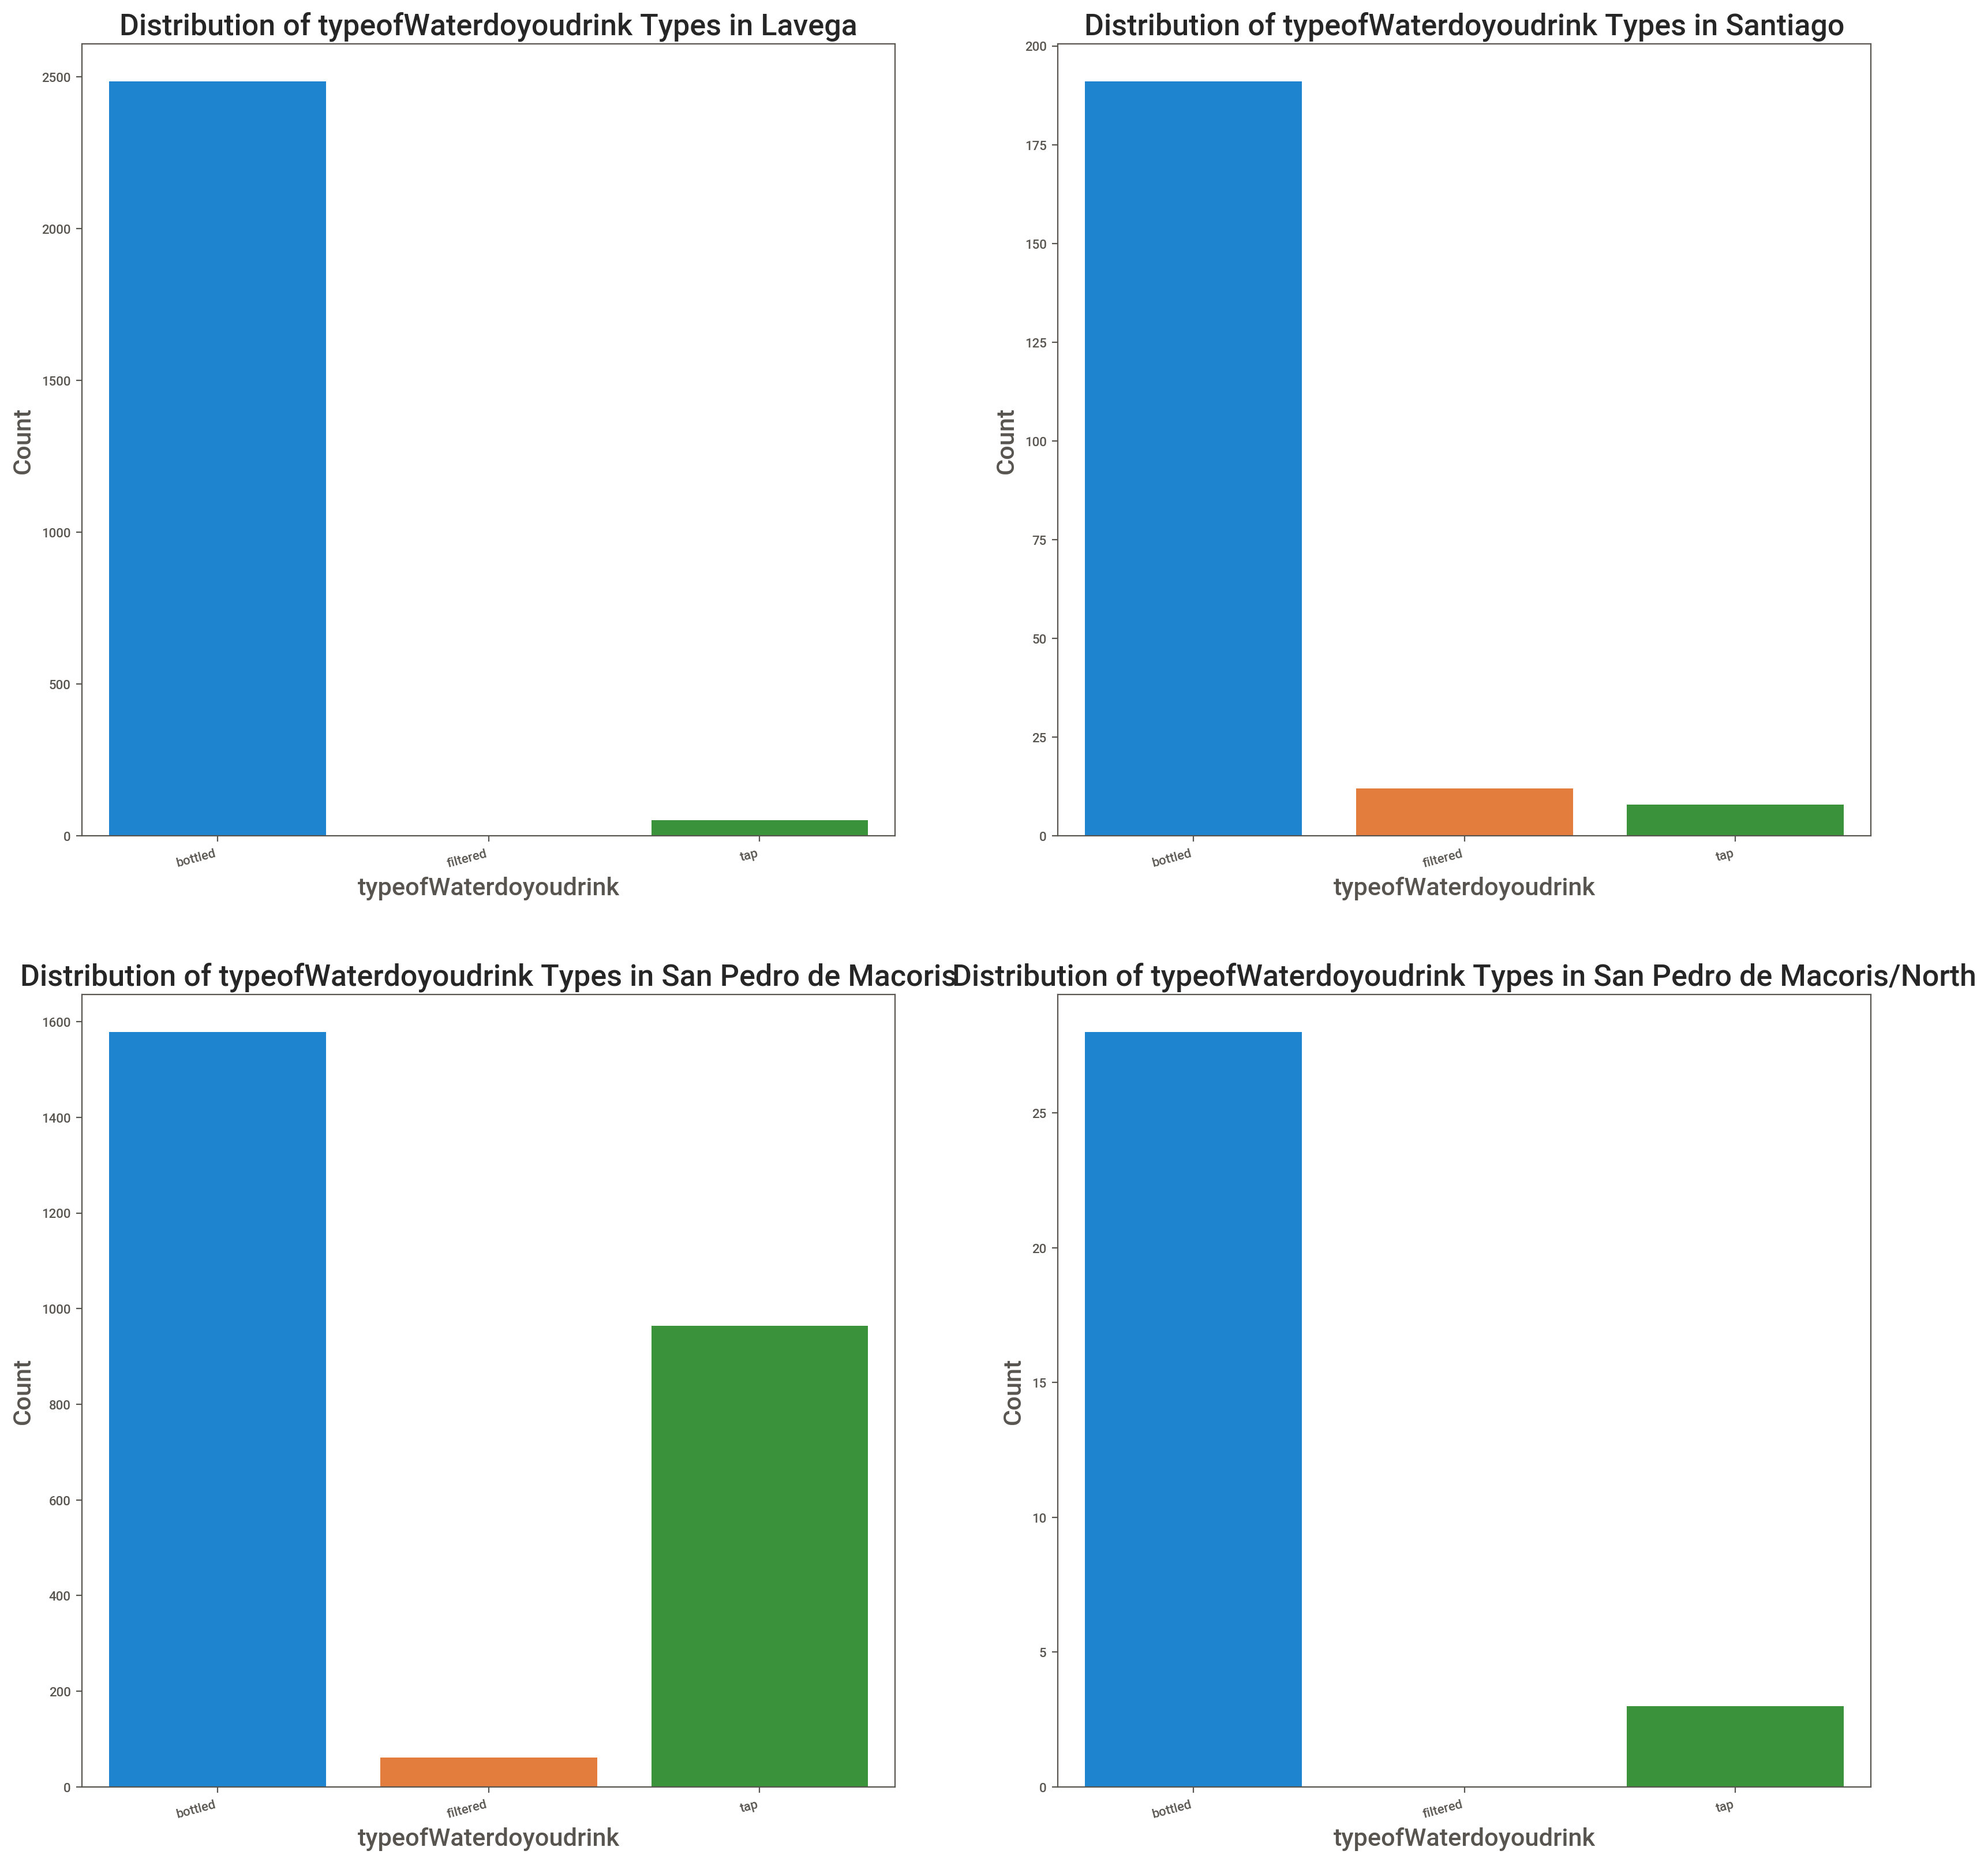

In [54]:
by_province(survey_environ, "typeofWaterdoyoudrink")

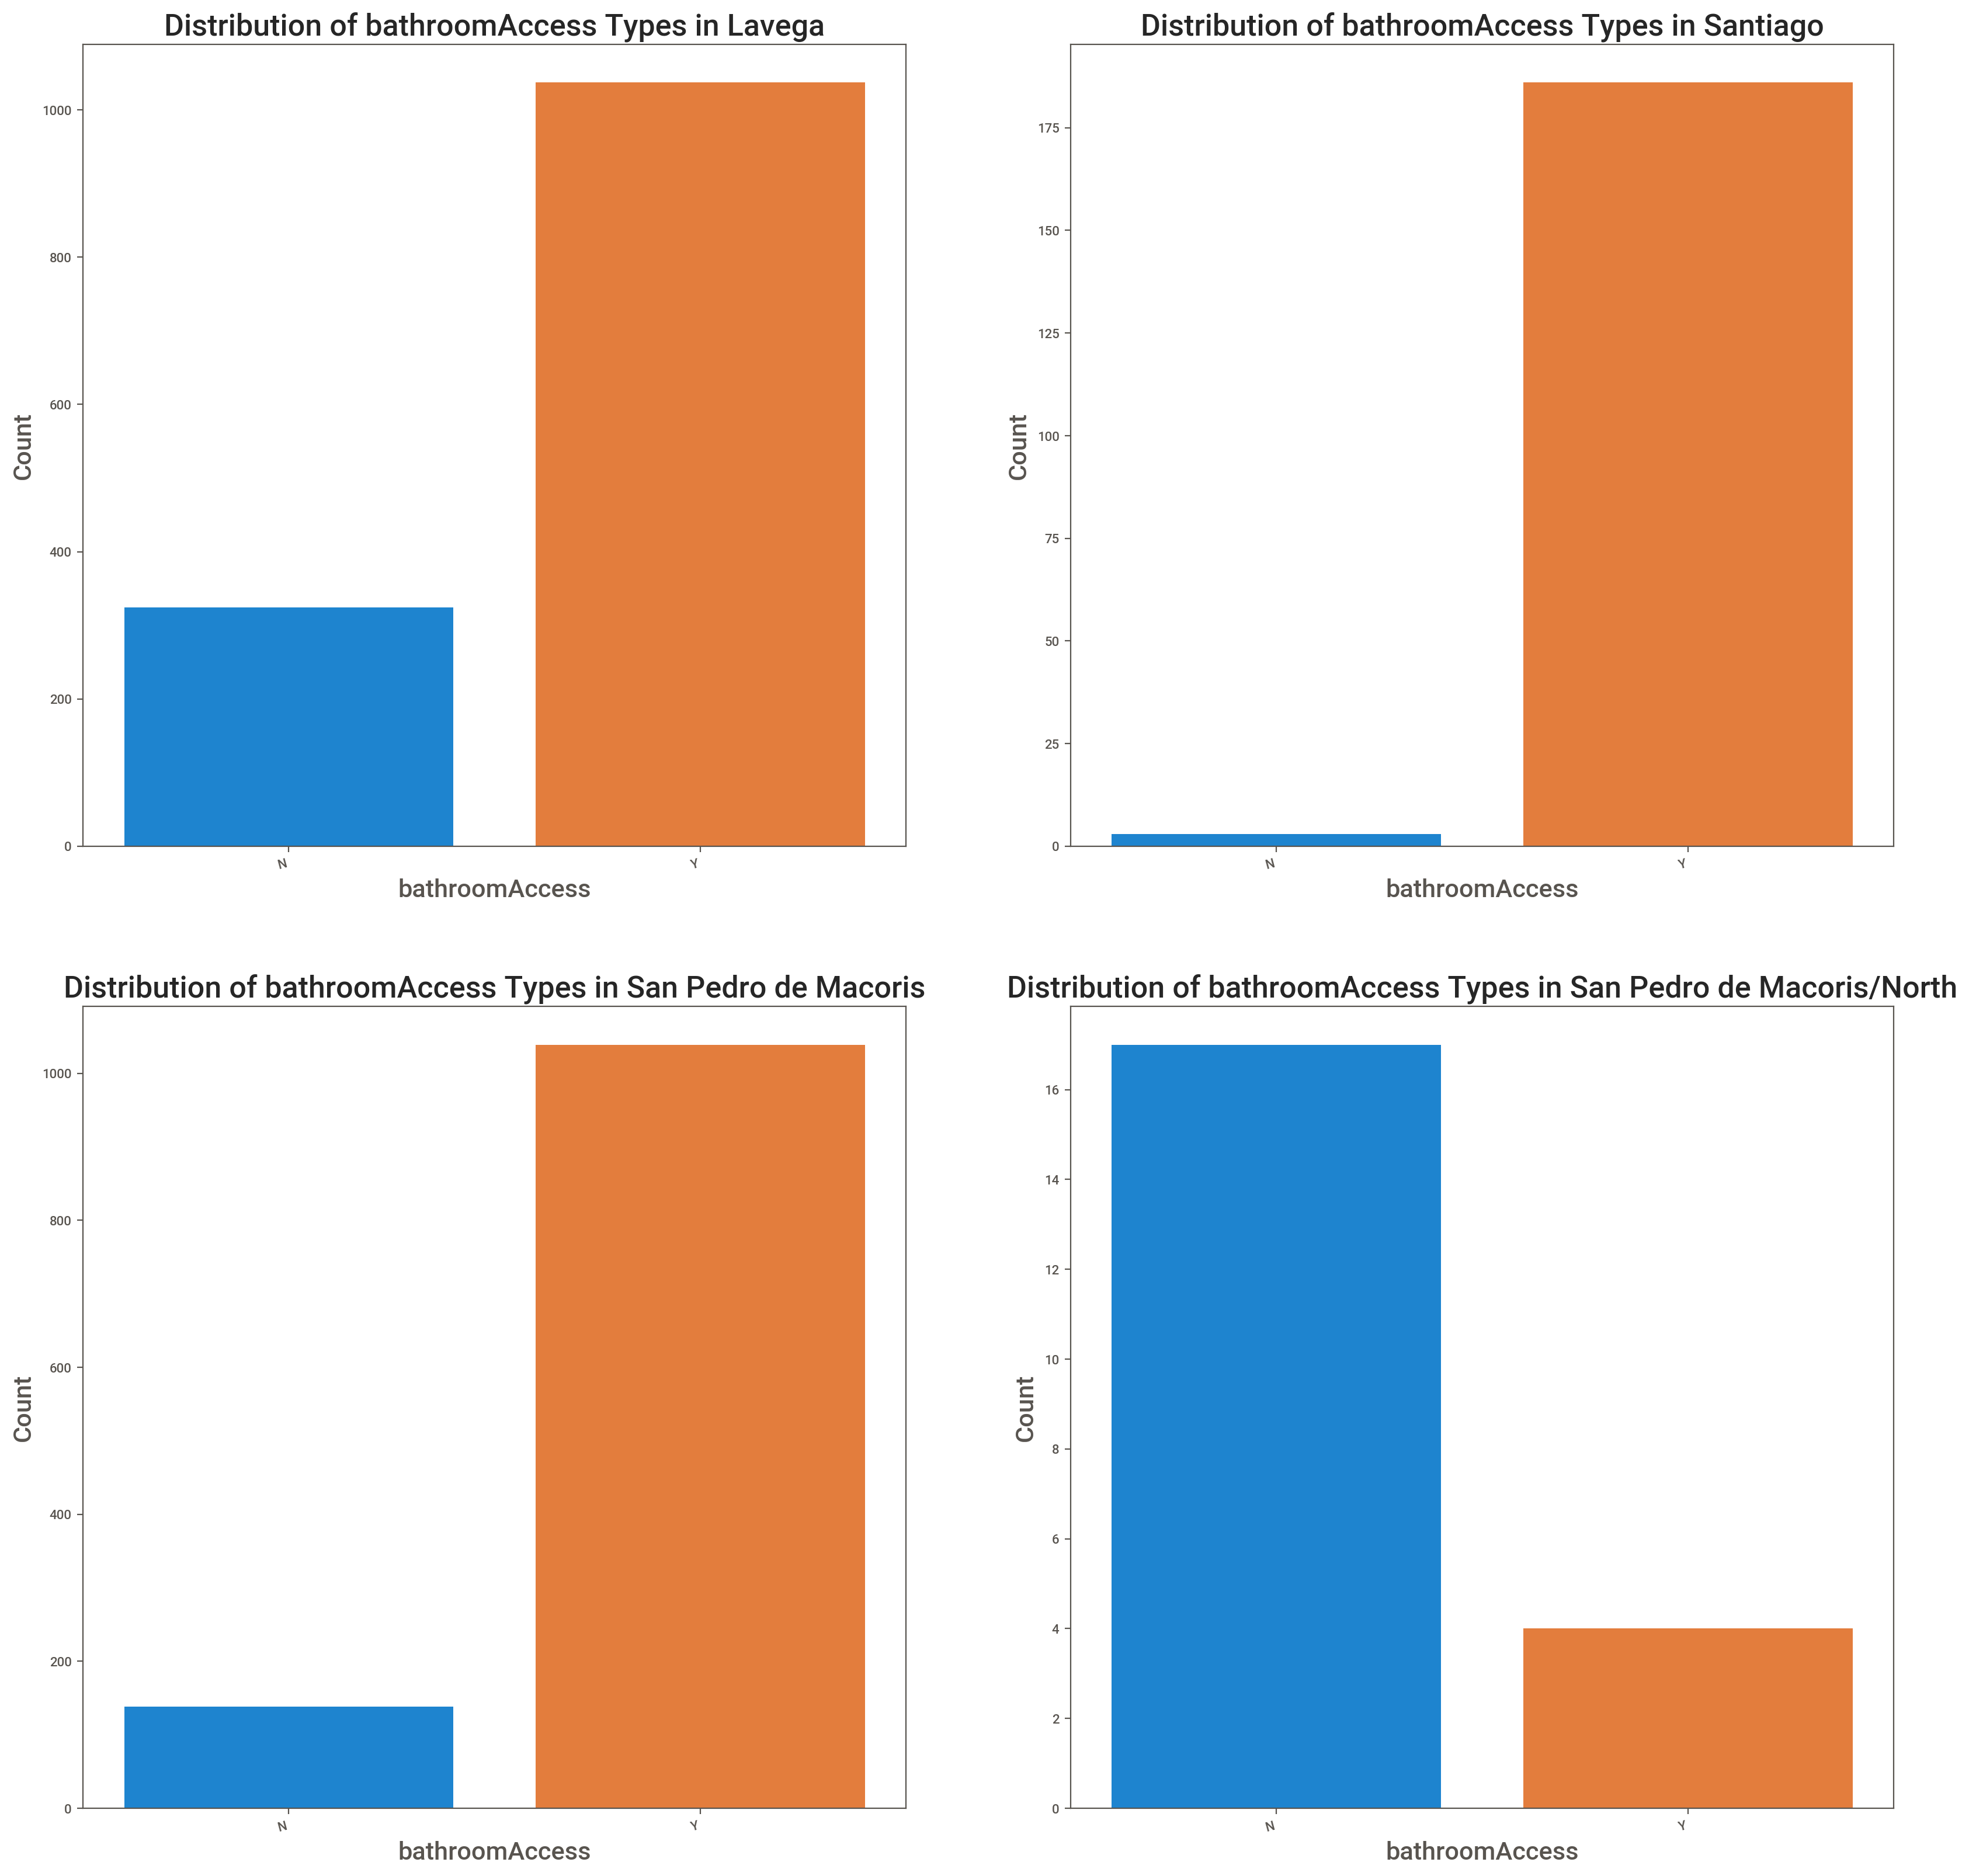

In [55]:
by_province(survey_environ, "bathroomAccess")

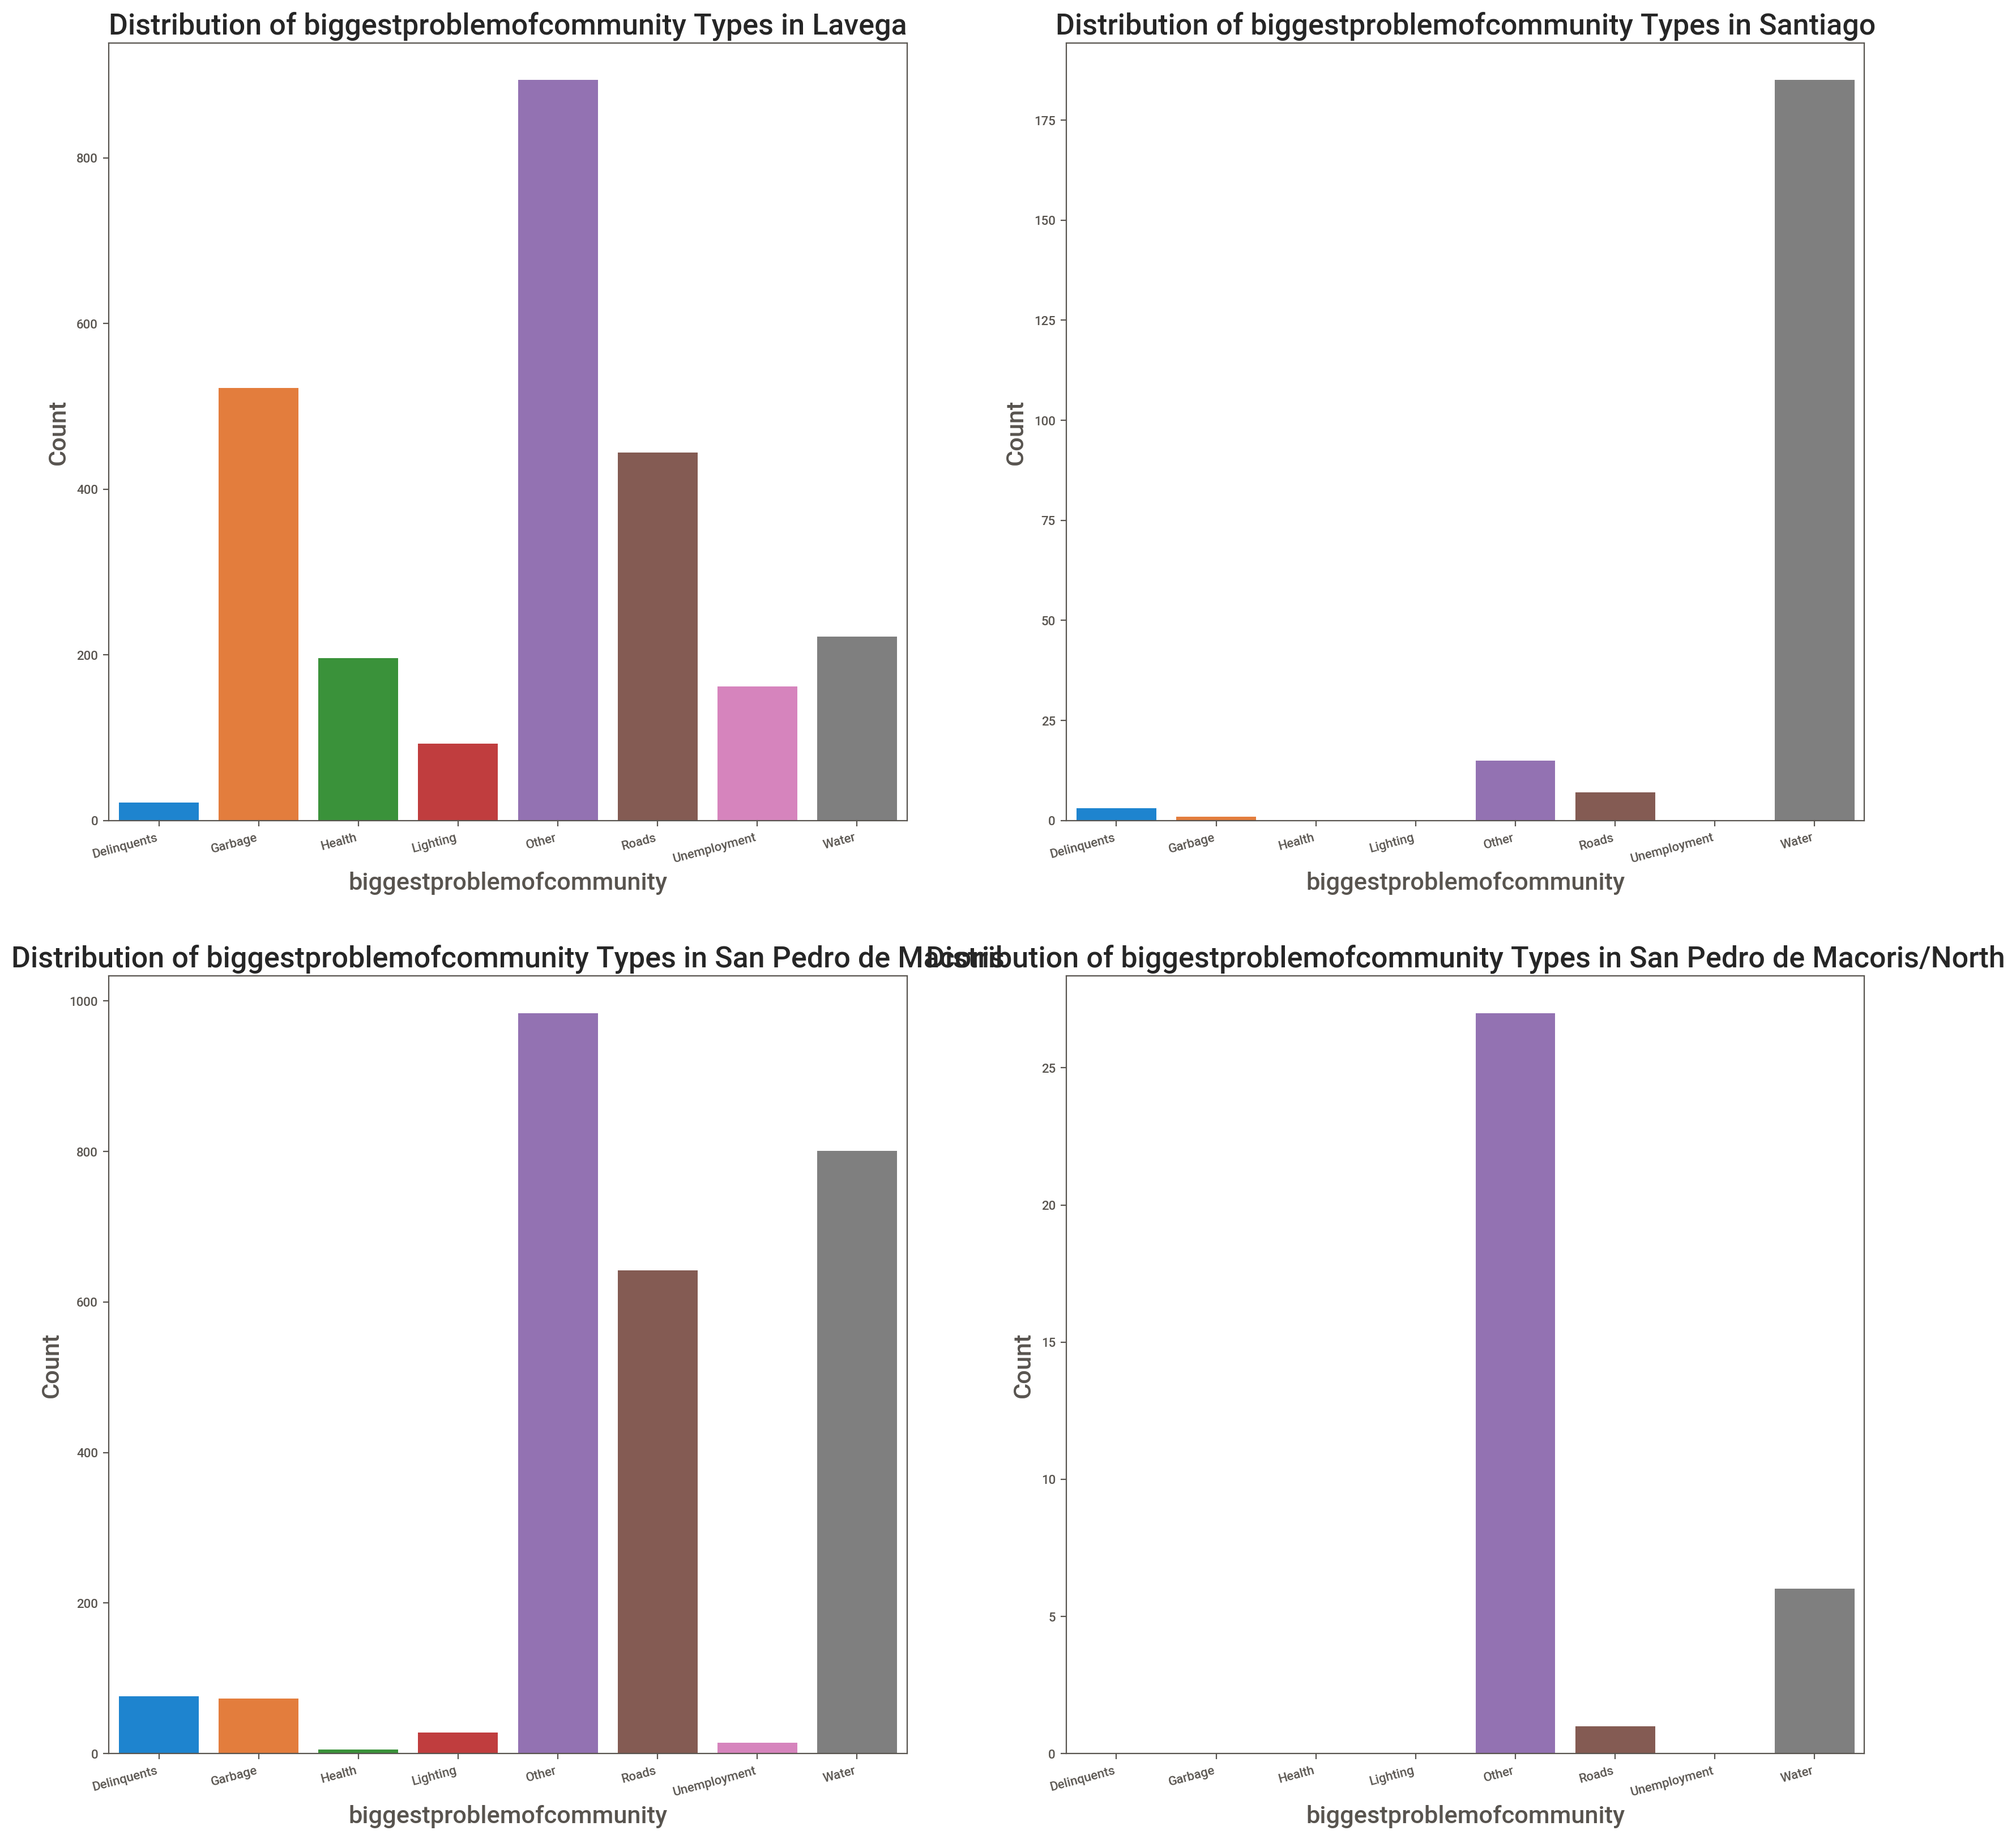

In [56]:
by_province(survey_environ, "biggestproblemofcommunity")

### 2. Survey_vitals x eval_med

In [57]:
survey_med = survey_vitals.merge(eval_med, how = "inner", on = "objectId")
survey_med.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
1  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
2  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
3  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
4  056xDPGU2U      concubine        Other  lessThanprimary  18.912727   

   longitude   age     sex  clustersByLoc              province  \
0 -70.744914  73.0    male              1  San Pedro de Macoris   
1 -70.744914  73.0    male              1  San Pedro de Macoris   
2 -70.744927  65.0  female              1  San Pedro de Macoris   
3 -70.744927  65.0  female              1  San Pedro de Macoris   
4 -70.745074  79.0    male              1  San Pedro de Macoris   

  AssessmentandEvaluation planOfAction duration part_of_body trauma_induced  \
0                     Yes         none      NaN          NaN            NaN   
1                     Yes        other      NaN          NaN            NaN   
2                      No         none      NaN          NaN            NaN   
3                     Yes        other      NaN          NaN            NaN   
4                      No         none      NaN          NaN            NaN   

  condition_progression  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [58]:
len(survey_med[survey_med["province"] == "La Vega"])

0

In [59]:
survey_med.isna().sum()

objectId                      0
marriageStatus                0
occupation                    0
educationLevel              538
latitude                      0
longitude                     0
age                           0
sex                           0
clustersByLoc                 0
province                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    645
part_of_body               1439
trauma_induced              746
condition_progression       771
dtype: int64

ValueError: Could not interpret input 'Santiago'

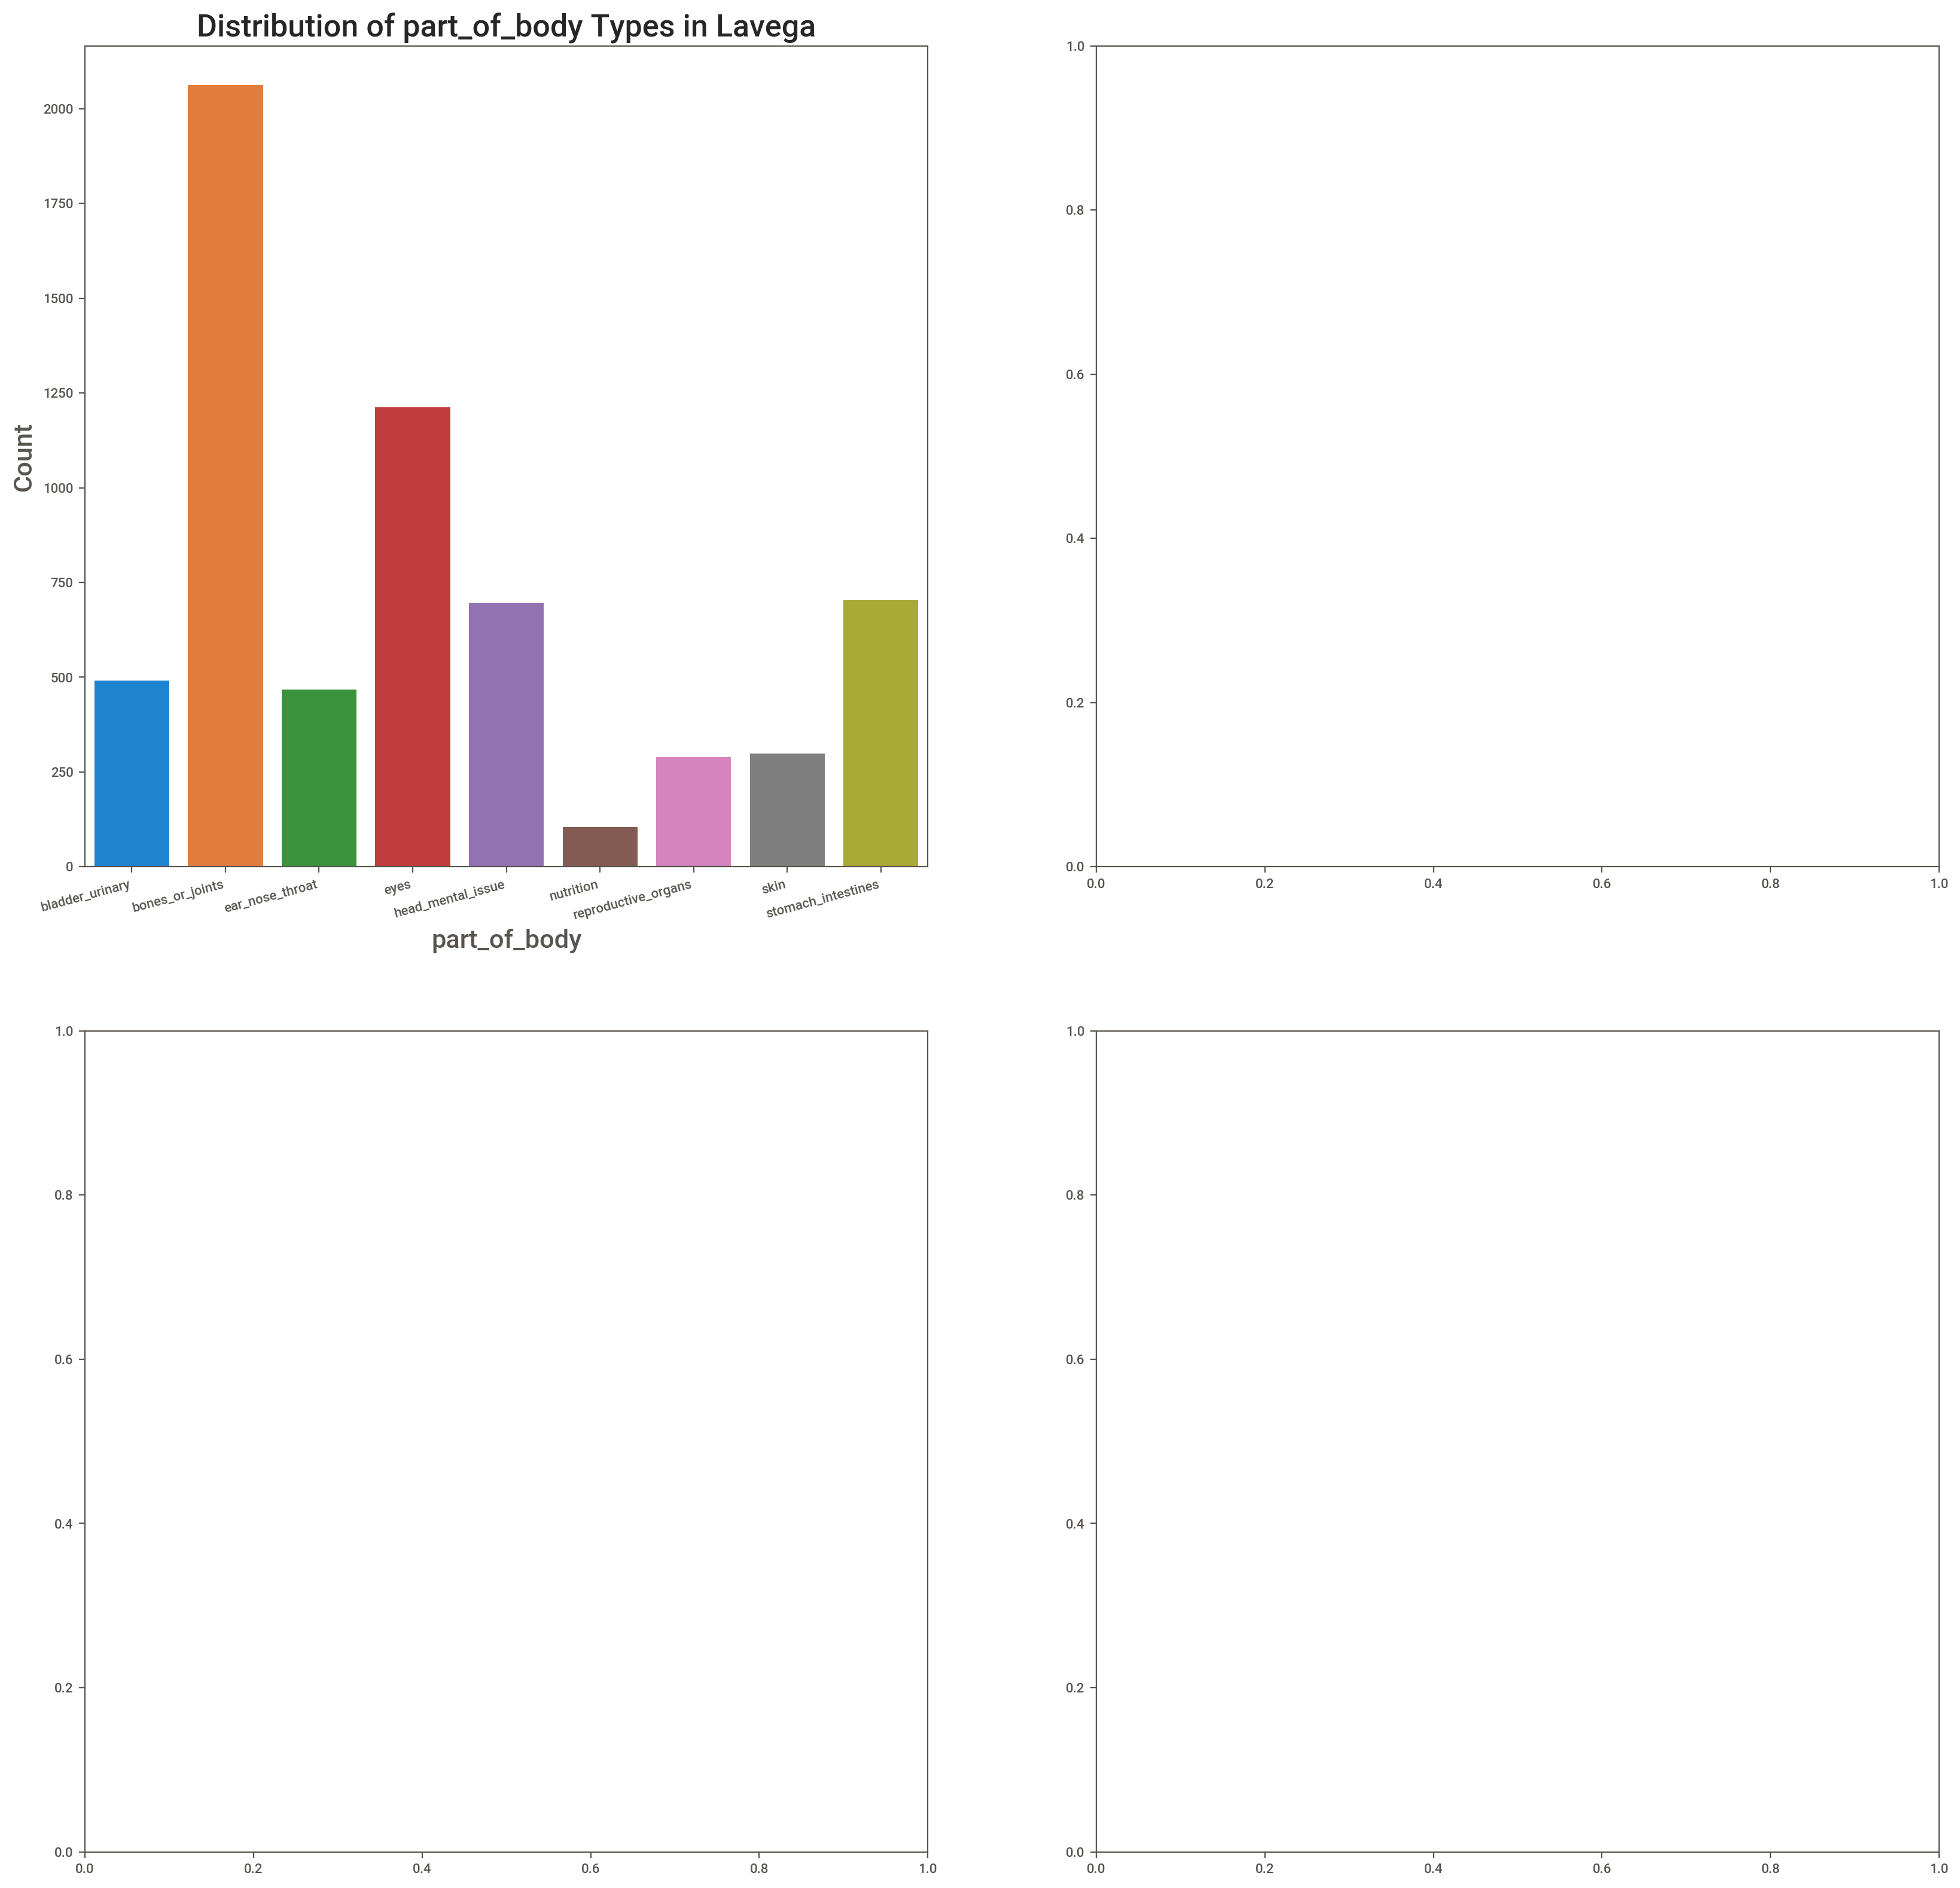

In [60]:
by_province(survey_med, "part_of_body")

In [61]:
survey_med.province.value_counts()

Lavega                        7480
San Pedro de Macoris           565
San Pedro de Macoris/North     125
Santiago                         1
Name: province, dtype: int64

                                             |                                             | [  0%]   00:00 ->…


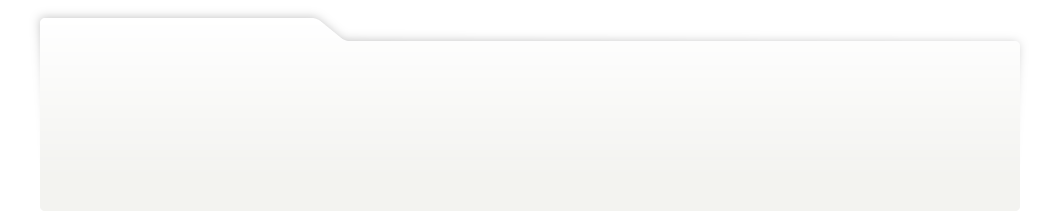
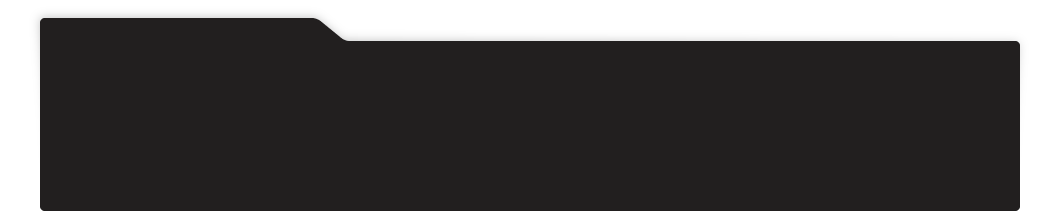
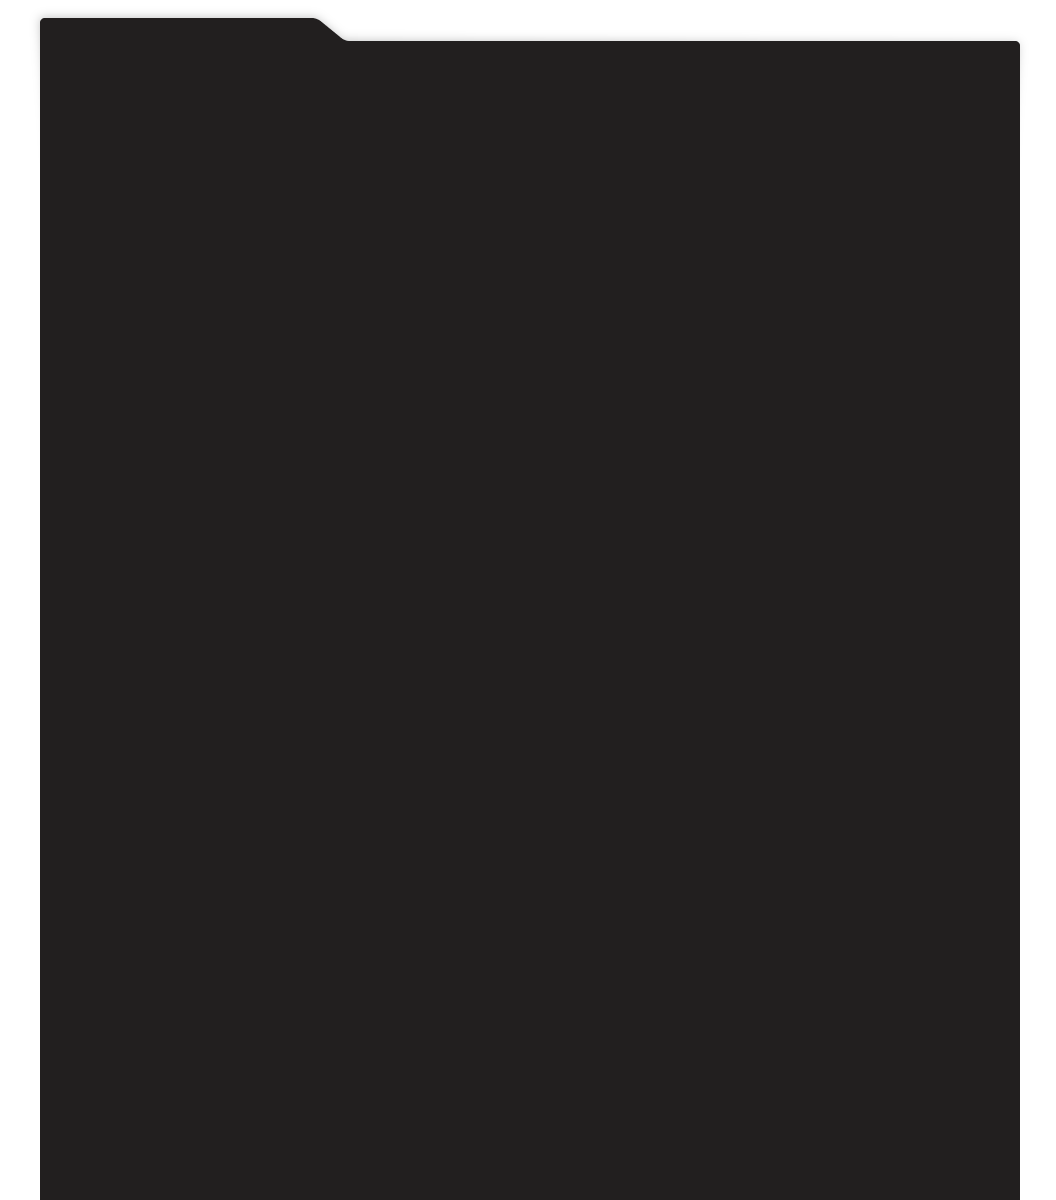
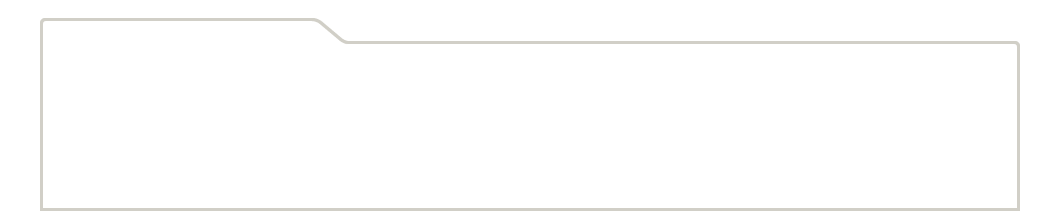
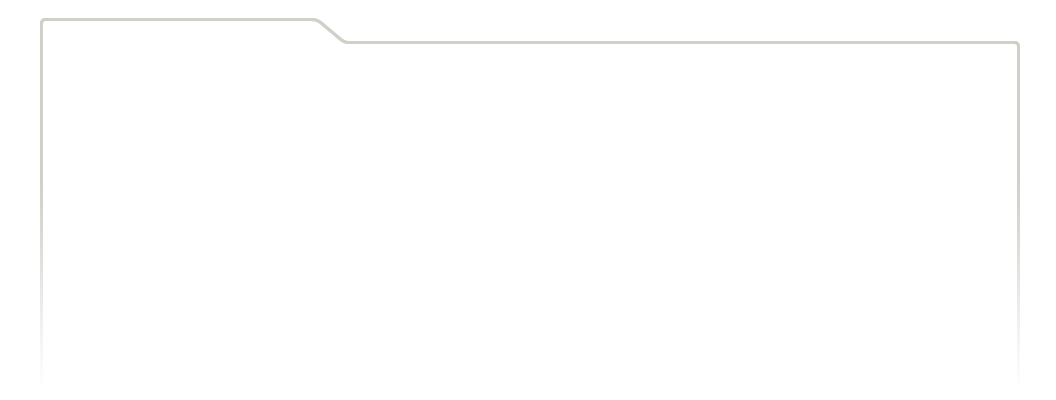
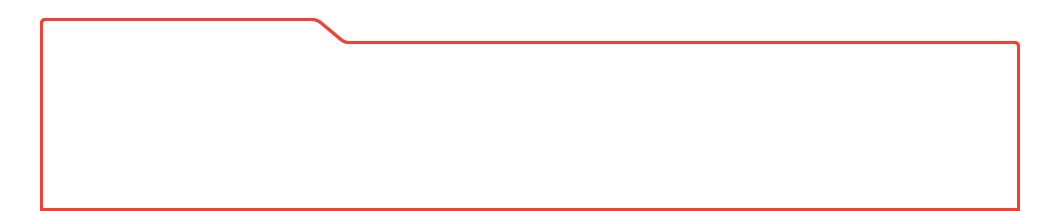
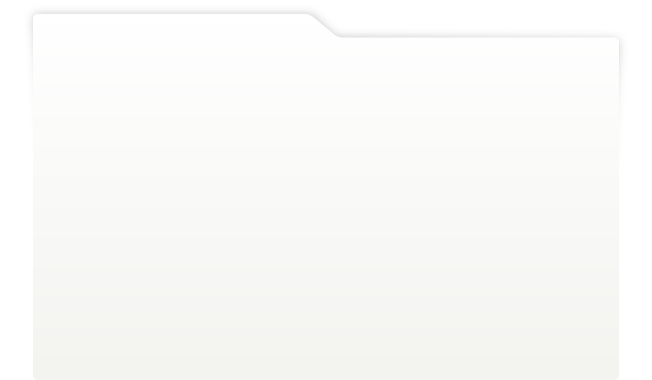
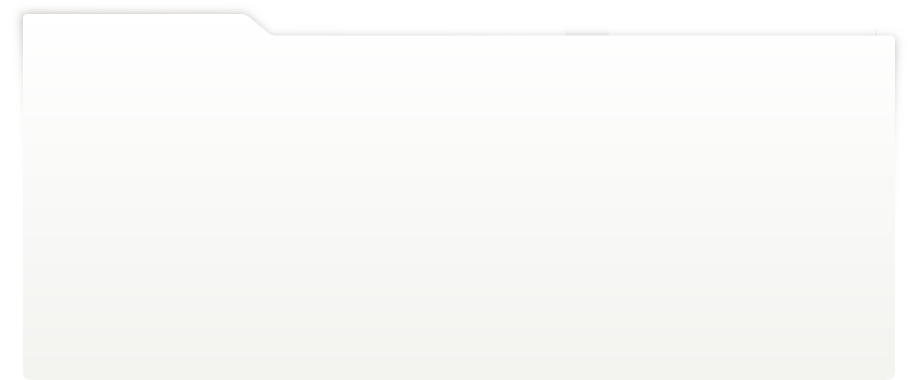
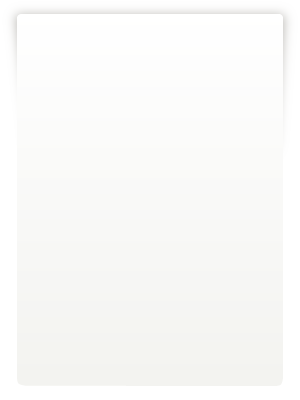
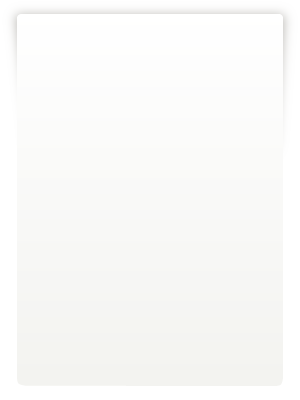
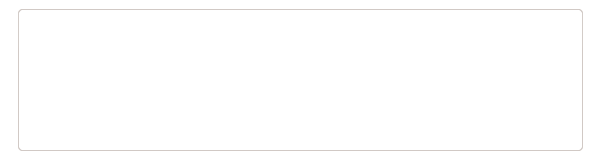
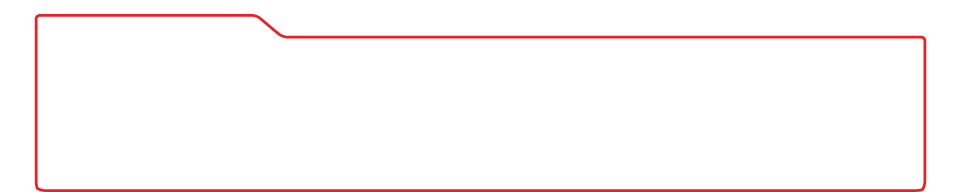
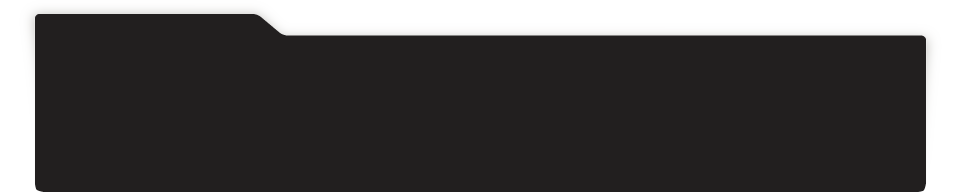
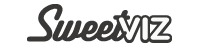
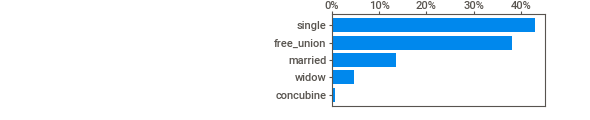
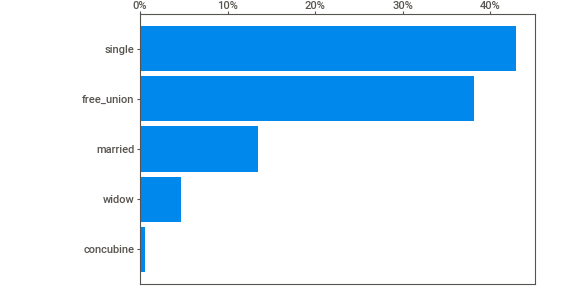
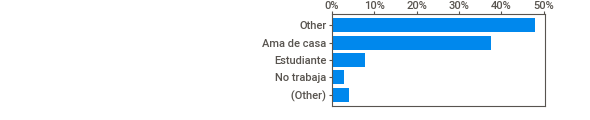
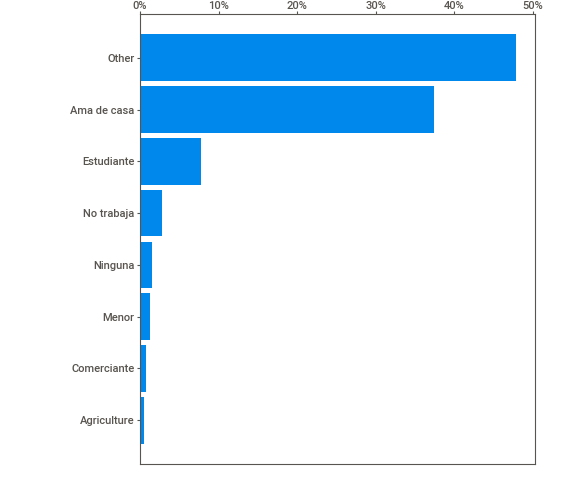
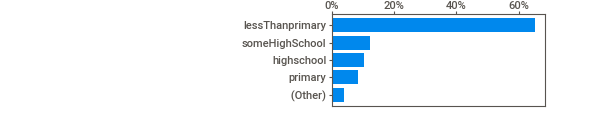
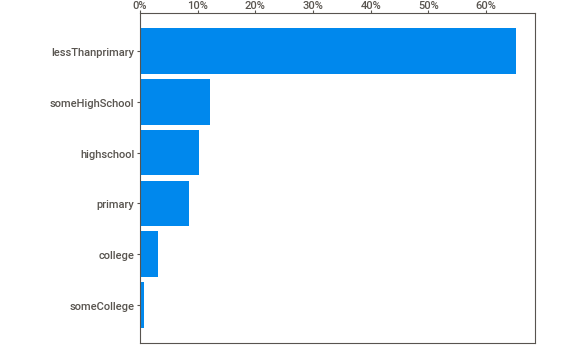
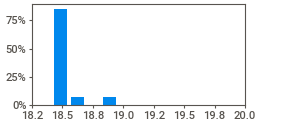
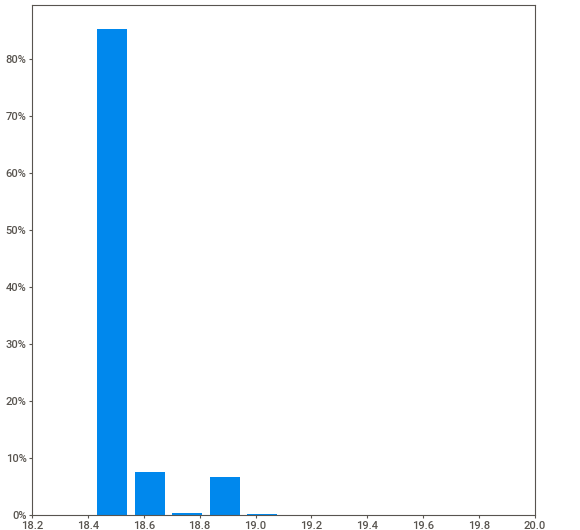
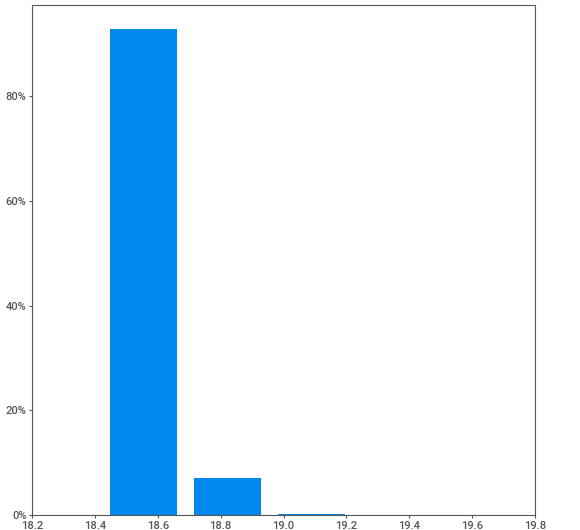
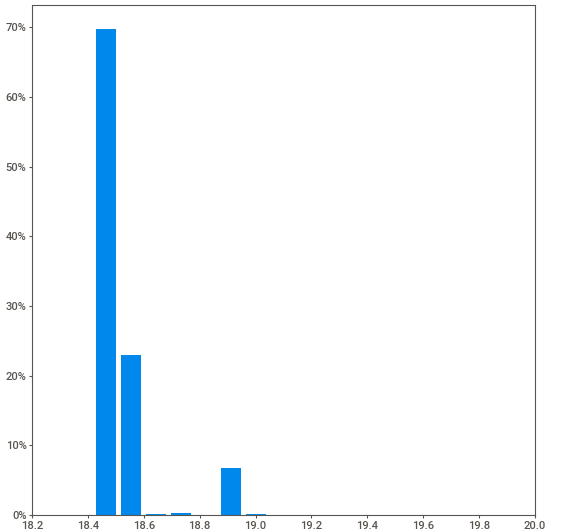
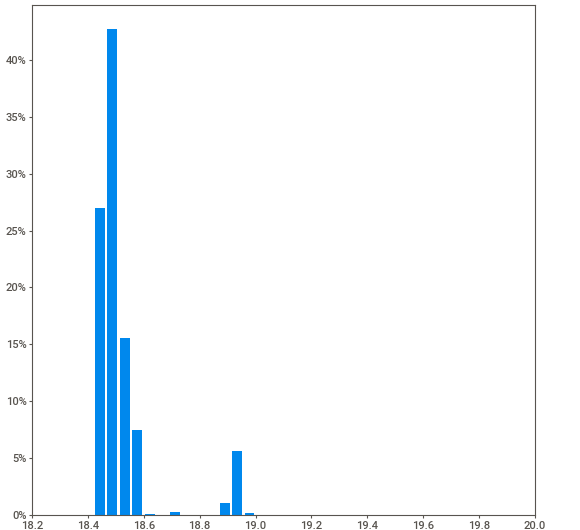
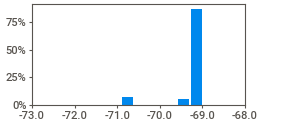
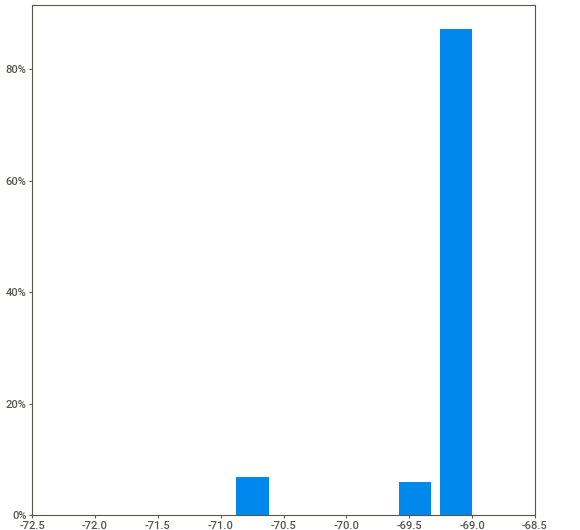
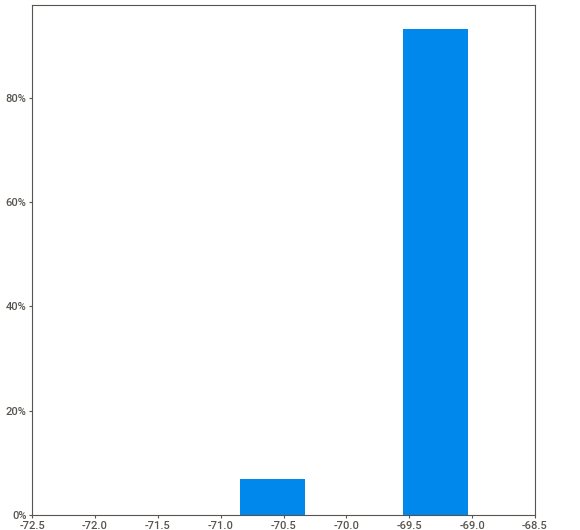
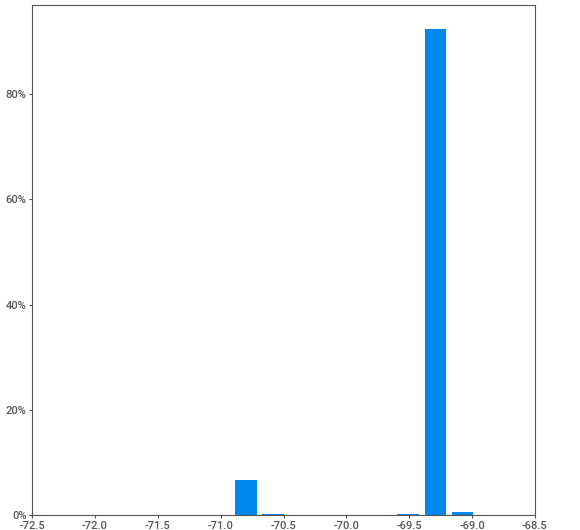
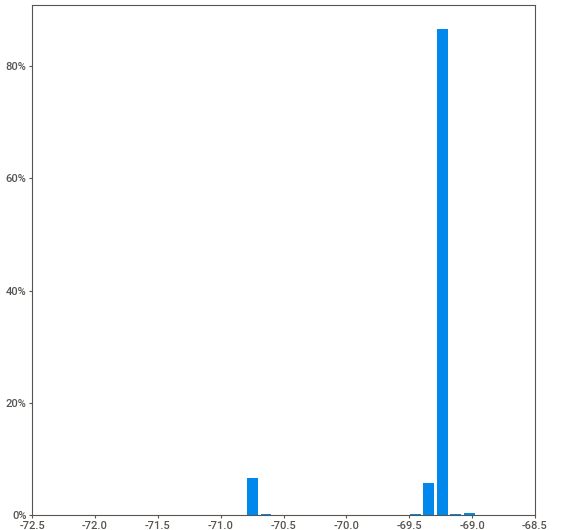
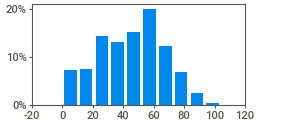
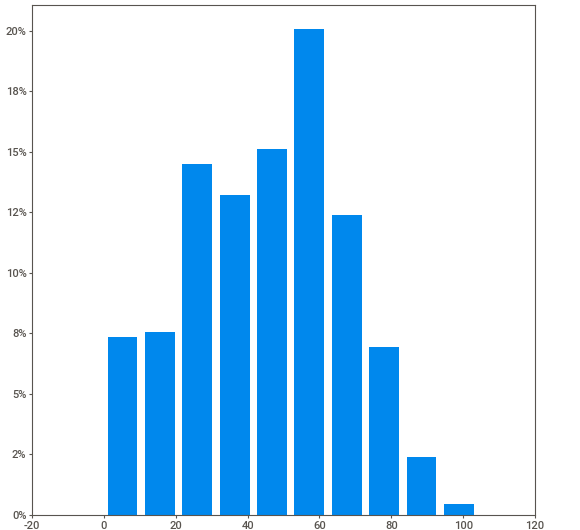
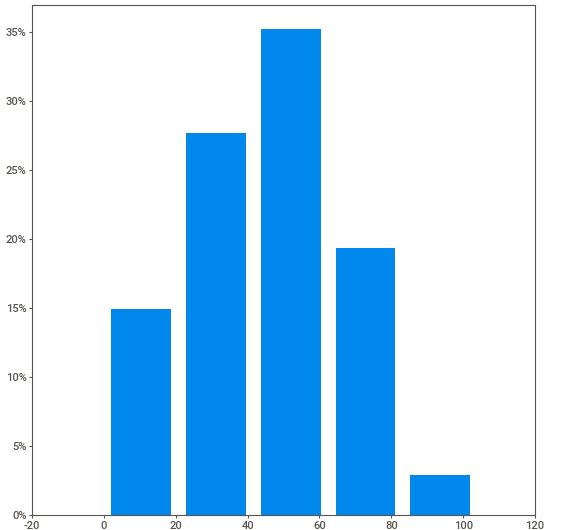
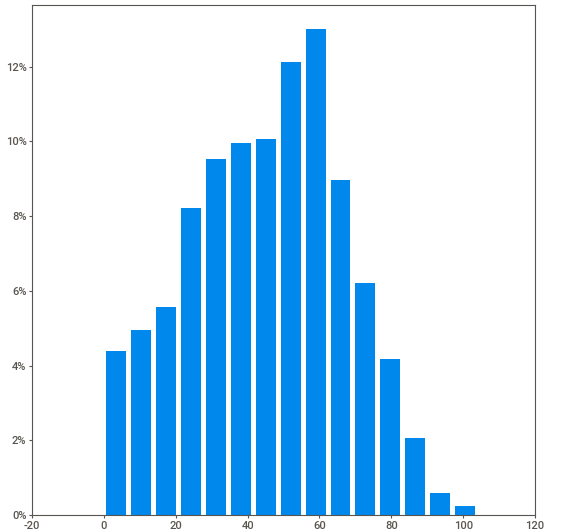
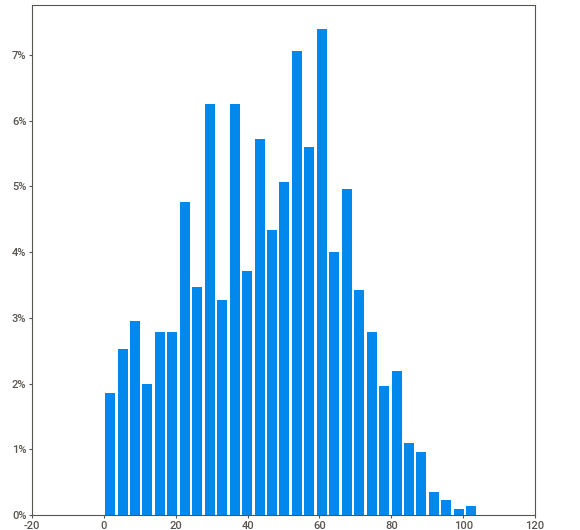
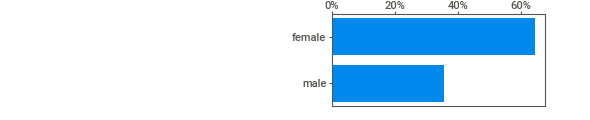
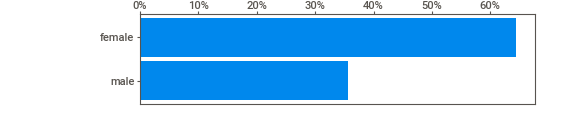
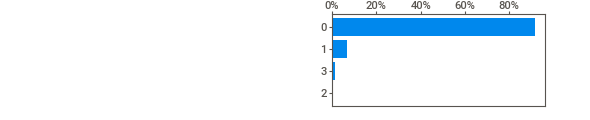
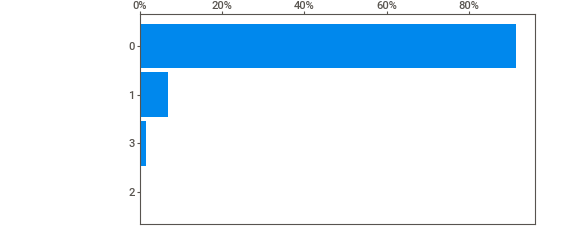
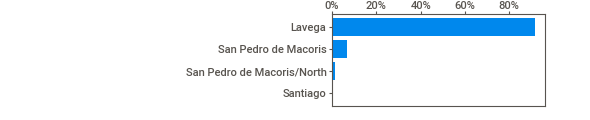
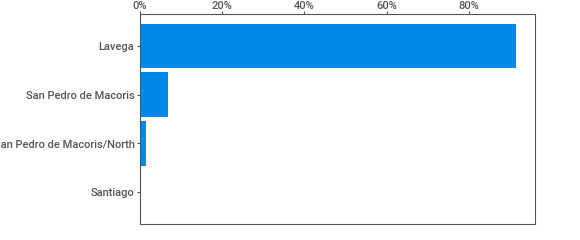
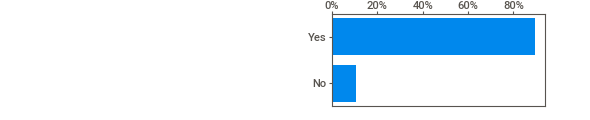
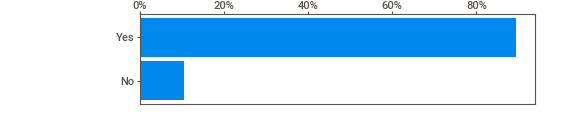
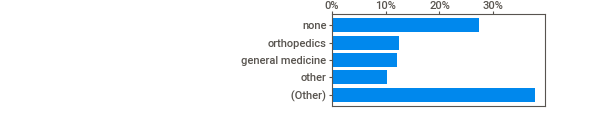
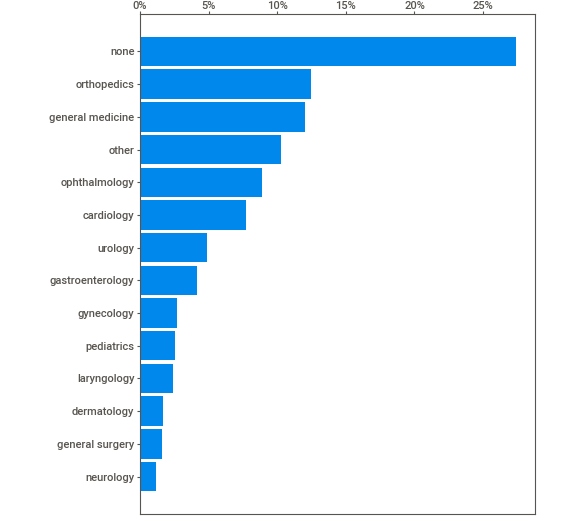
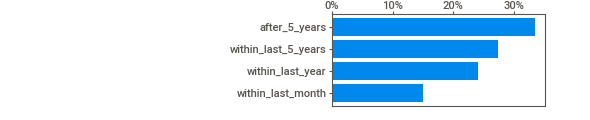
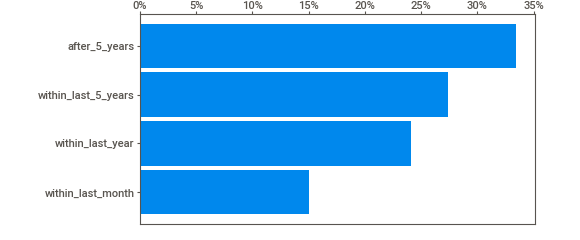
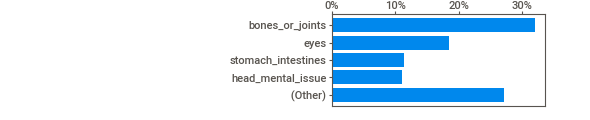
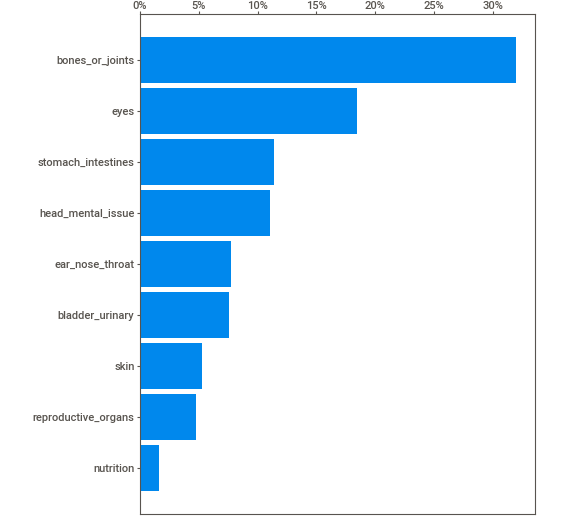
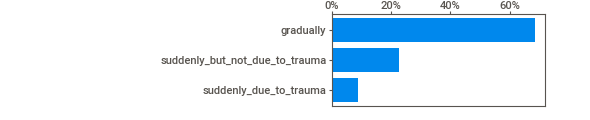
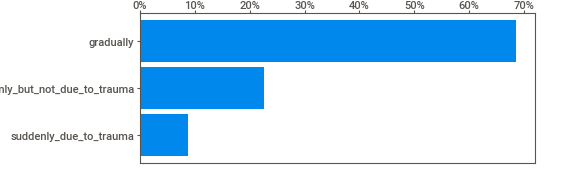
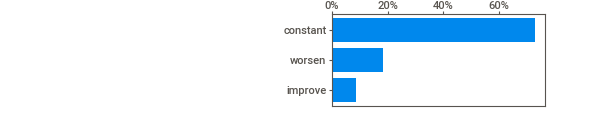
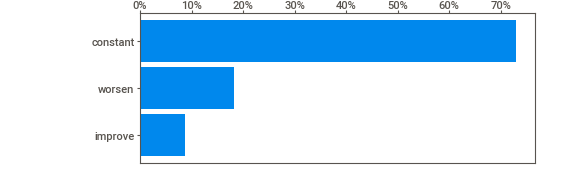
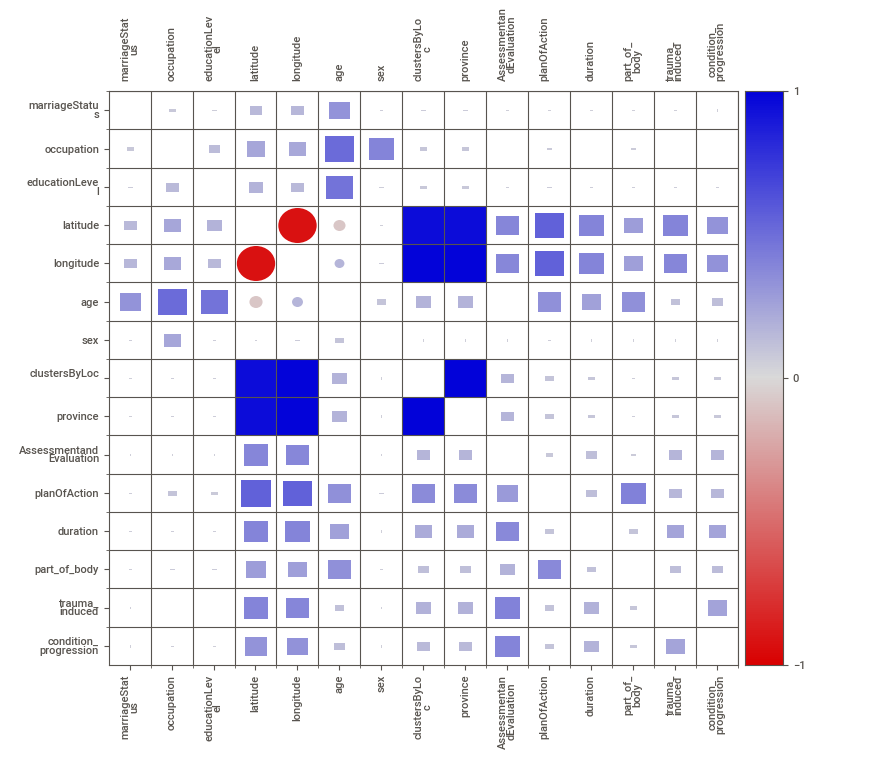
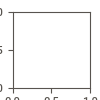

In [62]:
sv_report_survey_med = sv.analyze([survey_med, "Survey_med"])
sv_report_survey_med.show_notebook()

### 3. History_env x eval_med

In [63]:
env_med = history_env.merge(eval_med, how = "inner", on = "objectId")
env_med.head()

objectId yearsLivedinThisHouse waterAccess typeofWaterdoyoudrink  \
0  FoatG2gGXl                   1-2    everyday                   tap   
1  dzkEclDkh9                  5-10      1AWeek                   tap   
2  dzkEclDkh9            moreThan10      1AWeek               bottled   
3  spnTo4zKCI                   1-2      1AWeek               bottled   
4  spnTo4zKCI                   1-2      1AWeek               bottled   

  latrineAccess conditionoFloorinyourhouse conditionoRoofinyourhouse  \
0             Y                   dirtPoor                   working   
1             Y              cementWorking                   working   
2             Y                 cementPoor                   working   
3             Y              cementWorking                      poor   
4             Y              cementWorking                      poor   

  medicalproblemswheredoyougo dentalproblemswheredoyougo  \
0                       Other                      Other   
1              Other Hospital             Other Hospital   
2              Other Hospital                      Other   
3              Other Hospital                      Other   
4              Other Hospital             Other Hospital   

  biggestproblemofcommunity  ... numberofIndividualsLivingintheHouse  \
0                     Other  ...                                   8   
1                     Water  ...                                   3   
2                     Roads  ...                                   5   
3                     Water  ...                                   5   
4                     Water  ...                                   5   

  numberofChildrenLivinginHouseUndertheAgeof5  houseownership bathroomAccess  \
0                                           1           owned            NaN   
1                                           0           owned            NaN   
2                                           1           owned            NaN   
3                                           2          rented            NaN   
4                                           2          rented            NaN   

  AssessmentandEvaluation planOfAction           duration     part_of_body  \
0                     Yes        other                NaN              NaN   
1                     Yes         none                NaN              NaN   
2                     Yes         none                NaN              NaN   
3                      No        other  within_last_month  bones_or_joints   
4                      No        other  within_last_month  bones_or_joints   

                   trauma_induced condition_progression  
0                             NaN                   NaN  
1                             NaN                   NaN  
2                             NaN                   NaN  
3  suddenly_but_not_due_to_trauma                   NaN  
4  suddenly_but_not_due_to_trauma                   NaN  

[5 rows x 22 columns]

In [64]:
env_med.isna().sum()

objectId                                          0
yearsLivedinThisHouse                            16
waterAccess                                      52
typeofWaterdoyoudrink                            44
latrineAccess                                  2402
conditionoFloorinyourhouse                       77
conditionoRoofinyourhouse                        44
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweektrashcollected                        0
wheretrashleftbetweenpickups                      0
numberofIndividualsLivingintheHouse               0
numberofChildrenLivinginHouseUndertheAgeof5       0
houseownership                                   81
bathroomAccess                                 2310
AssessmentandEvaluation                           0
planOfAction                                      0
duration                                        389
part_of_body

In [66]:
survey_environ.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  lLkC5HGPOC          widow  Ama de casa  lessThanprimary  18.914416   
1  gIoG2SAL99          widow        Other  lessThanprimary  18.914196   
2  GiArohoFUo        married        Other          college  18.910474   
3  rnNw8AxEix         single  Ama de casa          primary  18.910484   
4  YBLTPHNqsH      concubine        Other  lessThanprimary  18.915163   

   longitude   age     sex  clustersByLoc              province  ...  \
0 -70.745642  67.0  female              1  San Pedro de Macoris  ...   
1 -70.746286  80.0    male              1  San Pedro de Macoris  ...   
2 -70.747658  41.0  female              1  San Pedro de Macoris  ...   
3 -70.747650  40.0  female              1  San Pedro de Macoris  ...   
4 -70.741626  59.0    male              1  San Pedro de Macoris  ...   

  conditionoRoofinyourhouse medicalproblemswheredoyougo  \
0                   working              Other Hospital   
1                      poor              Other Hospital   
2                       NaN                       Other   
3                   working              Other Hospital   
4                   working                      Clinic   

  dentalproblemswheredoyougo biggestproblemofcommunity  \
0             Other Hospital                     Roads   
1                    Dentist                     Roads   
2                     Clinic                     Other   
3                      Other                     Water   
4                      Other                     Other   

  timesperweektrashcollected wheretrashleftbetweenpickups  \
0                        1-2                        other   
1                        1-2                        other   
2                        3-5                        other   
3                        1-2                        other   
4                        1-2                       street   

  numberofIndividualsLivingintheHouse  \
0                                   1   
1                                   5   
2                                   4   
3                                   4   
4                                   4   

  numberofChildrenLivinginHouseUndertheAgeof5 houseownership bathroomAccess  
0                                           0         rented            NaN  
1                                           0          owned            NaN  
2                                           0            NaN            NaN  
3                                           0            NaN            NaN  
4                                           0            NaN            NaN  

[5 rows x 25 columns]

In [90]:
s_e_cluster = survey_environ.copy()
s_e_cluster = s_e_cluster.drop(["latitude","longitude"],axis=1)
s_e_cluster['objectId'] = s_e_cluster.index
s_e_cluster = pd.get_dummies(s_e_cluster)
s_e_cluster_scaled = scaler.fit_transform(s_e_cluster)

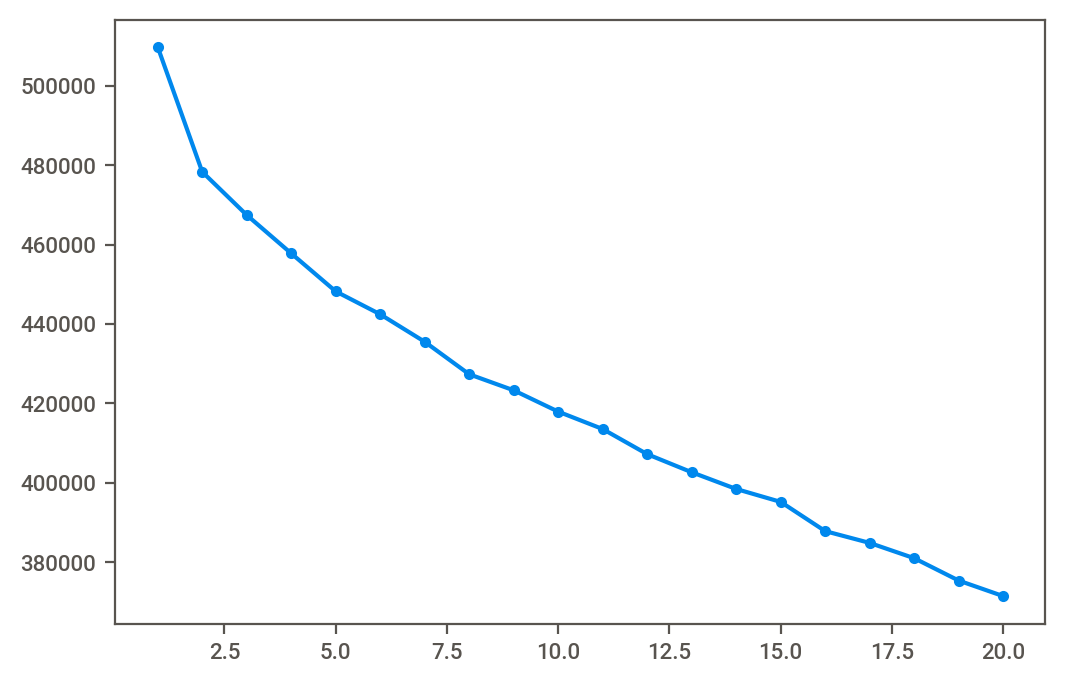

In [92]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(s_e_cluster_scaled)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [93]:
model_KMeans =  KMeans(n_clusters = 12, random_state = 42)
labels = model_KMeans.fit_predict(s_e_cluster_scaled)
labels

array([3, 1, 3, ..., 7, 7, 7])

In [94]:
labels.size

5423

In [95]:
se_clustered = survey_environ.copy()
se_clustered['cluster'] = labels
se_clustered.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  lLkC5HGPOC          widow  Ama de casa  lessThanprimary  18.914416   
1  gIoG2SAL99          widow        Other  lessThanprimary  18.914196   
2  GiArohoFUo        married        Other          college  18.910474   
3  rnNw8AxEix         single  Ama de casa          primary  18.910484   
4  YBLTPHNqsH      concubine        Other  lessThanprimary  18.915163   

   longitude   age     sex  clustersByLoc              province  ...  \
0 -70.745642  67.0  female              1  San Pedro de Macoris  ...   
1 -70.746286  80.0    male              1  San Pedro de Macoris  ...   
2 -70.747658  41.0  female              1  San Pedro de Macoris  ...   
3 -70.747650  40.0  female              1  San Pedro de Macoris  ...   
4 -70.741626  59.0    male              1  San Pedro de Macoris  ...   

  medicalproblemswheredoyougo dentalproblemswheredoyougo  \
0              Other Hospital             Other Hospital   
1              Other Hospital                    Dentist   
2                       Other                     Clinic   
3              Other Hospital                      Other   
4                      Clinic                      Other   

  biggestproblemofcommunity timesperweektrashcollected  \
0                     Roads                        1-2   
1                     Roads                        1-2   
2                     Other                        3-5   
3                     Water                        1-2   
4                     Other                        1-2   

  wheretrashleftbetweenpickups numberofIndividualsLivingintheHouse  \
0                        other                                   1   
1                        other                                   5   
2                        other                                   4   
3                        other                                   4   
4                       street                                   4   

  numberofChildrenLivinginHouseUndertheAgeof5 houseownership bathroomAccess  \
0                                           0         rented            NaN   
1                                           0          owned            NaN   
2                                           0            NaN            NaN   
3                                           0            NaN            NaN   
4                                           0            NaN            NaN   

  cluster  
0       3  
1       1  
2       3  
3       3  
4       3  

[5 rows x 26 columns]

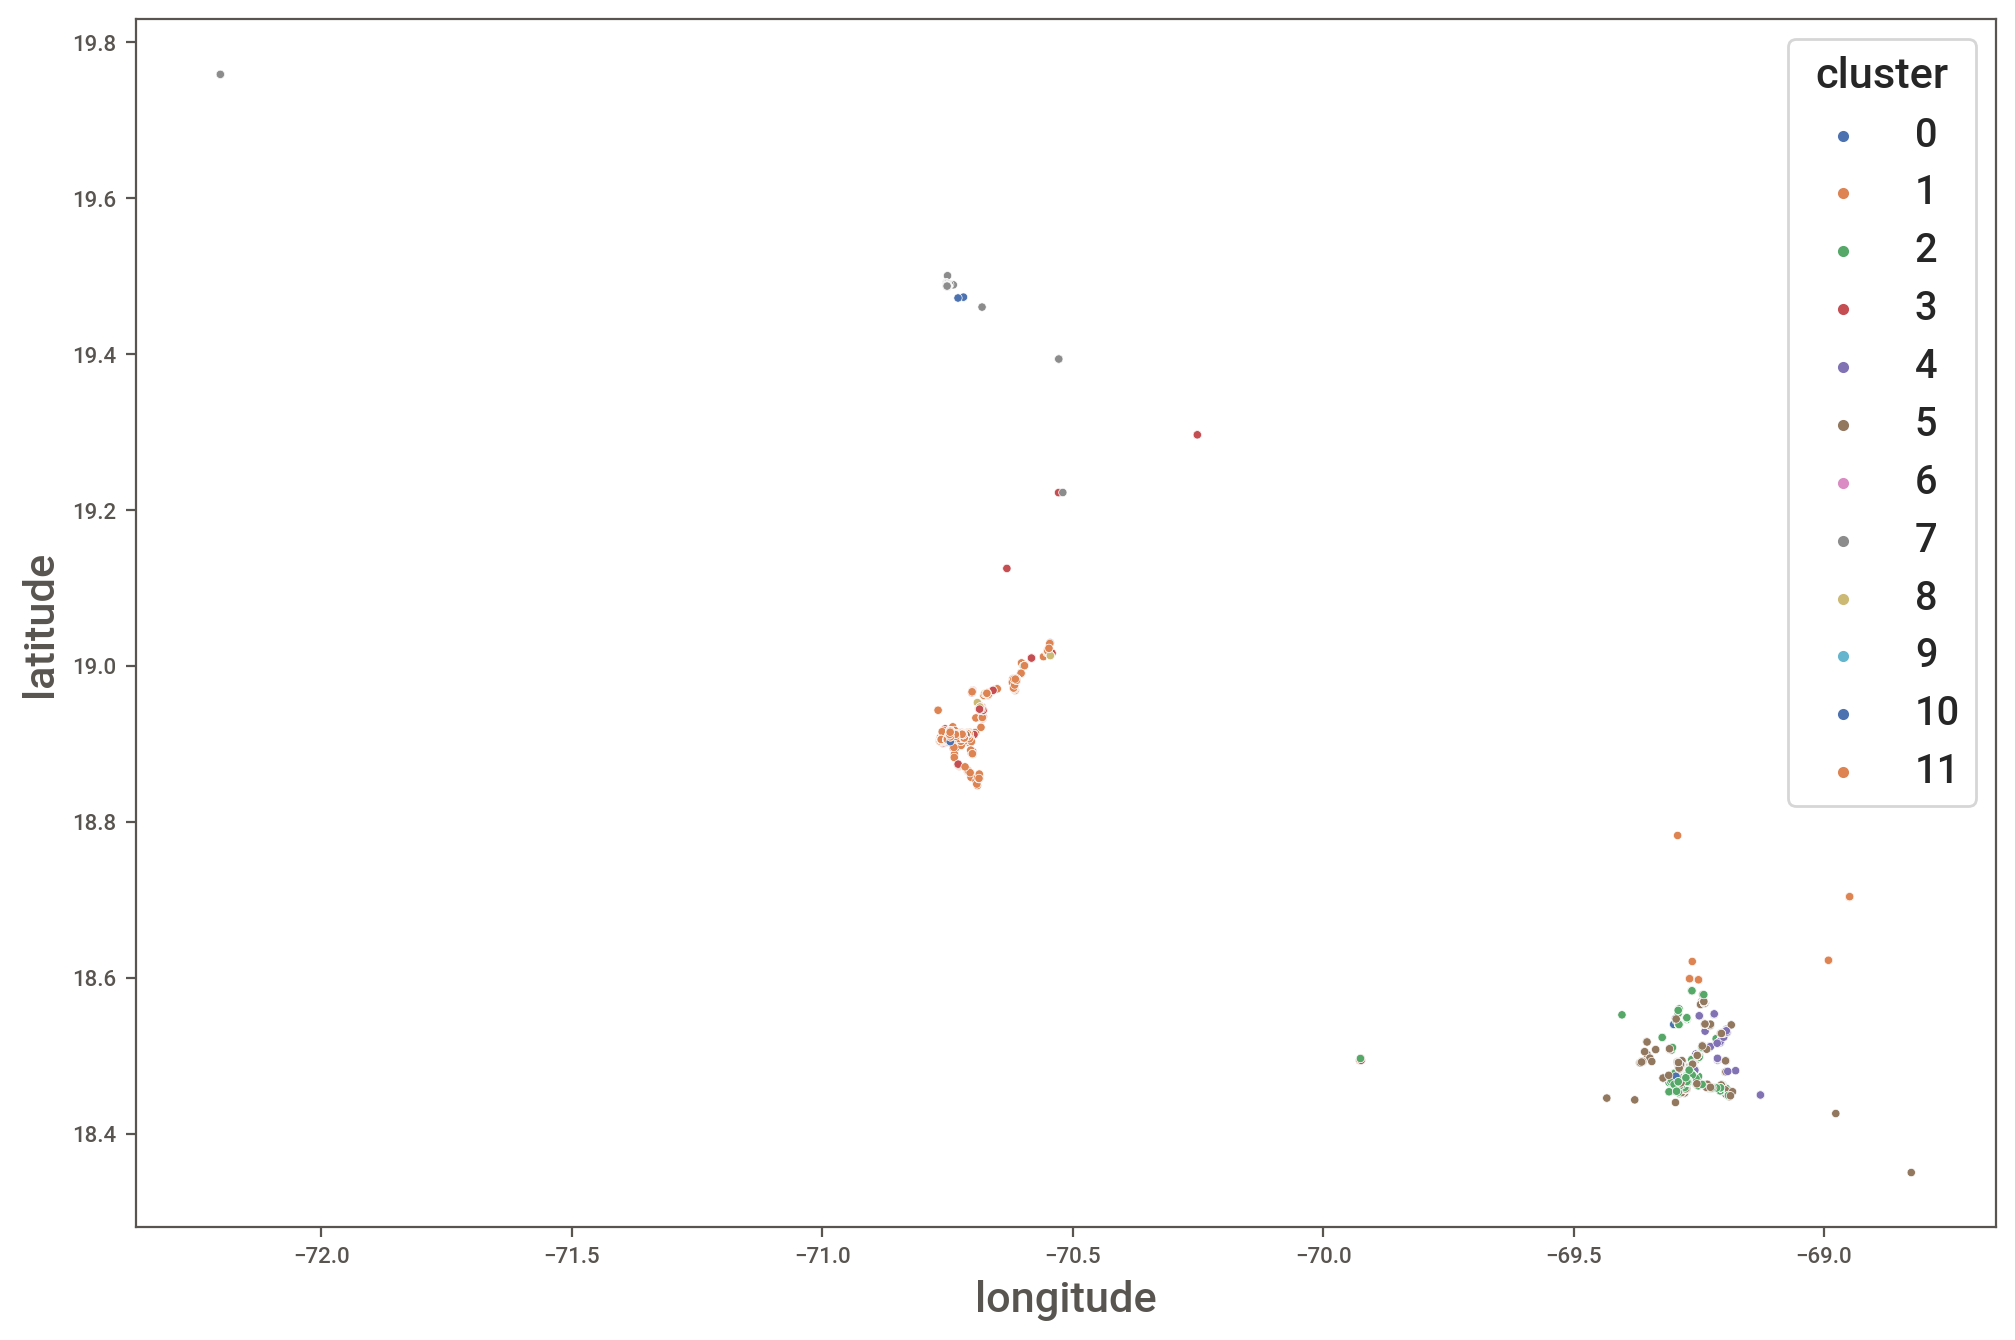

In [96]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = se_clustered, x = "longitude", y = "latitude", hue = "cluster", palette = "deep")

In [105]:
s_e_cluster['cluster'] = labels
pd.set_option('max_columns', None)
s_e_cluster.groupby('cluster').sum()

objectId      age  clustersByLoc  \
cluster                                     
0          207760   4083.0              8   
1         5016990  64915.0           1384   
2         4015453  70276.0             12   
3         1335484  41285.0           1032   
4          314059   8776.0              0   
5         2057013  33140.0              6   
6            1128     34.0              0   
7         1030218   7972.0            398   
8          371271   4066.0            147   
9           67361    730.0             20   
10         154303   2499.0             38   
11         130713   1416.0            102   

         numberofIndividualsLivingintheHouse  marriageStatus_concubine  \
cluster                                                                  
0                                        235                       2.0   
1                                       4743                       4.0   
2                                       5450                       1.0   
3                                       3880                     172.0   
4                                        797                       0.0   
5                                       2761                       0.0   
6                                          5                       0.0   
7                                        706                       0.0   
8                                        683                       6.0   
9                                         75                       0.0   
10                                       234                       6.0   
11                                       123                       0.0   

         marriageStatus_free_union  marriageStatus_married  \
cluster                                                      
0                             16.0                    13.0   
1                            649.0                   170.0   
2                            629.0                   205.0   
3                            173.0                   219.0   
4                            119.0                    17.0   
5                            352.0                    91.0   
6                              1.0                     0.0   
7                             95.0                    29.0   
8                             42.0                    16.0   
9                              5.0                     4.0   
10                            24.0                    10.0   
11                            15.0                     5.0   

         marriageStatus_single  marriageStatus_widow  occupation_Agriculture  \
cluster                                                                        
0                         36.0                   7.0                     0.0   
1                        466.0                  96.0                   164.0   
2                        558.0                  75.0                     2.0   
3                        437.0                  40.0                    48.0   
4                         65.0                   8.0                     2.0   
5                        278.0                  26.0                     1.0   
6                          0.0                   0.0                     0.0   
7                         71.0                   4.0                     1.0   
8                        116.0                   0.0                     0.0   
9                         12.0                   0.0                     0.0   
10                        22.0                   2.0                     0.0   
11                        14.0                   0.0                     1.0   

         occupation_Ama de casa  occupation_Comerciante  \
cluster                                                   
0                           0.0                     0.0   
1                         641.0                    40.0   
2                         716.0                    18.0   
3                         410.0                    25.0 